In [1]:
import multiprocessing as mp                                                                                                                                                                                       
import os                                                                                                                                                                                                          
import numpy as np                                                                                                                                                                                                 
import awkward as ak                                                                                                                                                                                               
import matplotlib.pyplot as plt                                                                                                                                                                                    
import matplotlib                                                                                                                                                                                                  
import matplotlib.colors as colors                                                                                                                                                                                 
from tools.roottree import read_tree                                                                                                                                                                               
from tools.selections import *                                                                                                                                                                                     
import scipy.stats                                                                                                                                                                                                 
from scipy.optimize import curve_fit                                                                                                                                                                               
                                                                                                                   
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar, FIGSIZE_MID, FIGSIZE_BIG, setplot_defaultstyle, format_order_of_magnitude, FONTSIZE                                                           
from tools.studybeta import calc_signal_fraction                                                                                
from tools.binnings_collection import fbinning_fraction, fbinning_RICHnpe                                                                                                                                          
from tools.binnings_collection import get_nbins_in_range, get_sub_binning, get_bin_center                                                                                                                          
from tools.studybeta import minuitfit_LL, cdf_gaussian, calc_signal_fraction, cdf_double_gaus, double_gaus, minuitfit_Chi
from tools.histograms import WeightedHistogram, Histogram, plot_histogram_2d, plot_histogram_1d   
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, plot1d_step, FONTSIZE, set_plot_defaultstyle  
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS, ISOTOPES
from tools.functions import cumulative_norm_gaus, normalized_gaussian, poly, upoly
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs, Add_point_to_graph

from tools.constants import ISOTOPES_MASS, DETECTOR_COLOR, ISOTOPES
from tools.massfit_tools import get_fitpdferrorband, get_fitpdf_witherr
import uncertainties                                                                                                                                                                                               
from uncertainties import unumpy                                                                                                                                                                                   
from uncertainties import ufloat   
from tools.jupytertools import *


/home/manbing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:

detectors = ['Tof', 'NaF','Agl']
hist2d_mc = {}
hist2d_iss = {}
nuclei = 'C'
MCIso = 'C12'

filename_histISS = f'/home/manbing/Documents/Data/data_BeP8/2DHist/{nuclei}ISS_masshist_EkinP8GBL_finebin_RigReso.npz'
filename_histMC = f'/home/manbing/Documents/Data/data_BeP8/2DHist/{nuclei}MC_hist_RigReso_RefBetaTuned_vsRig_fluxweight.npz'

isotopes = ISOTOPES[nuclei]
datadir = '/home/manbing/Documents/Data/data_BeP8/'
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Oxygen_RigRefBeta'
os.makedirs(plotfile, exist_ok=True)

figsuffix = 'RigReso_RefBeta_Carbon'
isscolor = 'black'
mccolor = 'blue'
figtext = 'Tuned'

nucleiname = {'O': 'Oxygen', 'C':'Carbon', 'Be': 'Be', 'B': 'Boron', 'Li': 'Li'}
MCNameText = {'Be': 'Be MC(Be7:9:10=[6:3:1])', 'B': 'B MC(B10:B11=[1:1])', 'C': 'C12 MC', 'O': 'O16 MC', 'Li': 'Li MC(Li6:7=1:1)'}



In [3]:

def get_musigma_gausfit(hist2d_mc_tofTrue, minbin, maxbin, guess0, xrange, FigName=None):
    energy_binvalues = hist2d_mc_tofTrue.binnings[0].bin_centers[minbin:maxbin]
    graph_mean_mcTofTrueReso = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))
    graph_sigma_mcTofTrueReso = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))

    for ip, ibin in enumerate(range(minbin, maxbin)):
   
        lowbinedge = hist2d_mc_tofTrue.binnings[0].edges[ibin]
        upbinedge = hist2d_mc_tofTrue.binnings[0].edges[ibin + 1]
        hist1d_mc = hist2d_mc_tofTrue.project(ibin) 
        hist1d_mc = hist1d_mc * (1/np.sum(hist1d_mc.values))
    

        xbinrange = hist1d_mc.binnings[0].get_indices(xrange)
    
        xedges_mc = hist1d_mc.binnings[0].edges[xbinrange[0]:xbinrange[1]+1]
        xvalue_mc = hist1d_mc.binnings[0].bin_centers[xbinrange[0]:xbinrange[1]]
        yvalue_mc = hist1d_mc.values[xbinrange[0]:xbinrange[1]]
        yvalueserr_mc = np.sqrt(hist1d_mc.squared_values[xbinrange[0]:xbinrange[1]])
        yvalueserr_mc[yvalueserr_mc==0] = 0.0001
   
       
        guess_gaus_mc = guess0
        
        par_mc, parerr_mc = minuitfit_Chi(xvalue_mc, yvalue_mc, yvalueserr_mc,normalized_gaussian, guess_gaus_mc)
        for key in guess_gaus_mc.keys():
            guess_gaus_mc[key] = par_mc[key]
    
        xrange_iter2mc = [guess_gaus_mc['mu'] - 2.0 * guess_gaus_mc['sigma'], guess_gaus_mc['mu'] + 2.0 * guess_gaus_mc['sigma']]
        xbinrange2mc = hist1d_mc.binnings[0].get_indices(xrange_iter2mc)
    
        xedges_mc = hist1d_mc.binnings[0].edges[xbinrange2mc[0]:xbinrange2mc[1]+1]
        xvalue_mc = hist1d_mc.binnings[0].bin_centers[xbinrange2mc[0]:xbinrange2mc[1]]
        yvalue_mc = hist1d_mc.values[xbinrange2mc[0]:xbinrange2mc[1]]
        yvalueserr_mc = np.sqrt(hist1d_mc.squared_values[xbinrange2mc[0]:xbinrange2mc[1]])
        yvalueserr_mc[yvalueserr_mc==0] = 0.0001
    
        par_mc, parerr_mc = minuitfit_Chi(xvalue_mc, yvalue_mc, yvalueserr_mc,normalized_gaussian, guess_gaus_mc)

        graph_mean_mcTofTrueReso.yvalues[ip] = par_mc['mu']
        graph_mean_mcTofTrueReso.yerrs[ip] = parerr_mc['mu']
        graph_sigma_mcTofTrueReso.yvalues[ip] = par_mc['sigma']
        graph_sigma_mcTofTrueReso.yerrs[ip] = parerr_mc['sigma']
                                                                                                                                                            
        fit_y_mc = normalized_gaussian(xvalue_mc, *par_mc) 
        draw = False
        plotp = [2, 10]
        if ip in plotp:
            figure, ax1 = plt.subplots(1, 1, figsize=(17, 14))
            plot_histogram_1d(ax1, hist1d_mc, style="mc", color=mccolor, label=None, scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False, setscilabely=True, show_overflow=False) 
            #ax1.legend()
            ax1.plot(xvalue_mc, fit_y_mc, '-', linewidth=3, color='blue')
            ax1.text(0.6, 0.98, f"[{lowbinedge:.2f}, {upbinedge:.2f}] GeV/n", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
       
            ax1.set_ylim([0.0001, 0.1])
        
            ax1.text(0.03, 0.8, f'{nuclei} {FigName}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
            ax1.text(0.03, 0.75, f"$\\mu:$ {par_mc['mu']:.4f}$\\pm$ {parerr_mc['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
            ax1.text(0.03, 0.7, f"$\\sigma:$ {par_mc['sigma']:.4f}$\\pm$ {parerr_mc['sigma']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
            ax1.set_ylabel('Normalized events')
            ax1.set_xlabel(r'$\mathrm{\beta_{tof}-\beta_{naf}}$')
            ax1.set_xlim([-0.4, 0.4])
            ax1.set_yscale('log')
            #savefig_tofile(figure, plotfile, f"hist1d_{figsuffix}_Compare_{ibin}_{nuclei}", show=True) 
    return graph_mean_mcTofTrueReso, graph_sigma_mcTofTrueReso 


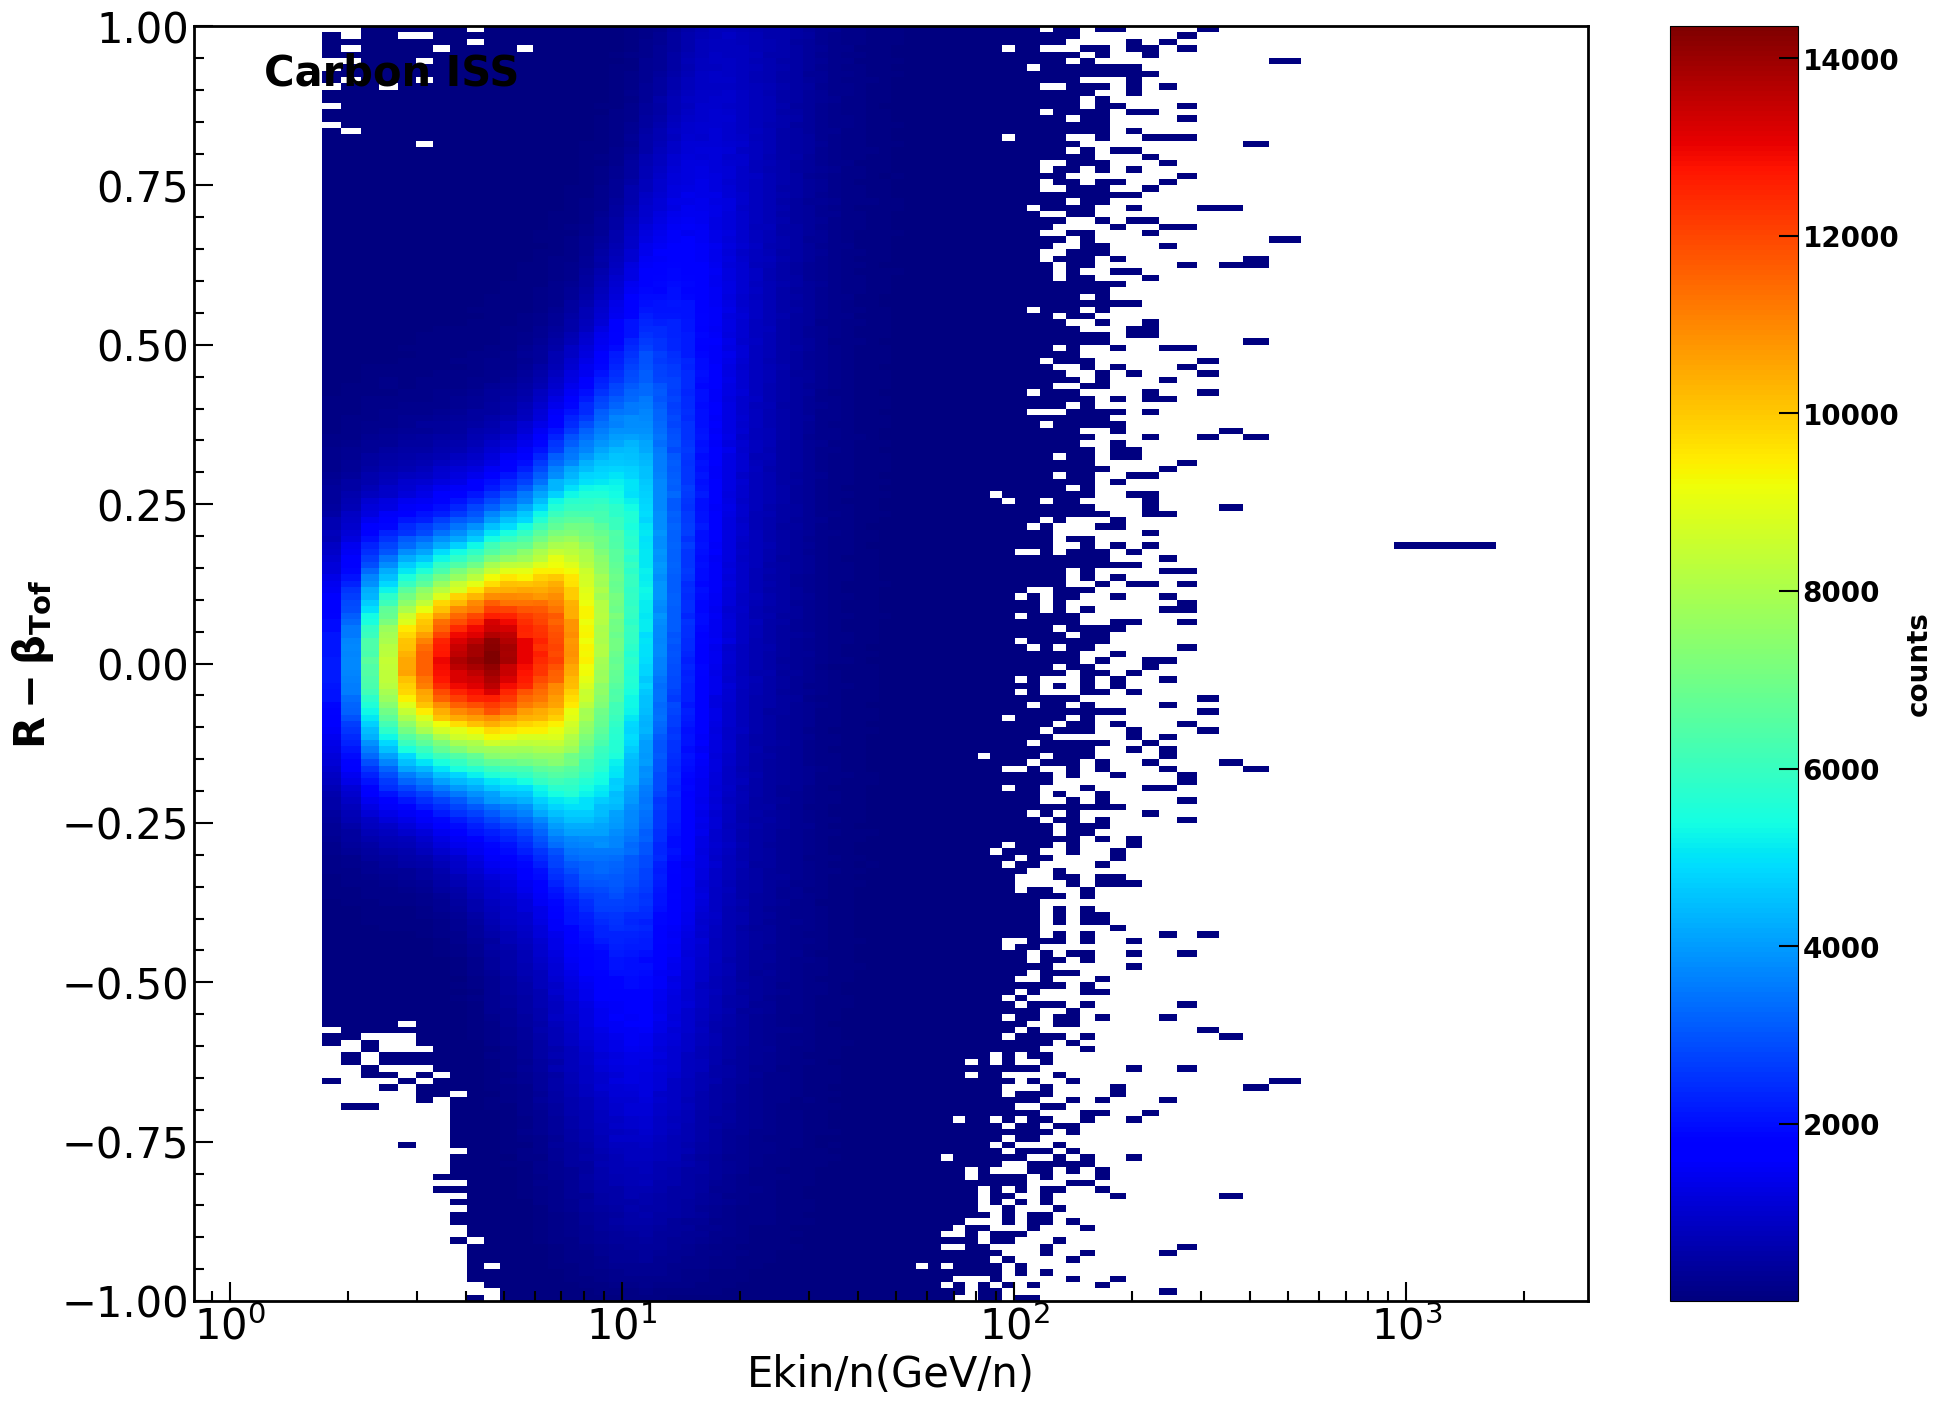

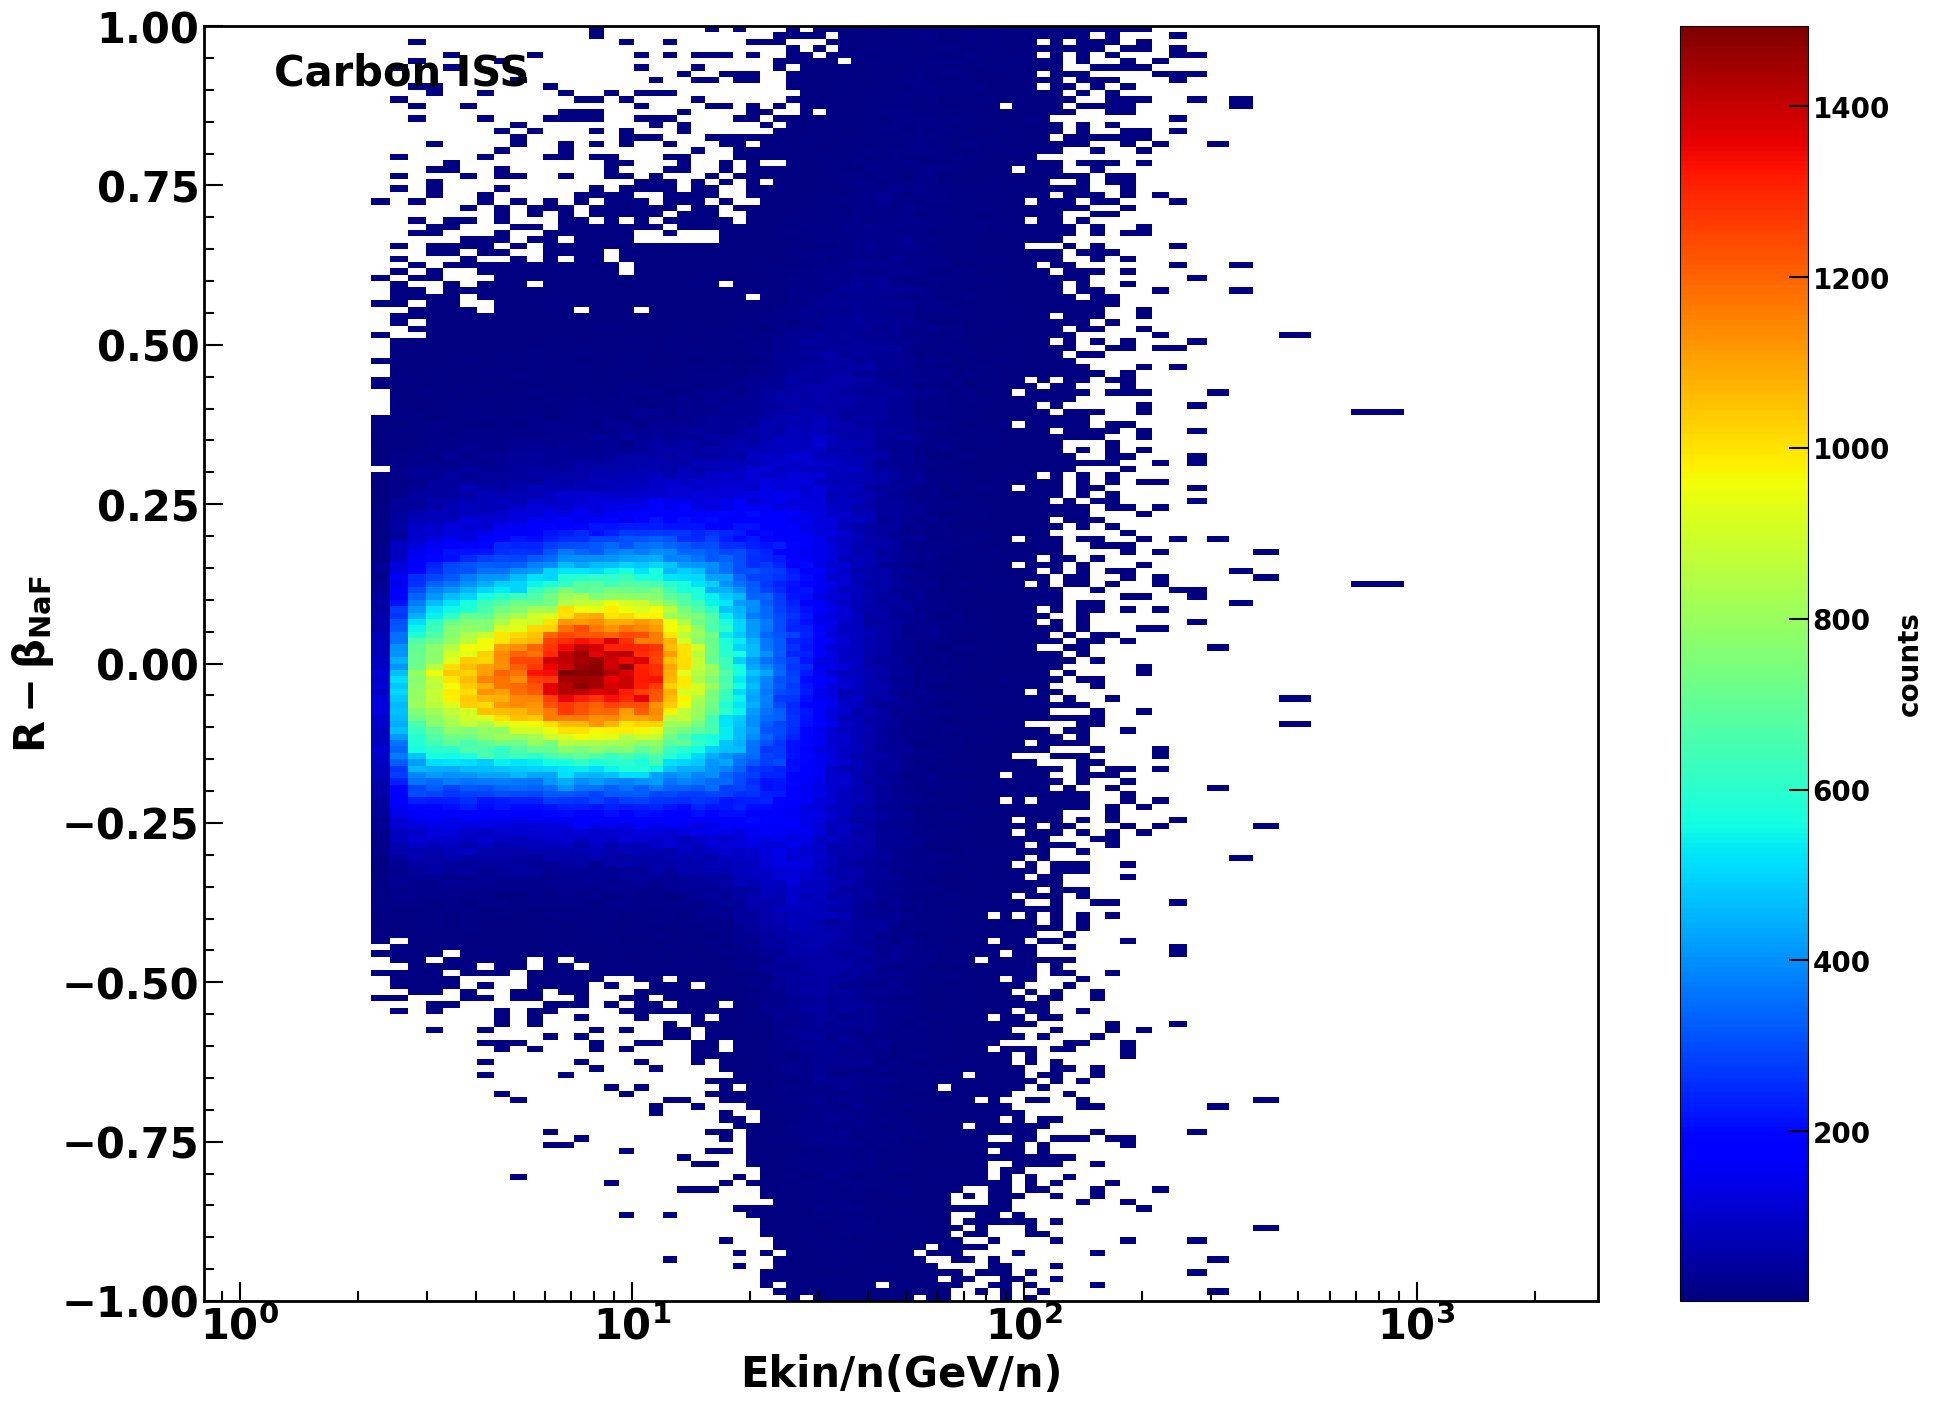

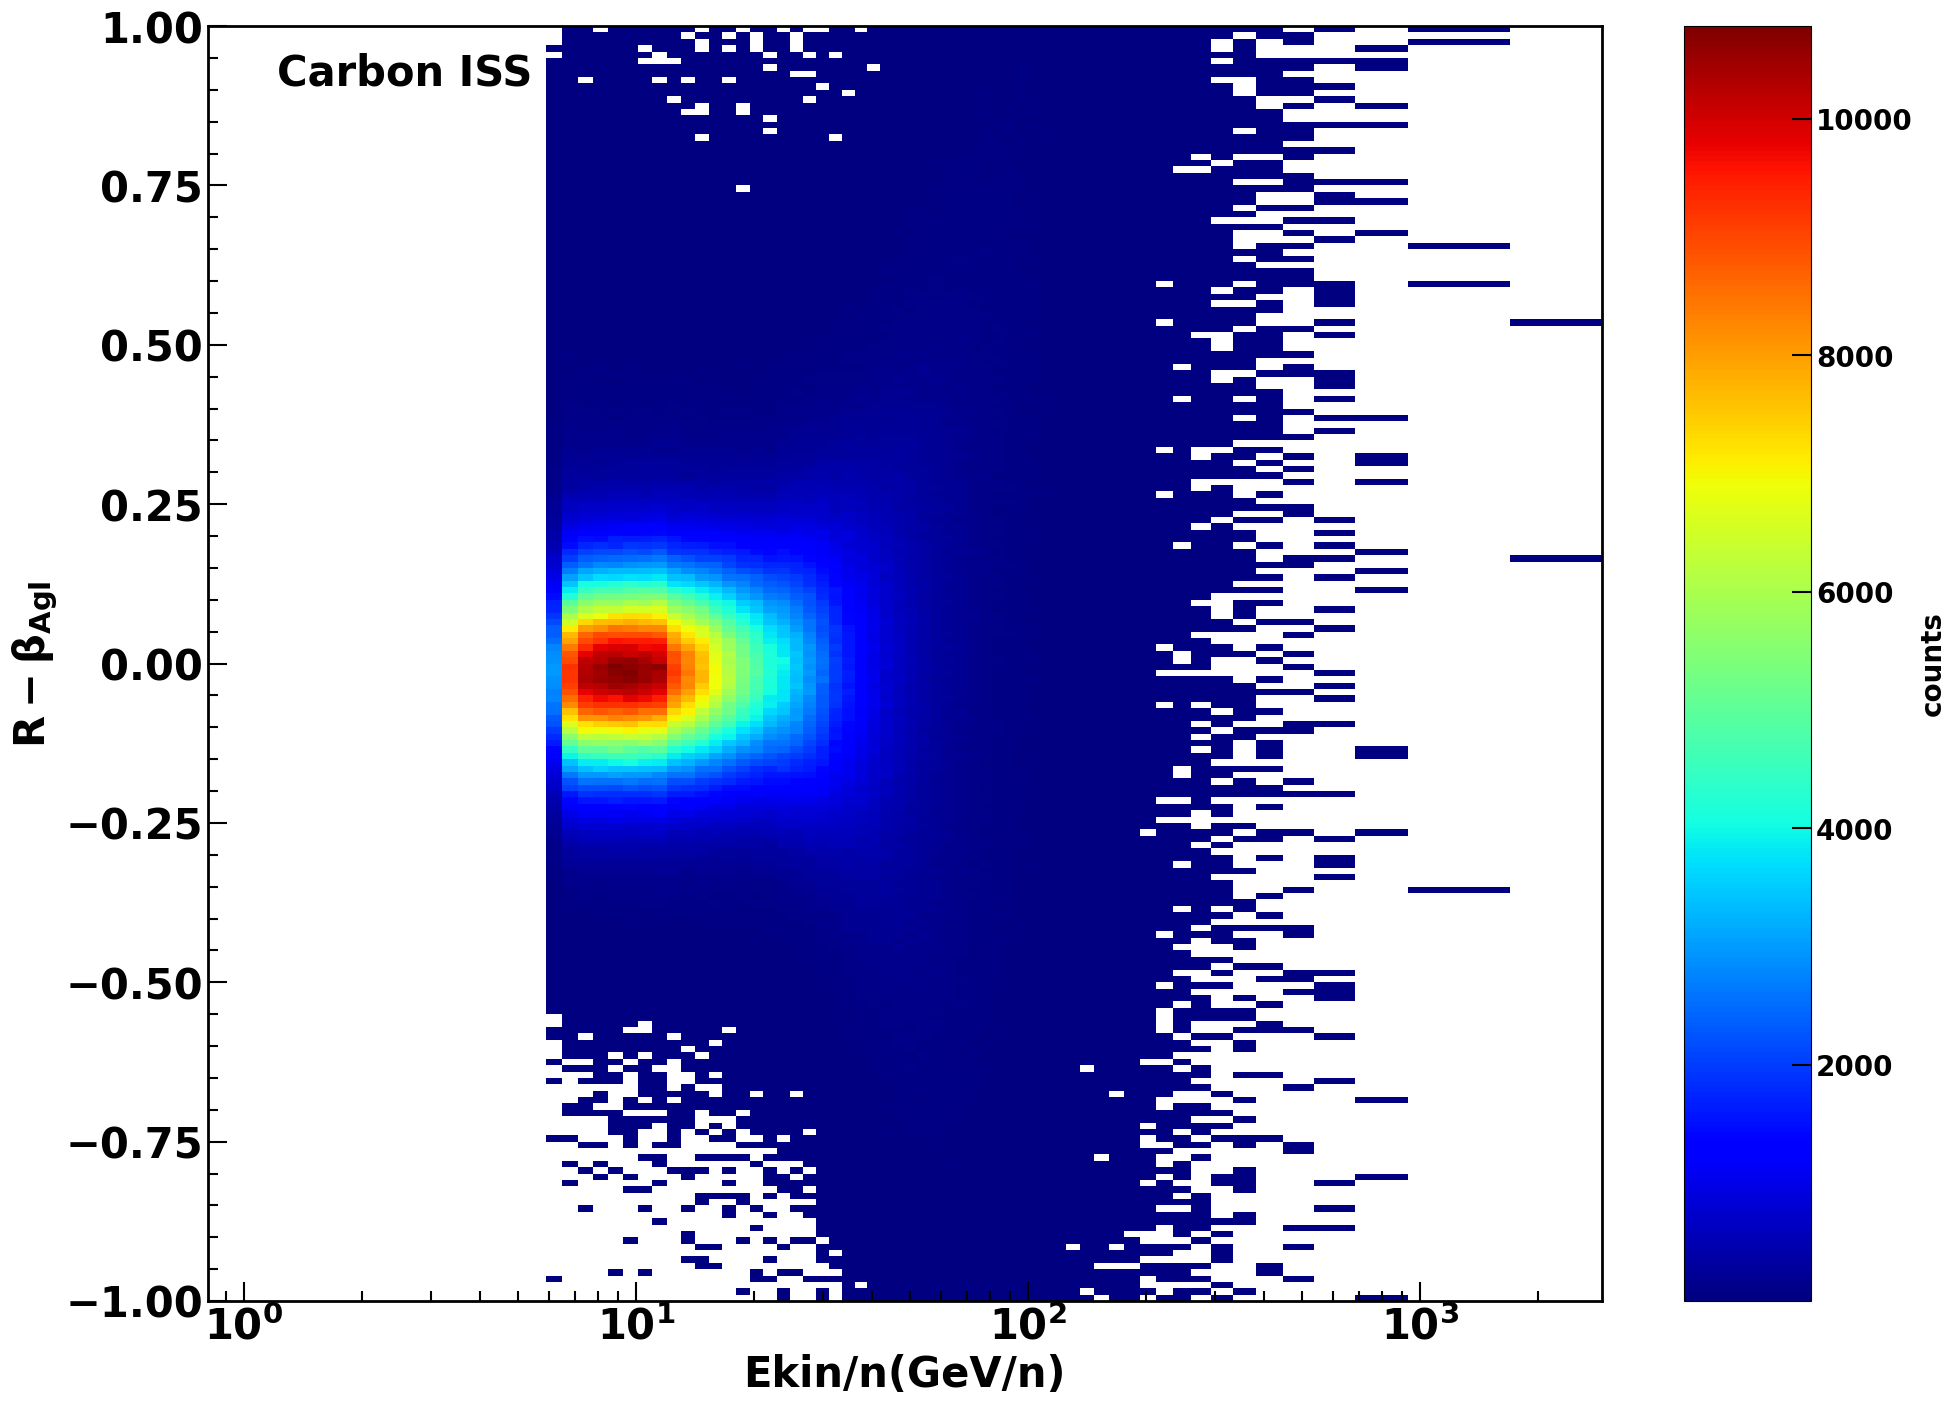

In [4]:
datatype = {'iss', 'mc'}
decs = ['Tof', 'NaF', 'Agl']

hist2d_iss = {}
hist2d_mc = {}
for dec in decs: 
    npzfile = np.load(filename_histISS)
    npzfile_mc = np.load(filename_histMC)
    hist2d_iss[dec] = Histogram.from_file(npzfile, f"{nuclei}_{dec}Opt{MCIso}_RigResoRefBeta_vsR") 
    hist2d_mc[dec] = WeightedHistogram.from_file(npzfile_mc, f"hist_rig_resolution_{dec}{MCIso}_vsR")
    #hist2d_mc[dec] = WeightedHistogram.from_file(npzfile, f"O_{dec}OptO16_RigResoRefBeta")  
    fig = plt.figure(figsize=(20, 15))
    plot = fig.subplots(1, 1) 
    plot2dhist(fig, plot, xbinning=hist2d_iss[dec].binnings[0].edges[1:-1], 
               ybinning=hist2d_iss[dec].binnings[1].edges[1:-1], 
               counts=hist2d_iss[dec].values[1:-1, 1:-1], 
               xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
               setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=False)  
    plot.text(0.05, 0.98, f"{nucleiname[nuclei]} ISS", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
    plot.set_xlabel(r"Ekin/n(GeV/n)", fontsize=30)                                                                                                                                                     
    plot.set_ylabel(rf'$\mathrm{{R-\beta_{{{dec}}}}}$', fontsize=30)
    #plot.set_ylabel(rf'$\mathrm{{ (\beta_{{tof}}-\beta_{{{dec}}})/\beta_{{{dec}}}}}$', fontsize=30)
    plot.set_xscale('log')
    #plot.set_xlim(gammalim[dec])
    savefig_tofile(fig, plotfile, f"hist2dResidual_{figsuffix}_Compare_iss_{nucleiname[nuclei]}{dec}", show=True) 
    
    
    

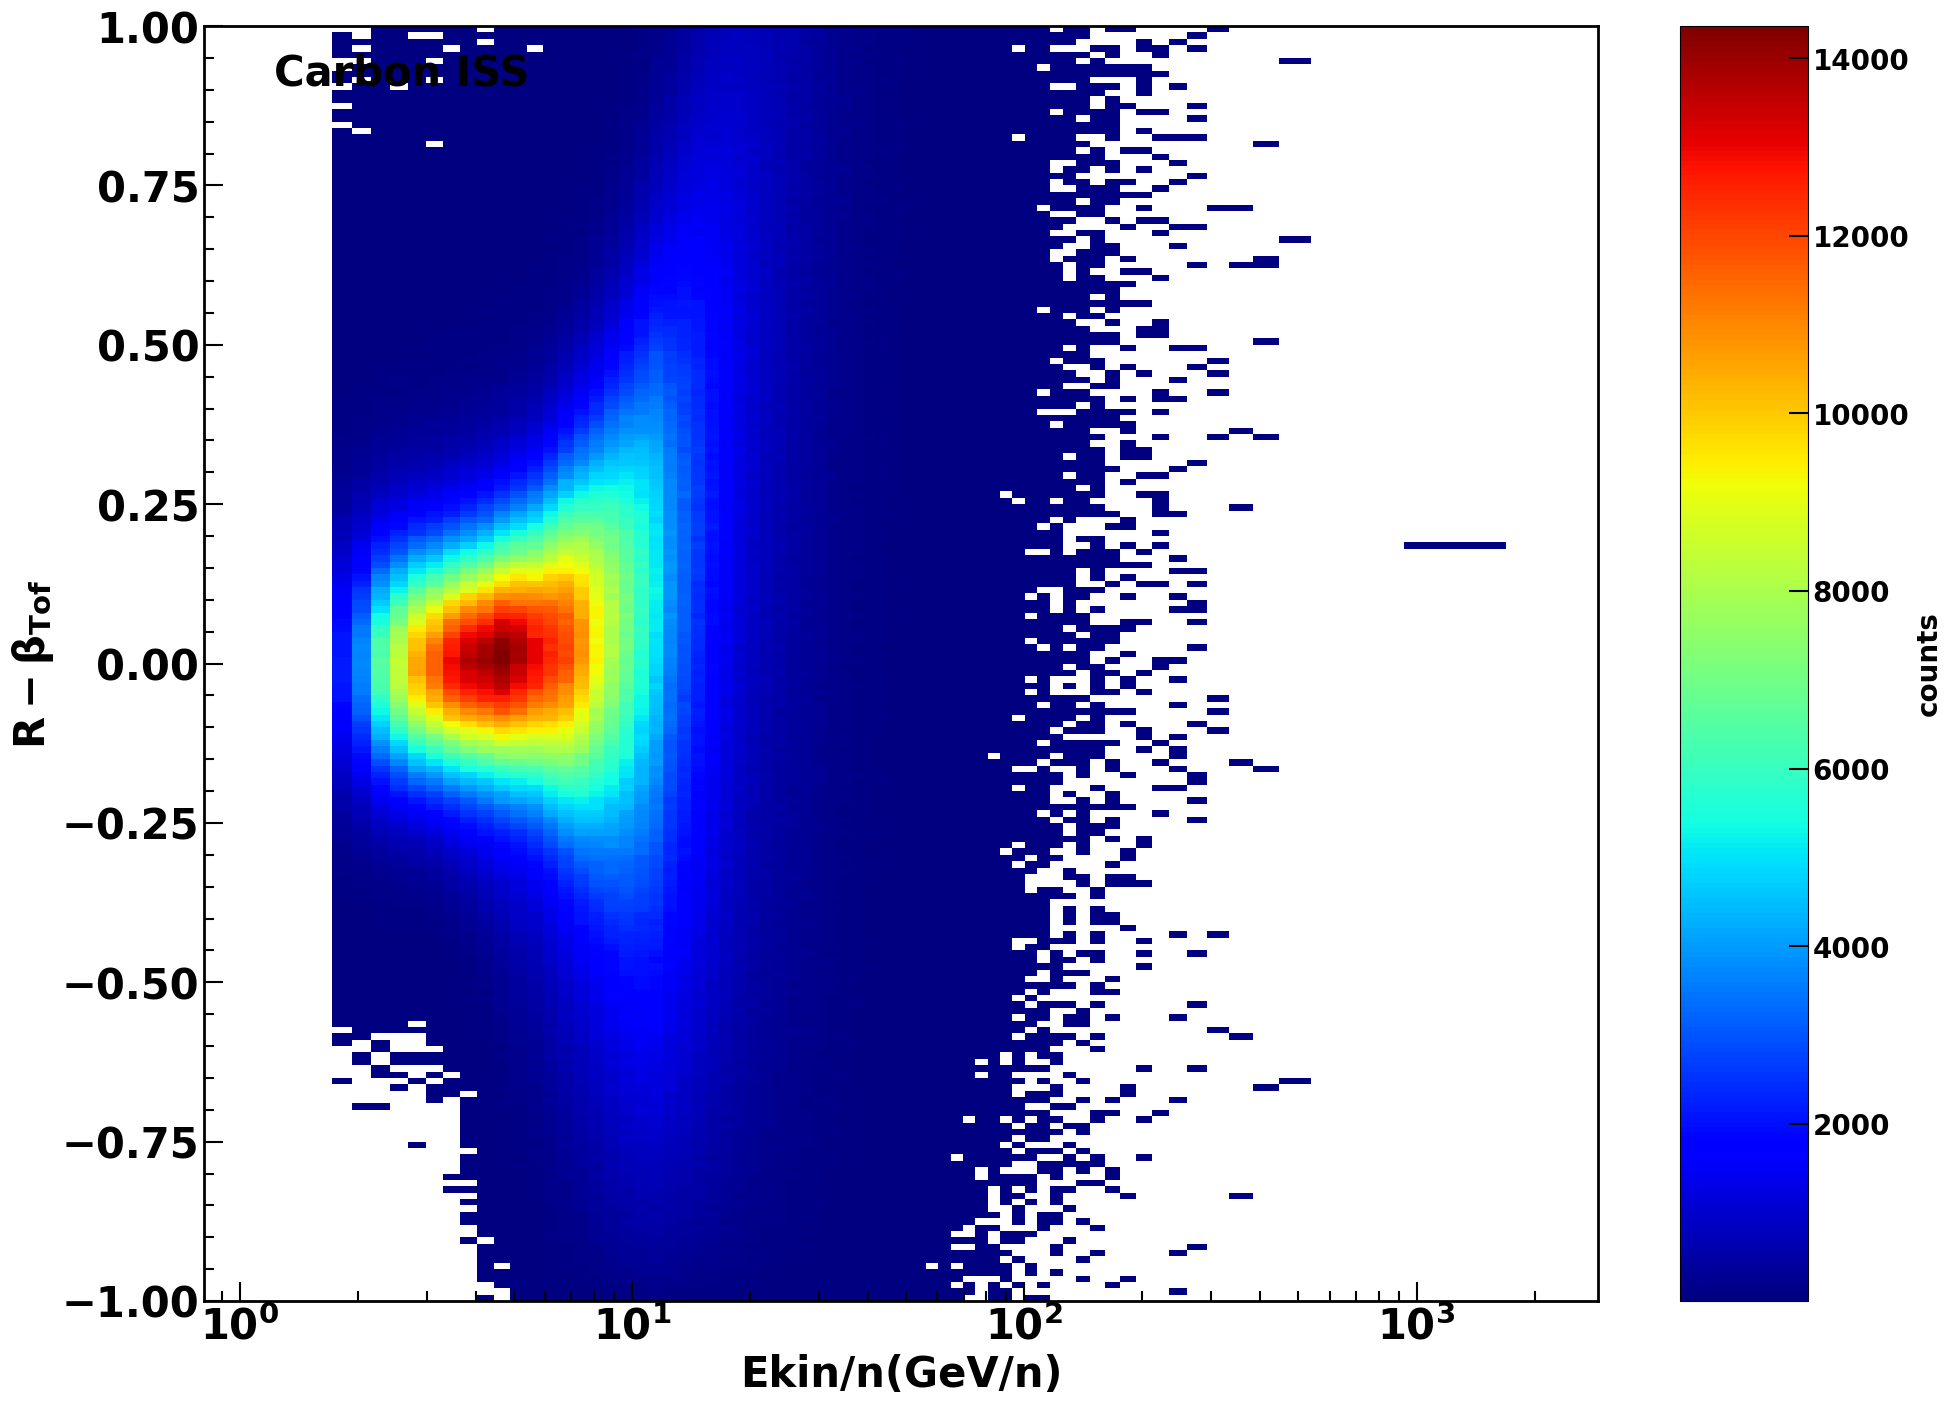

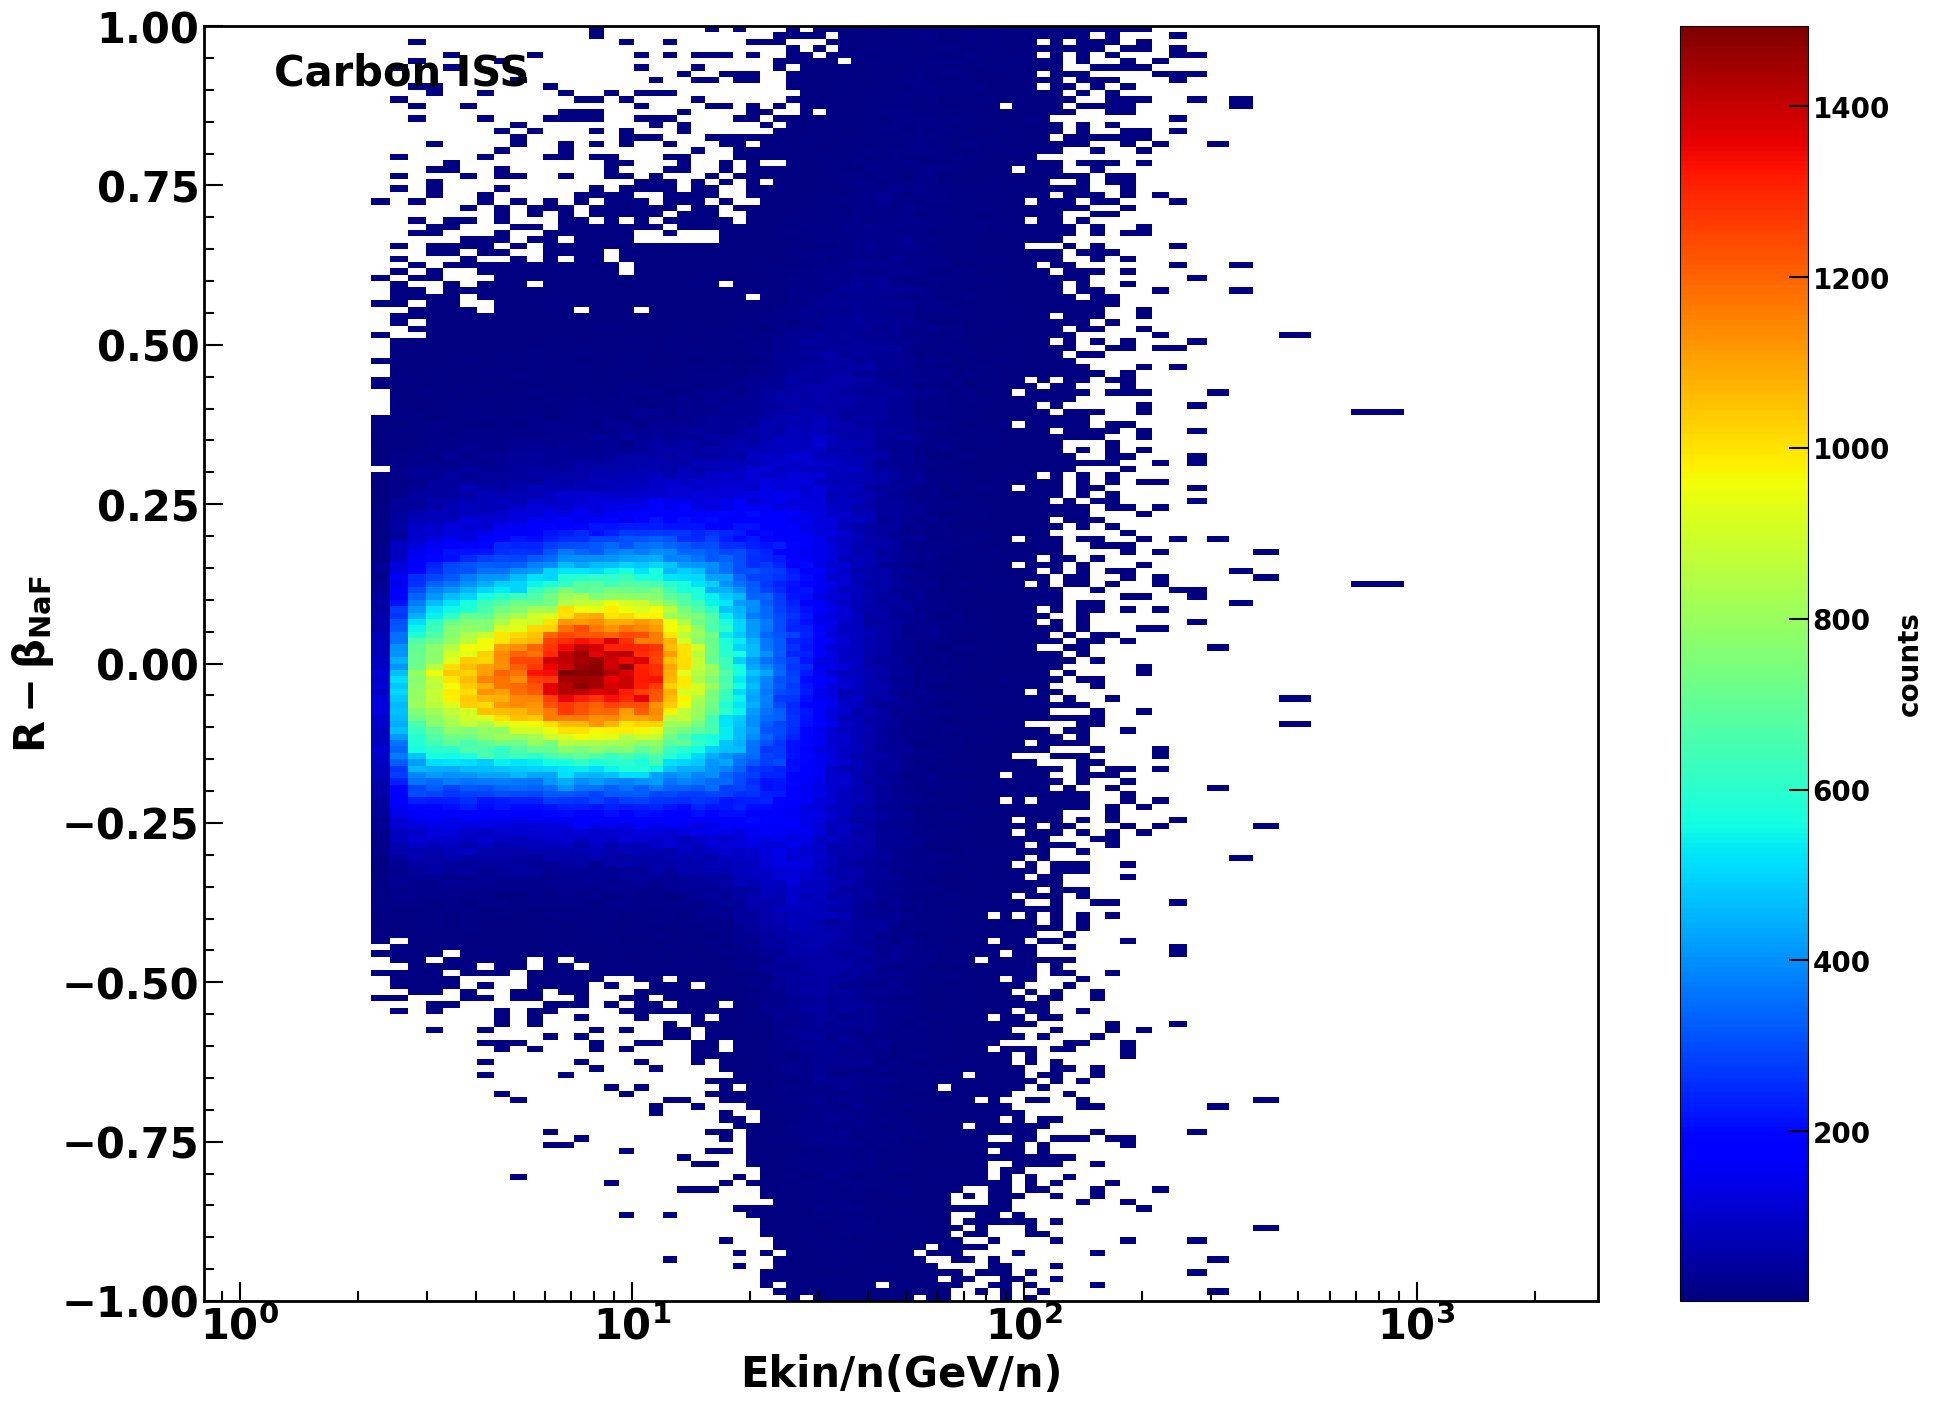

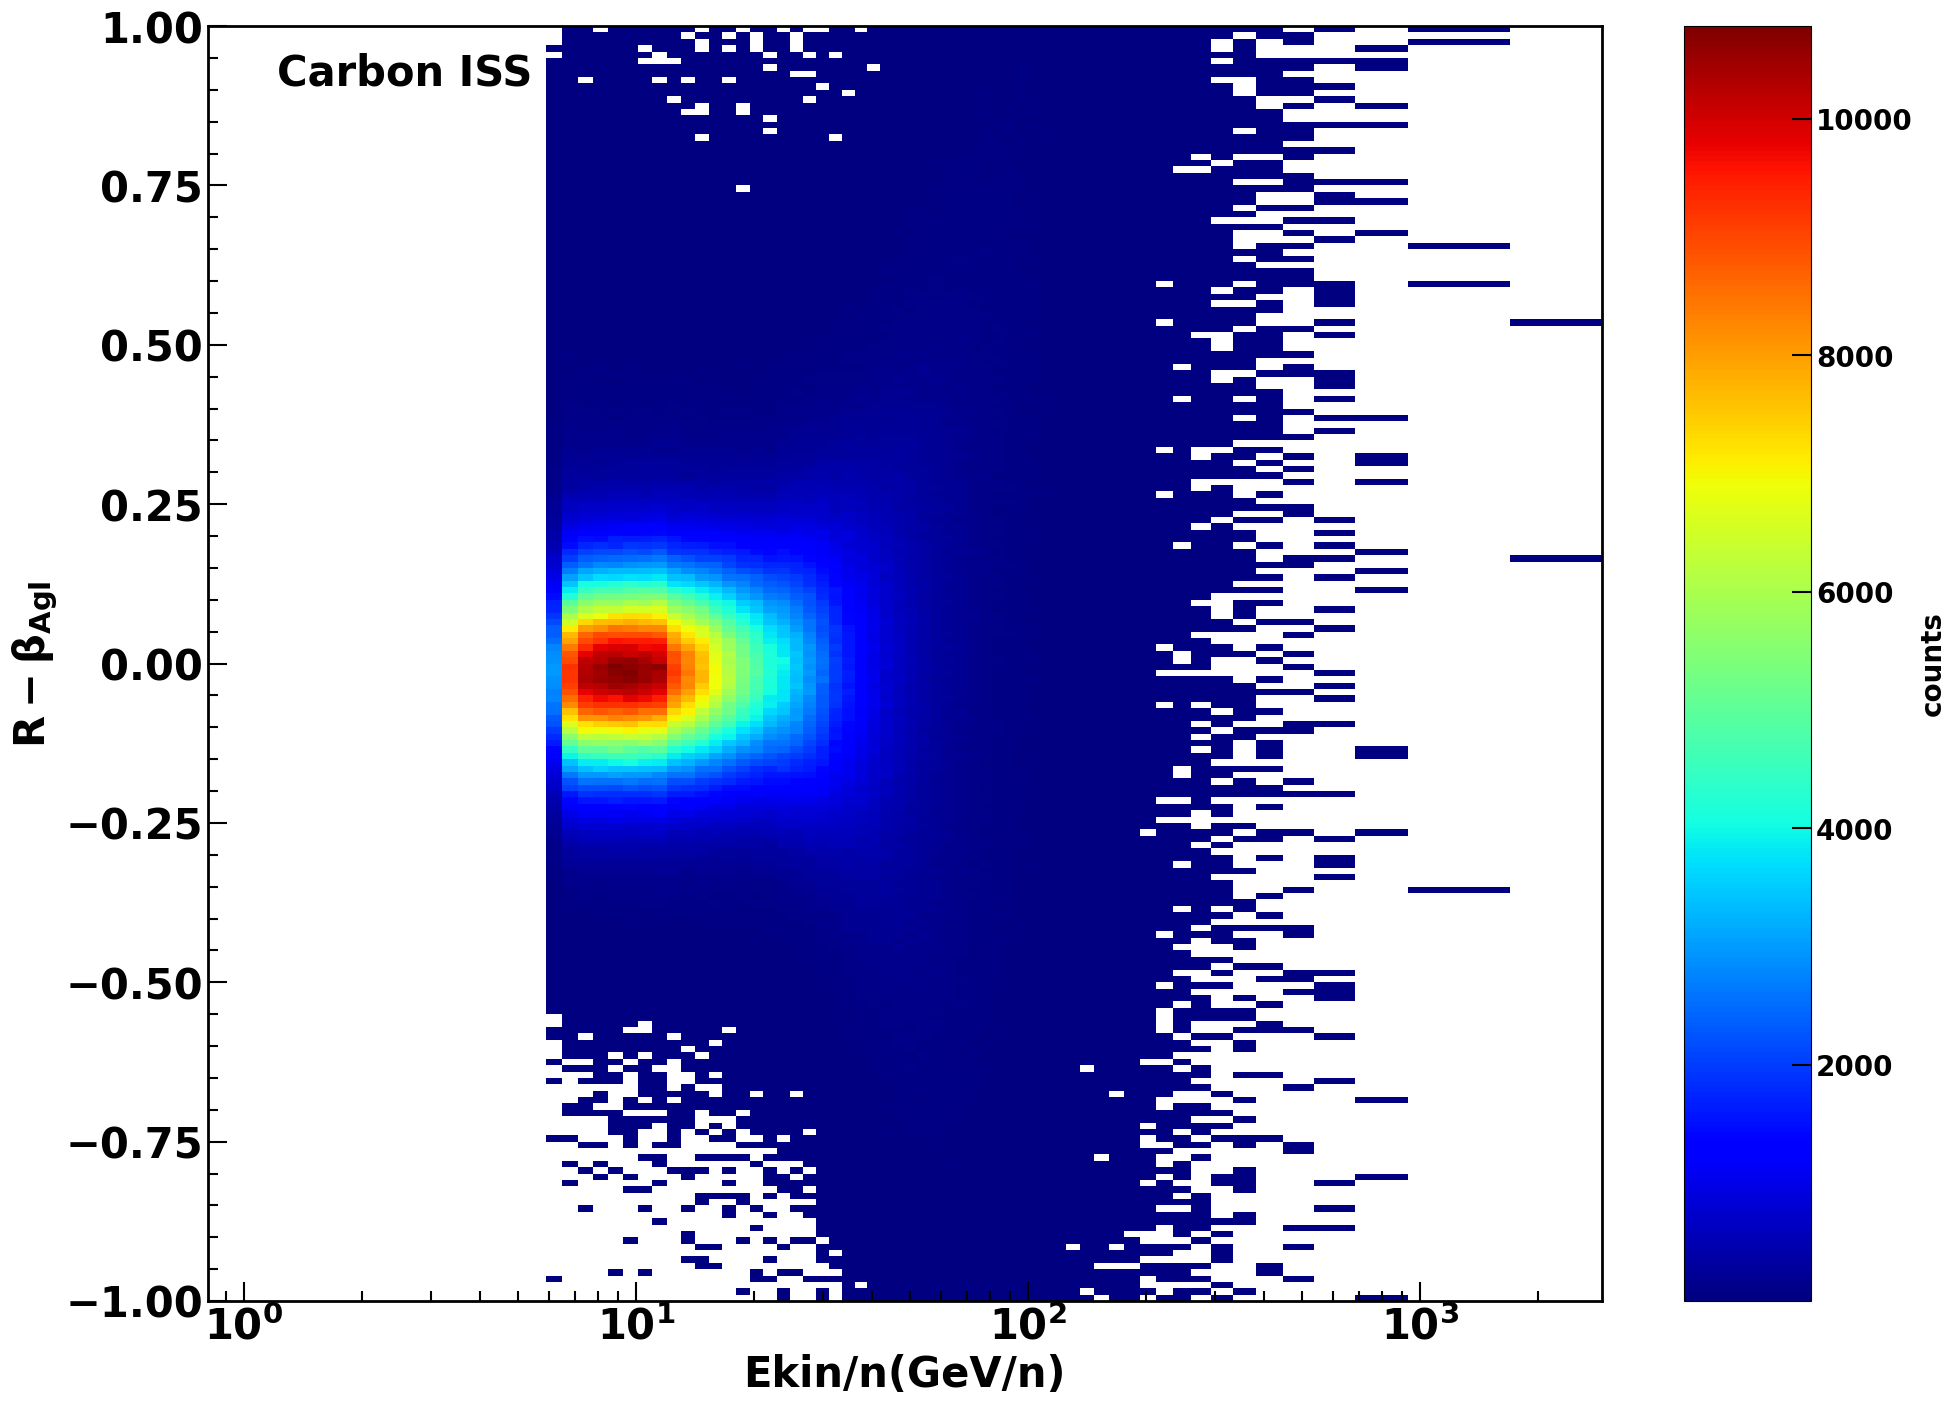

In [5]:
datatype = {'iss', 'mc'}

hist2d_iss = {}
hist2d_mc = {}
for dec in detectors: 
    npzfile = np.load(filename_histISS)
    npzfile_mc = np.load(filename_histMC)
    hist2d_iss[dec] = Histogram.from_file(npzfile, f"{nuclei}_{dec}Opt{MCIso}_RigResoRefBeta_vsR") 
    hist2d_mc[dec] = WeightedHistogram.from_file(npzfile_mc, f"hist_rig_resolution_{dec}{MCIso}_vsR")
    #hist2d_mc[dec] = WeightedHistogram.from_file(npzfile, f"O_{dec}OptO16_RigResoRefBeta")  
    fig = plt.figure(figsize=(20, 15))
    plot = fig.subplots(1, 1) 
    plot2dhist(fig, plot, xbinning=hist2d_iss[dec].binnings[0].edges[1:-1], 
               ybinning=hist2d_iss[dec].binnings[1].edges[1:-1], 
               counts=hist2d_iss[dec].values[1:-1, 1:-1], 
               xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
               setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=False)  
    plot.text(0.05, 0.98, f"{nucleiname[nuclei]} ISS", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
    plot.set_xlabel(r"Ekin/n(GeV/n)", fontsize=30)                                                                                                                                                     
    plot.set_ylabel(rf'$\mathrm{{R-\beta_{{{dec}}}}}$', fontsize=30)
    #plot.set_ylabel(rf'$\mathrm{{ (\beta_{{tof}}-\beta_{{{dec}}})/\beta_{{{dec}}}}}$', fontsize=30)
    plot.set_xscale('log')
    #plot.set_xlim(gammalim[dec])
    savefig_tofile(fig, plotfile, f"hist2dResidual_{figsuffix}_Compare_iss_{nucleiname}{dec}", show=True) 
    
    
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


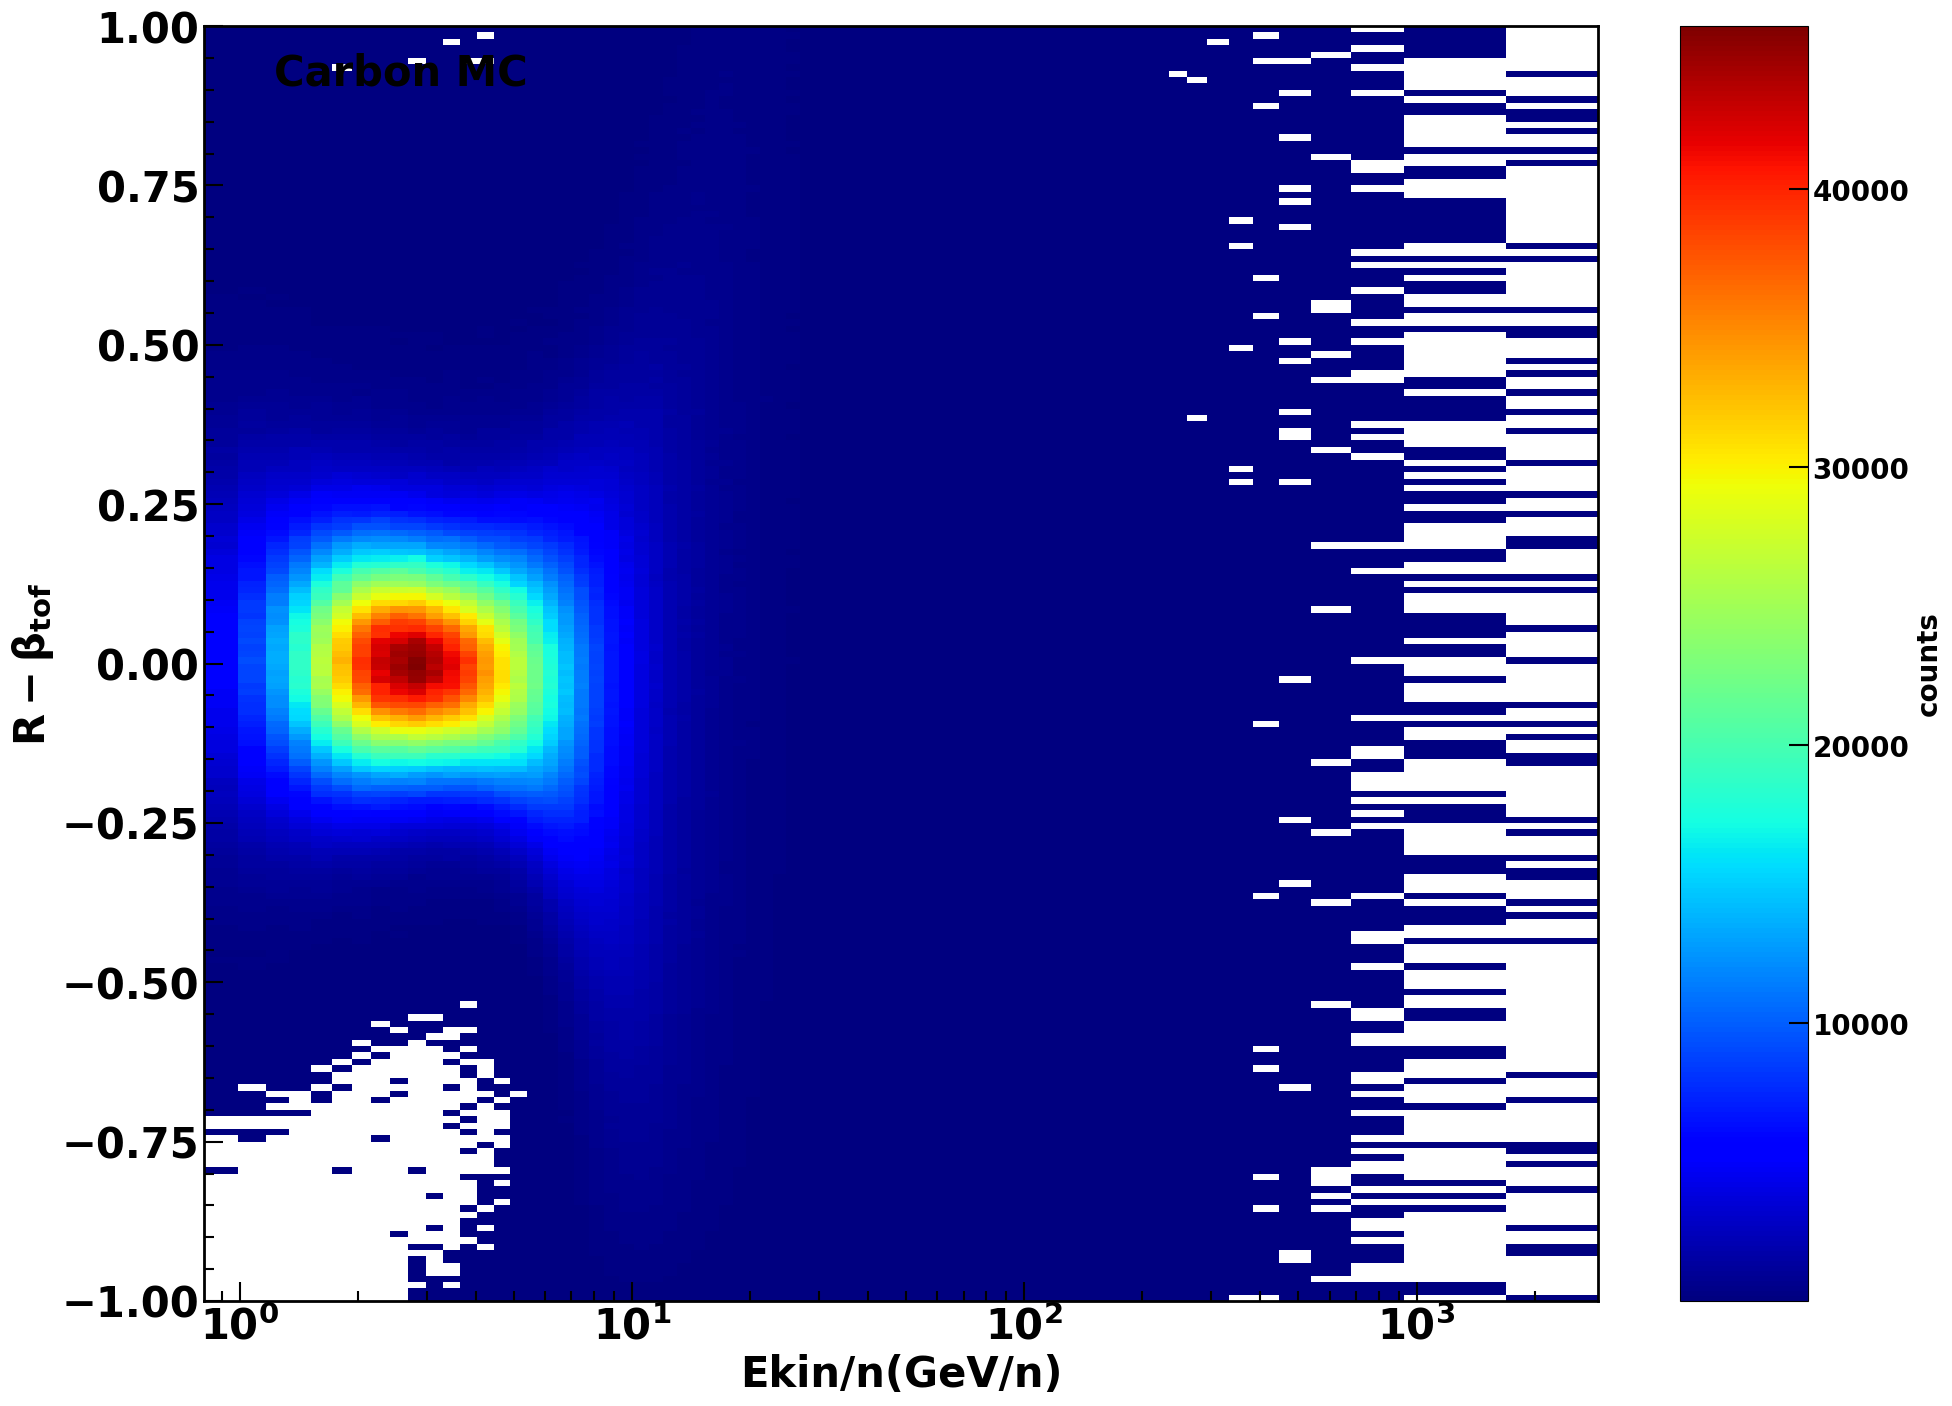

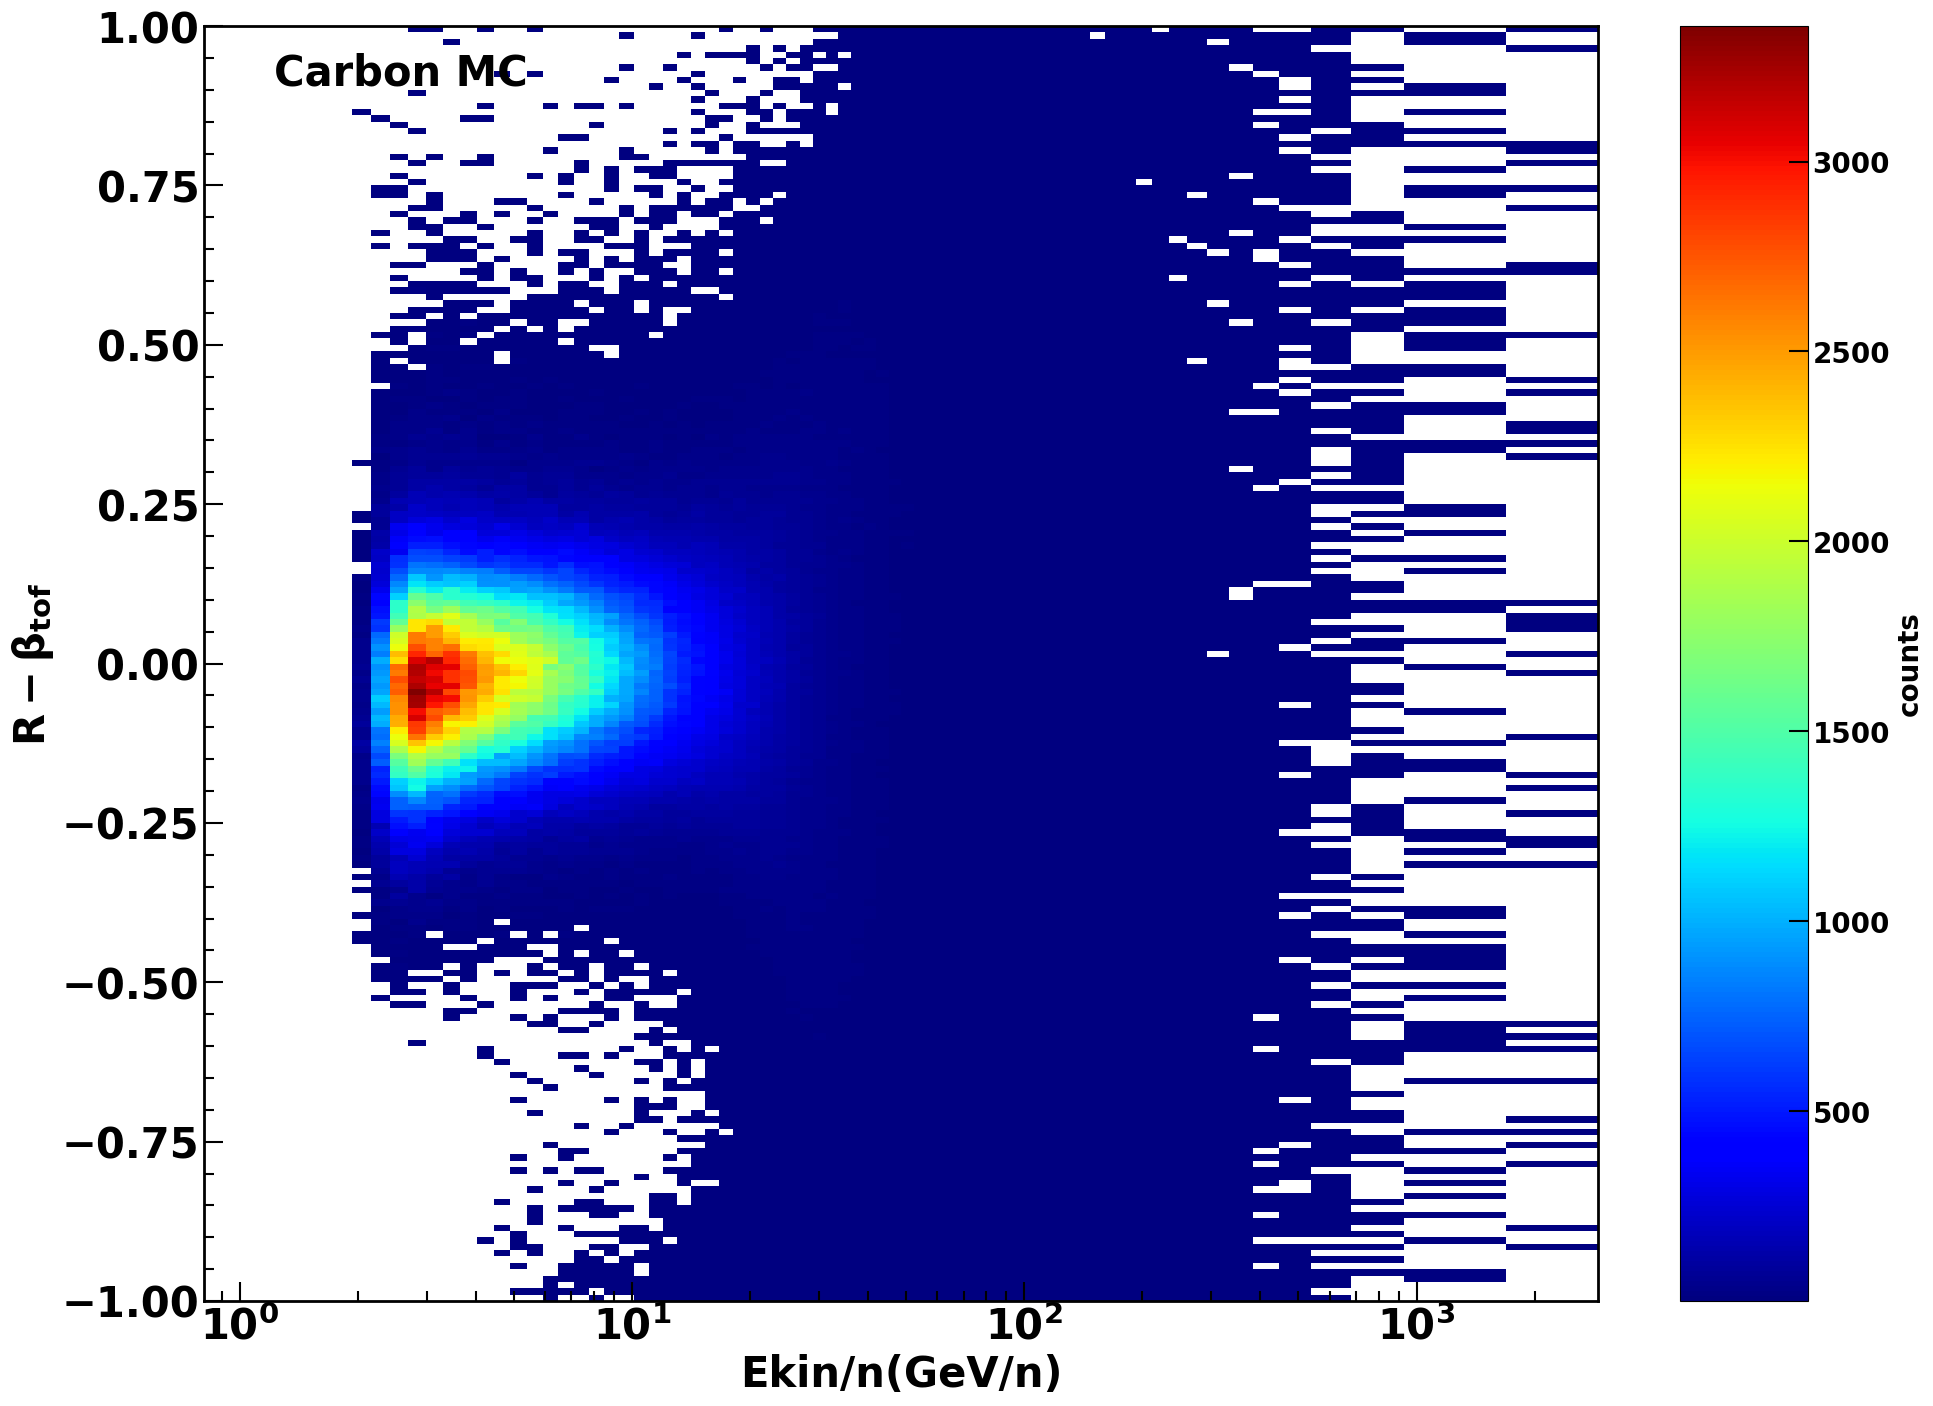

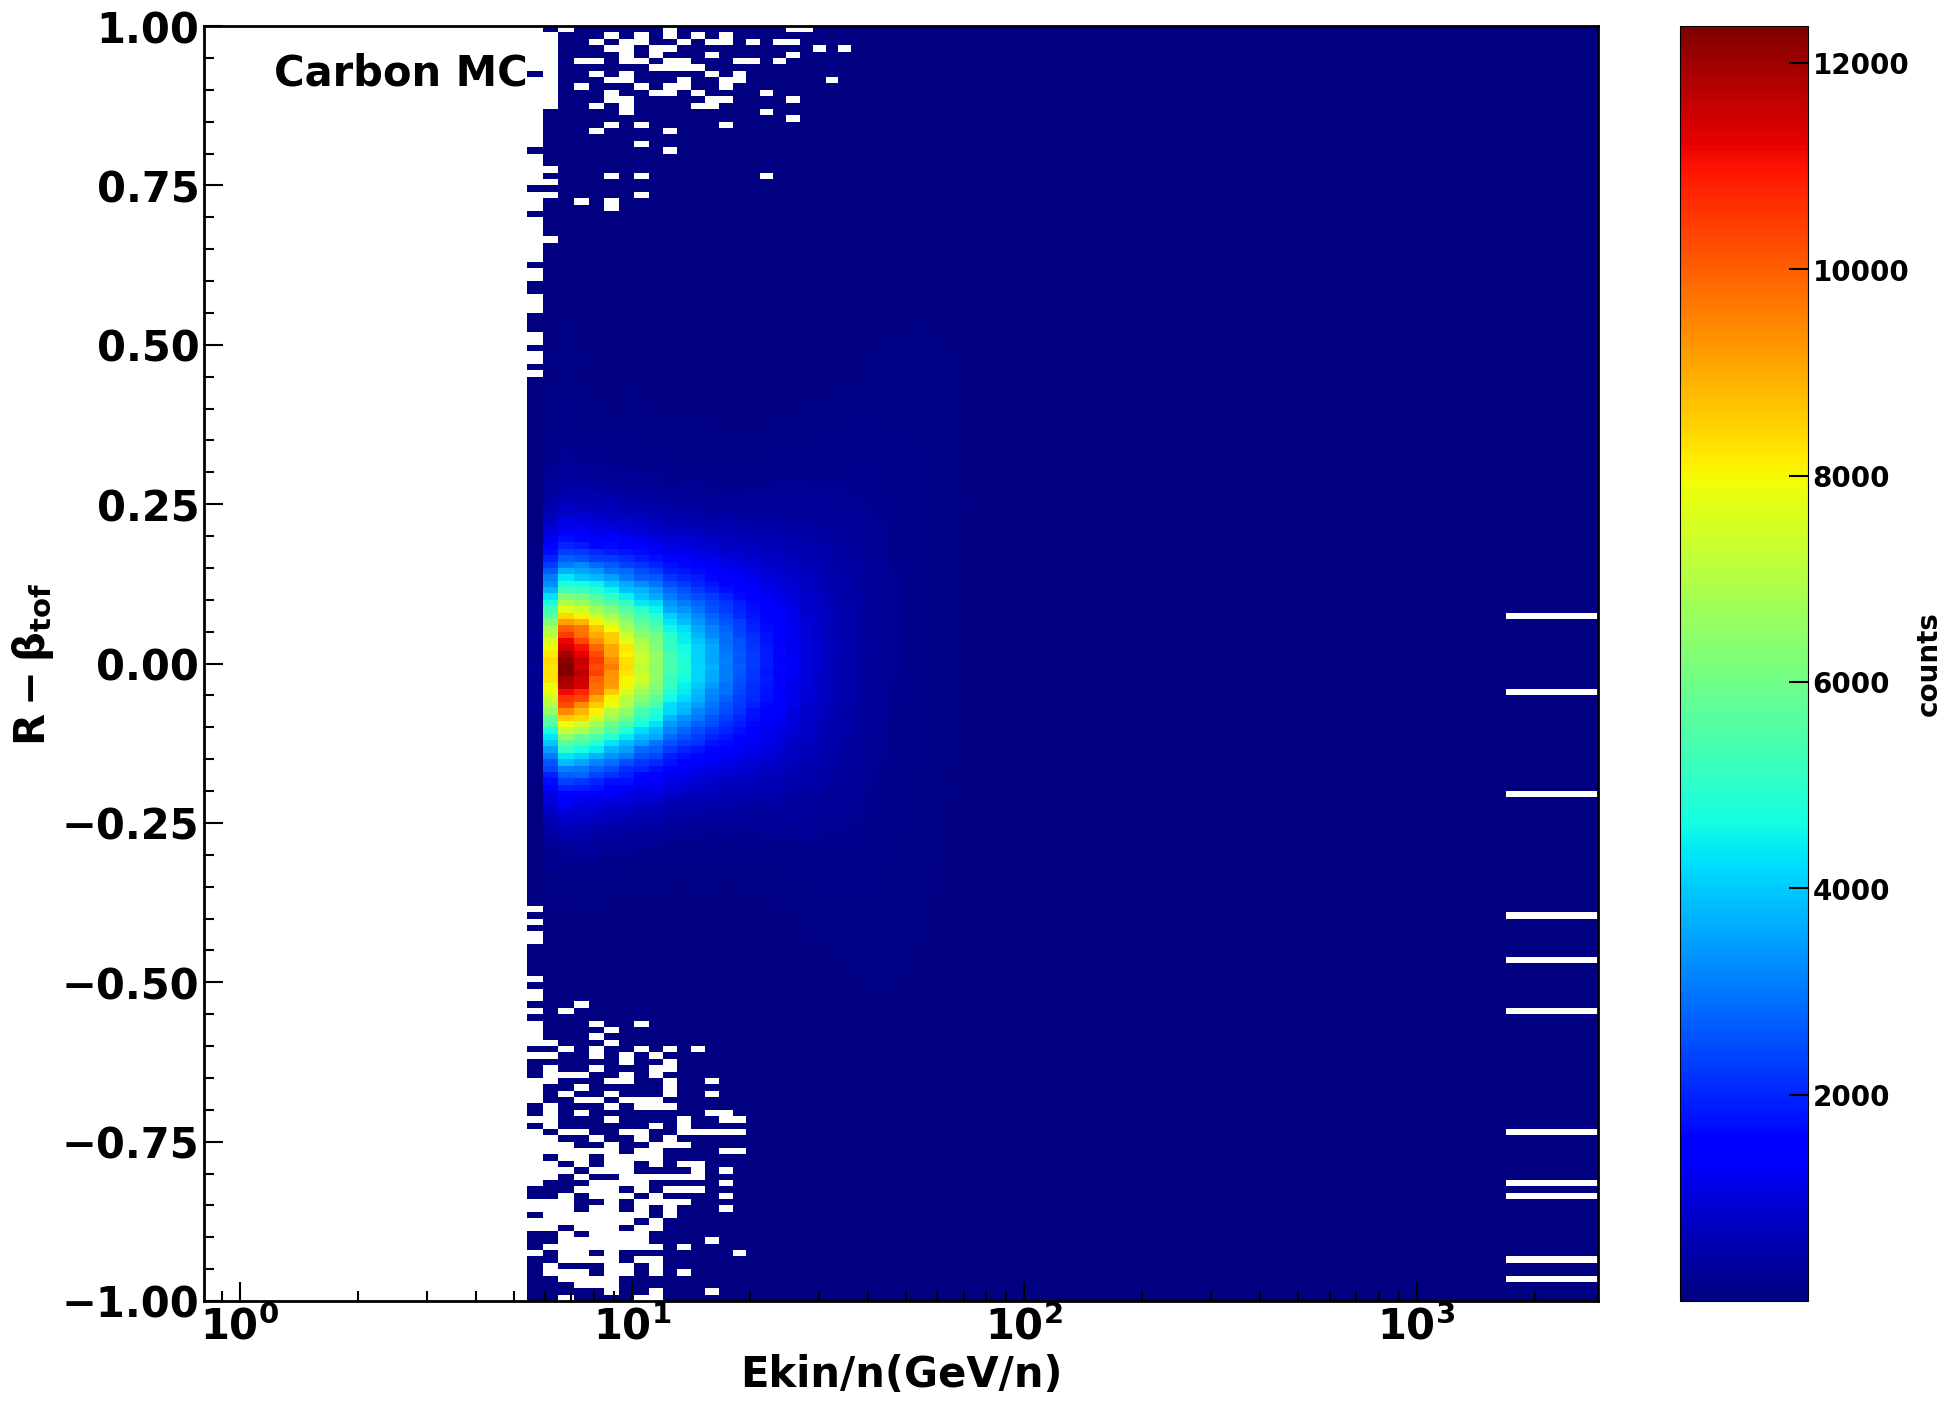

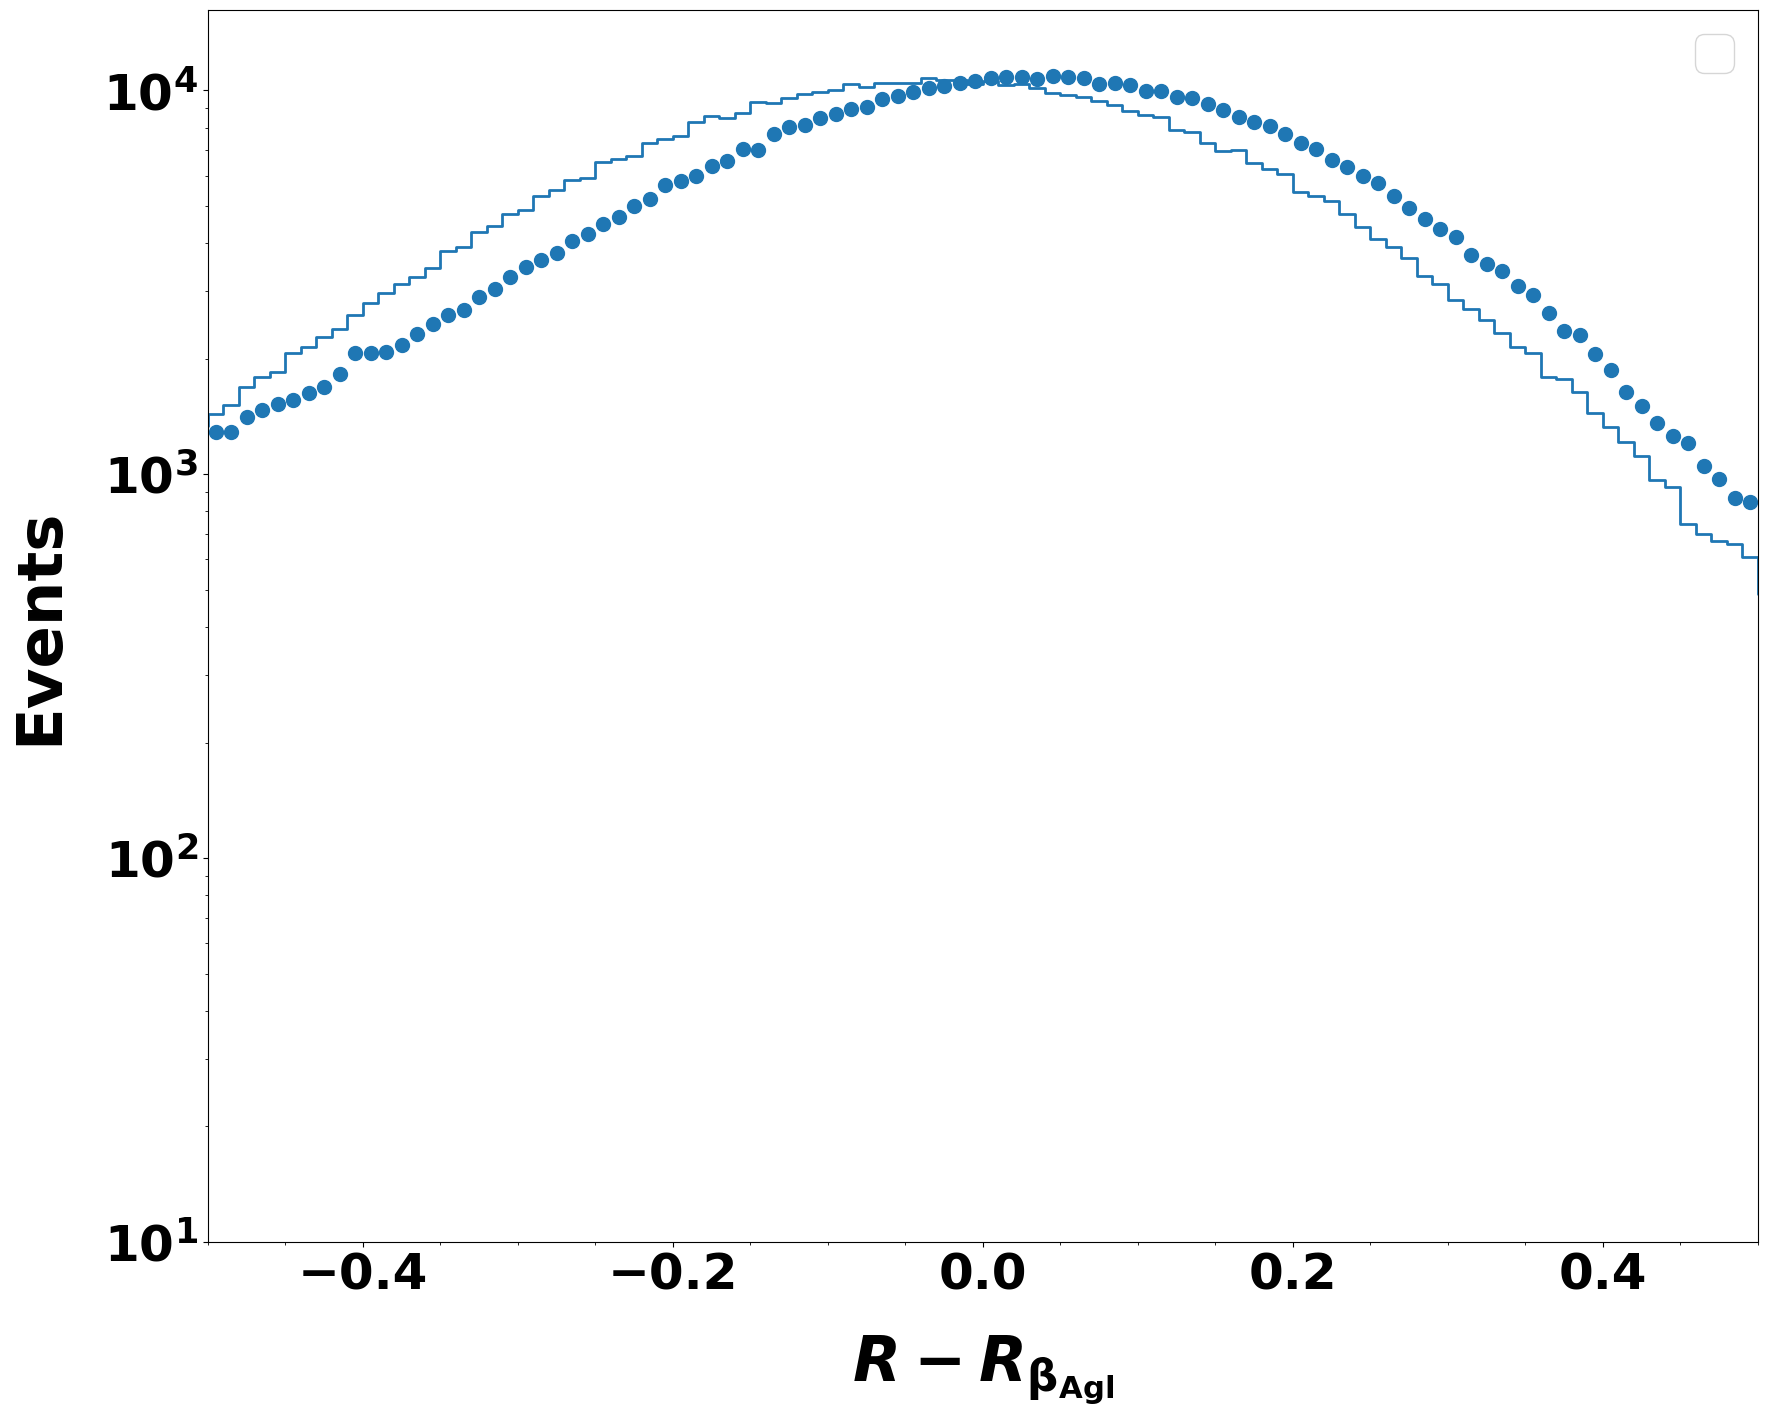

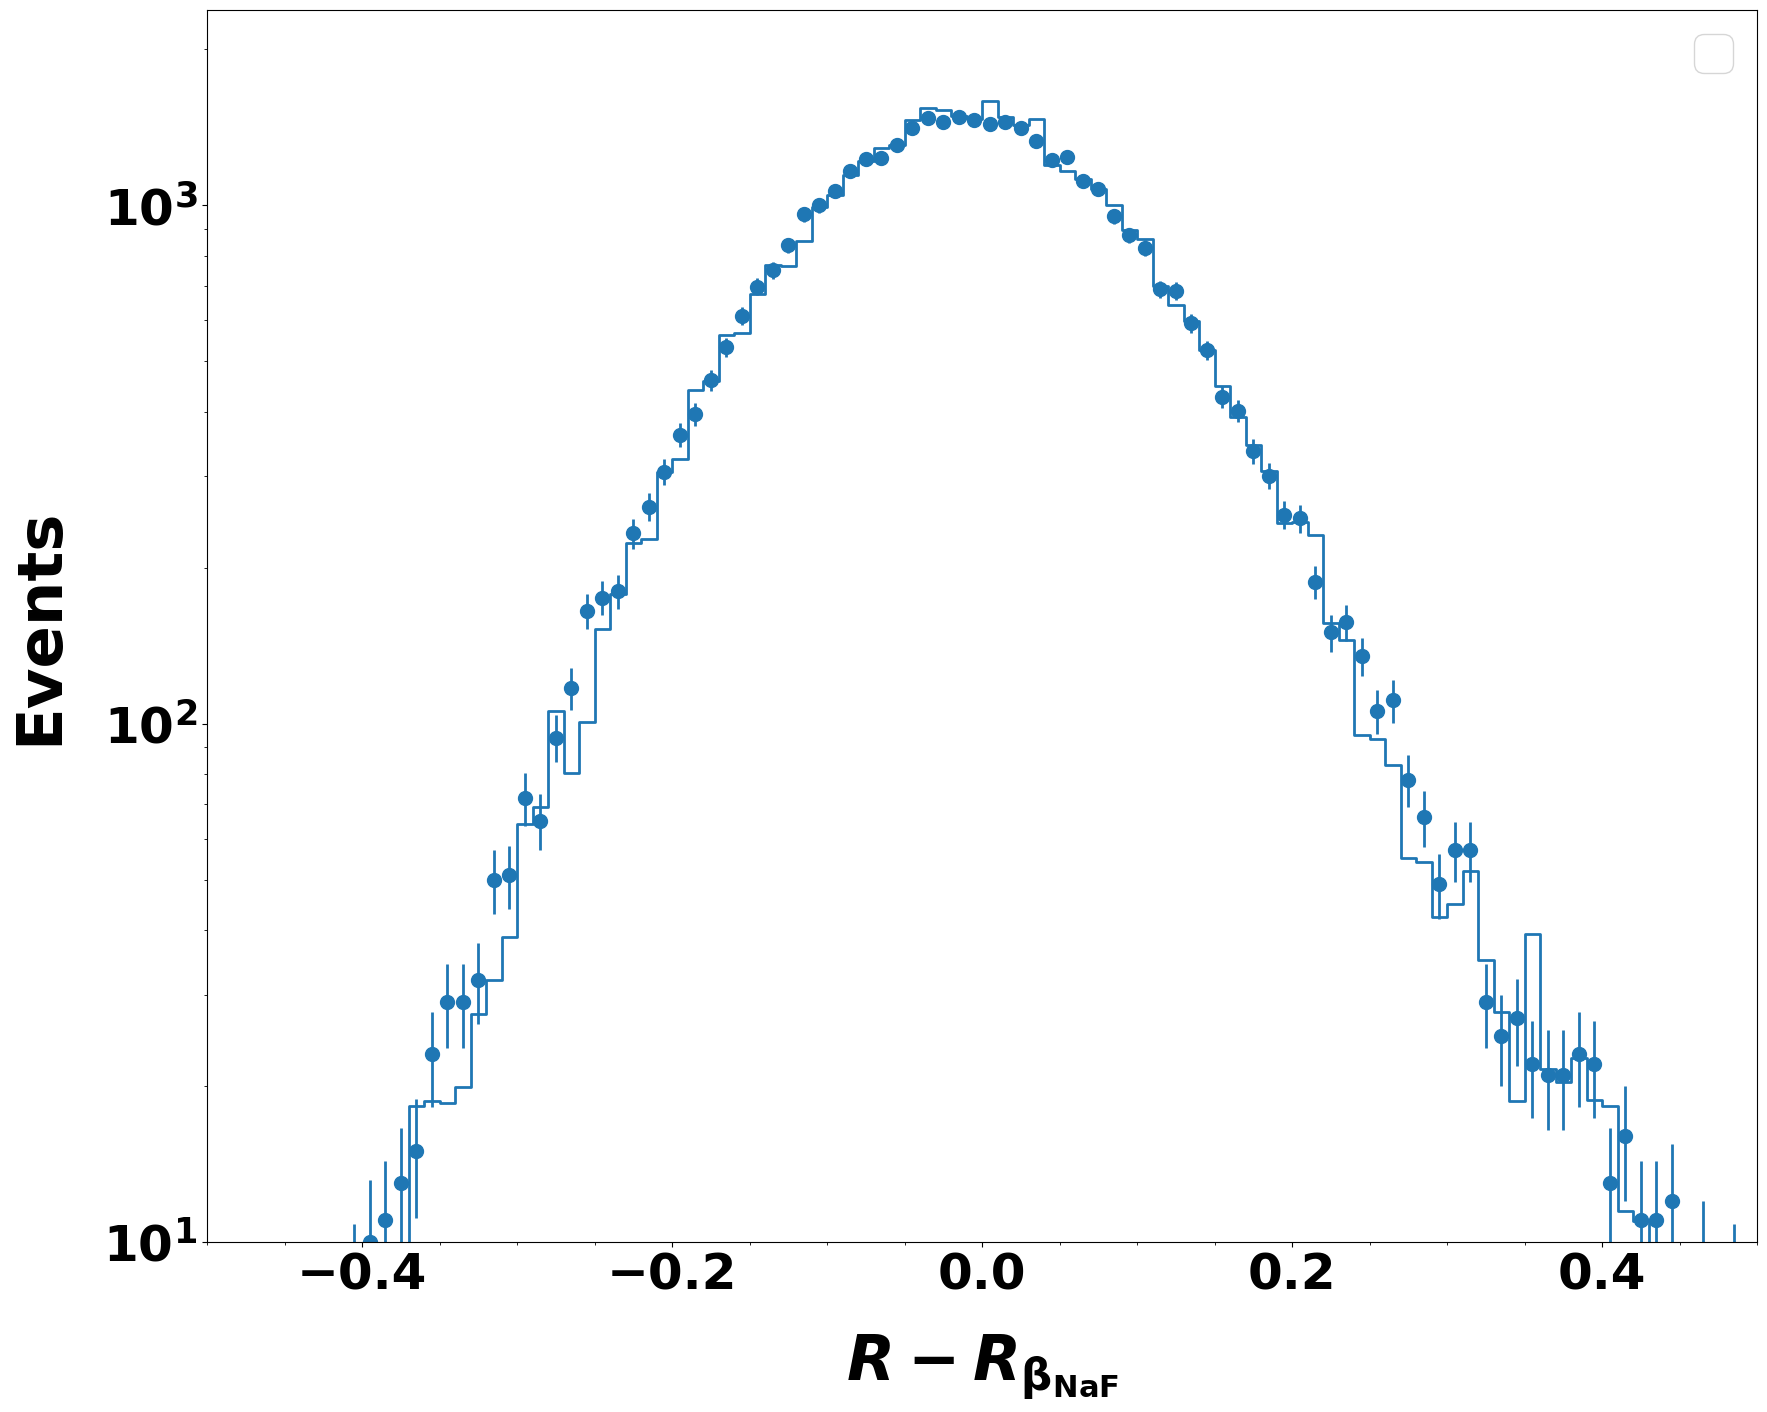

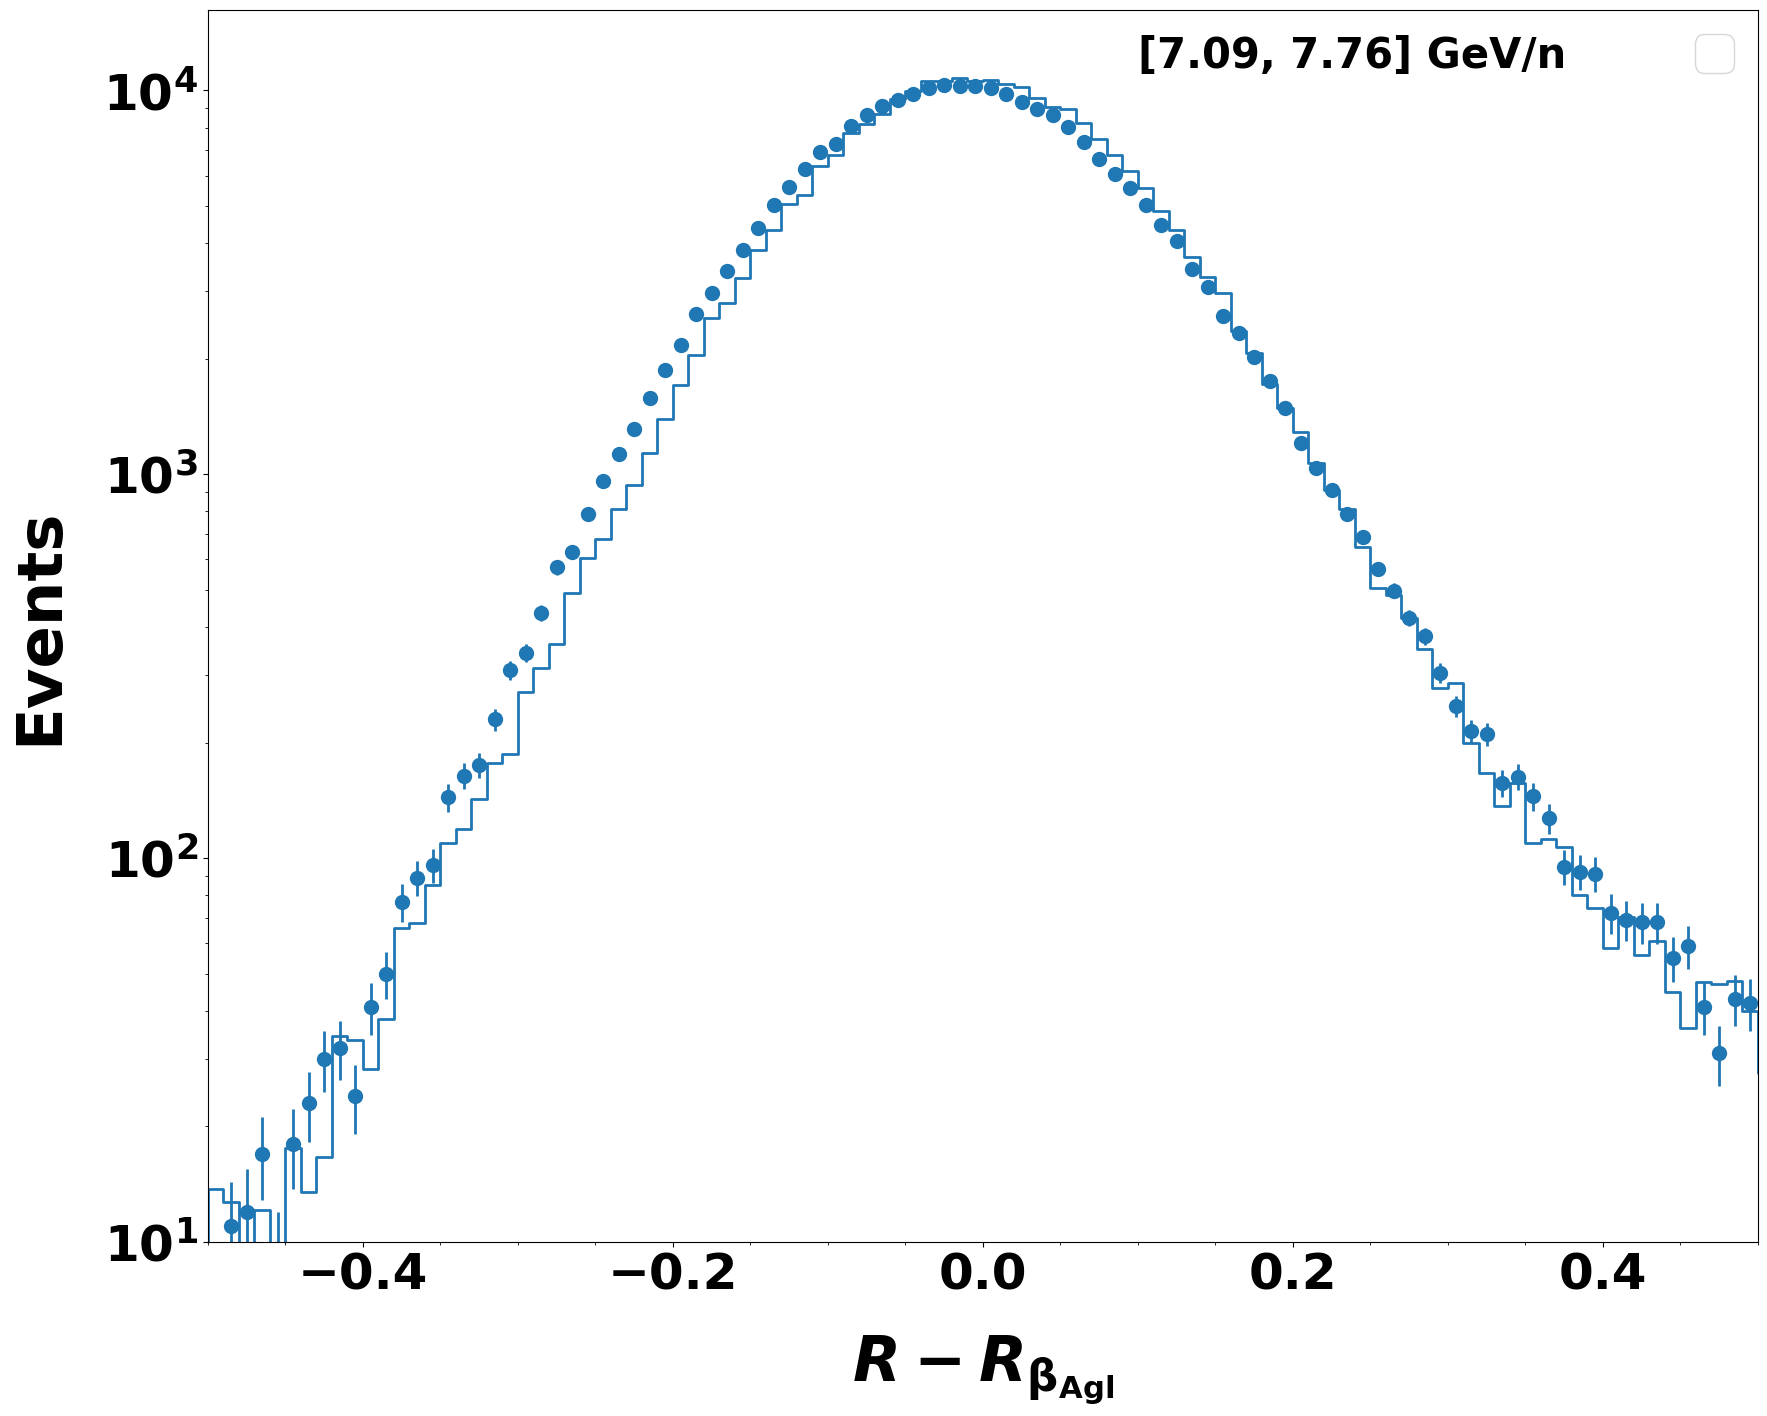

In [6]:
datatype = {'iss', 'mc'}

hist2d_iss = {}
hist2d_mc = {}
for dec in detectors: 
    npzfile = np.load(filename_histISS)
    npzfile_mc = np.load(filename_histMC)
    hist2d_iss[dec] = Histogram.from_file(npzfile, f"{nuclei}_{dec}Opt{MCIso}_RigResoRefBeta_vsR") 
    hist2d_mc[dec] = WeightedHistogram.from_file(npzfile_mc, f"hist_rig_resolution_{dec}{MCIso}_vsR")
    #hist2d_mc[dec] = WeightedHistogram.from_file(npzfile, f"O_{dec}OptO16_RigResoRefBeta")  
    fig = plt.figure(figsize=(20, 15))
    plot = fig.subplots(1, 1) 
    plot2dhist(fig, plot, xbinning=hist2d_mc[dec].binnings[0].edges[1:-1], 
               ybinning=hist2d_mc[dec].binnings[1].edges[1:-1], 
               counts=hist2d_mc[dec].values[1:-1, 1:-1], 
               xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
               setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=False)  
    plot.text(0.05, 0.98, f"{nucleiname[nuclei]} MC", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
    plot.set_xlabel(r"Ekin/n(GeV/n)", fontsize=30)                                                                                                                                                     
    plot.set_ylabel(rf'$\mathrm{{R-\beta_{{tof}}}}$', fontsize=30)
    #plot.set_ylabel(rf'$\mathrm{{ (\beta_{{tof}}-\beta_{{{dec}}})/\beta_{{{dec}}}}}$', fontsize=30)
    plot.set_xscale('log')
    #plot.set_xlim(gammalim[dec])
    savefig_tofile(fig, plotfile, f"hist2dResidual_{figsuffix}_Compare_iss_{nucleiname[nuclei]}{dec}", show=True) 
    
for ibin in [20]:
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
    hist1d_mc = hist2d_mc['Tof'].project(ibin)
    hist1d_iss = hist2d_iss['Tof'].project(ibin)
    
    hist1d_mc.values = hist1d_mc.values * sum(hist1d_iss.values)/sum(hist1d_mc.values)
    bincenter = hist2d_mc['Tof'].binnings[0].bin_centers[ibin]
    plot_histogram_1d(ax1, hist1d_mc, style="mc", color='tab:blue', label=None, scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    plot_histogram_1d(ax1, hist1d_iss, style="iss", color='tab:blue', label=None, scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=20)
    SetAx1Axis(ax1, rf'$R-R_{{\mathrm{{\beta_{{ {dec} }} }} }}$', 'Events', 45, xlimrange=None, ylimrange=None, custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
    ax1.legend(fontsize=35)
    ax1.set_ylim(10, 1.5*max(hist1d_mc.values))
    ax1.set_yscale('log')
    ax1.set_xlim([-0.5, 0.5])
    savefig_tofile(fig, plotfile, f"Tof_bin", show=True)   
    
for ibin in [20]:
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
    hist1d_mc = hist2d_mc['NaF'].project(ibin)
    hist1d_iss = hist2d_iss['NaF'].project(ibin)
    
    hist1d_mc.values = hist1d_mc.values * sum(hist1d_iss.values)/sum(hist1d_mc.values)
    bincenter = hist2d_mc['NaF'].binnings[0].bin_centers[ibin]
    plot_histogram_1d(ax1, hist1d_mc, style="mc", color='tab:blue', label=None, scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    plot_histogram_1d(ax1, hist1d_iss, style="iss", color='tab:blue', label=None, scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=20)
    SetAx1Axis(ax1, rf'$R-R_{{\mathrm{{\beta_{{ NaF }} }} }}$', 'Events', 45, xlimrange=None, ylimrange=None, custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
    ax1.legend(fontsize=35)
    ax1.set_ylim(10, 1.5*max(hist1d_mc.values))
    ax1.set_yscale('log')
    ax1.set_xlim([-0.5, 0.5])
    savefig_tofile(fig, plotfile, f"NaF_bin", show=True)   
    
for ibin in [20]:
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
    hist1d_mc = hist2d_mc['Agl'].project(ibin)
    hist1d_iss = hist2d_iss['Agl'].project(ibin)
    
    hist1d_mc.values = hist1d_mc.values * sum(hist1d_iss.values)/sum(hist1d_mc.values)
    bincenter = hist2d_mc['Agl'].binnings[0].bin_centers[ibin]
    lowbinedge = hist2d_mc['Agl'].binnings[0].edges[ibin]
    upbinedge = hist2d_mc['Agl'].binnings[0].edges[ibin+1]
    plot_histogram_1d(ax1, hist1d_mc, style="mc", color='tab:blue', label=None, scale=None, gamma=None, xlog=False, ylog=False, linewidth=2)
    plot_histogram_1d(ax1, hist1d_iss, style="iss", color='tab:blue', label=None, scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=20)
    SetAx1Axis(ax1, rf'$R-R_{{\mathrm{{\beta_{{ {dec} }} }} }}$', 'Events', 45, xlimrange=None, ylimrange=None, custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
    ax1.legend(fontsize=35)
    ax1.text(0.6, 0.98, f"[{lowbinedge:.2f}, {upbinedge:.2f}] GeV/n", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
    ax1.set_ylim(10, 1.5*max(hist1d_mc.values))
    ax1.set_yscale('log')
    ax1.set_xlim([-0.5, 0.5])
    savefig_tofile(fig, plotfile, f"Agl_bin", show=True)   

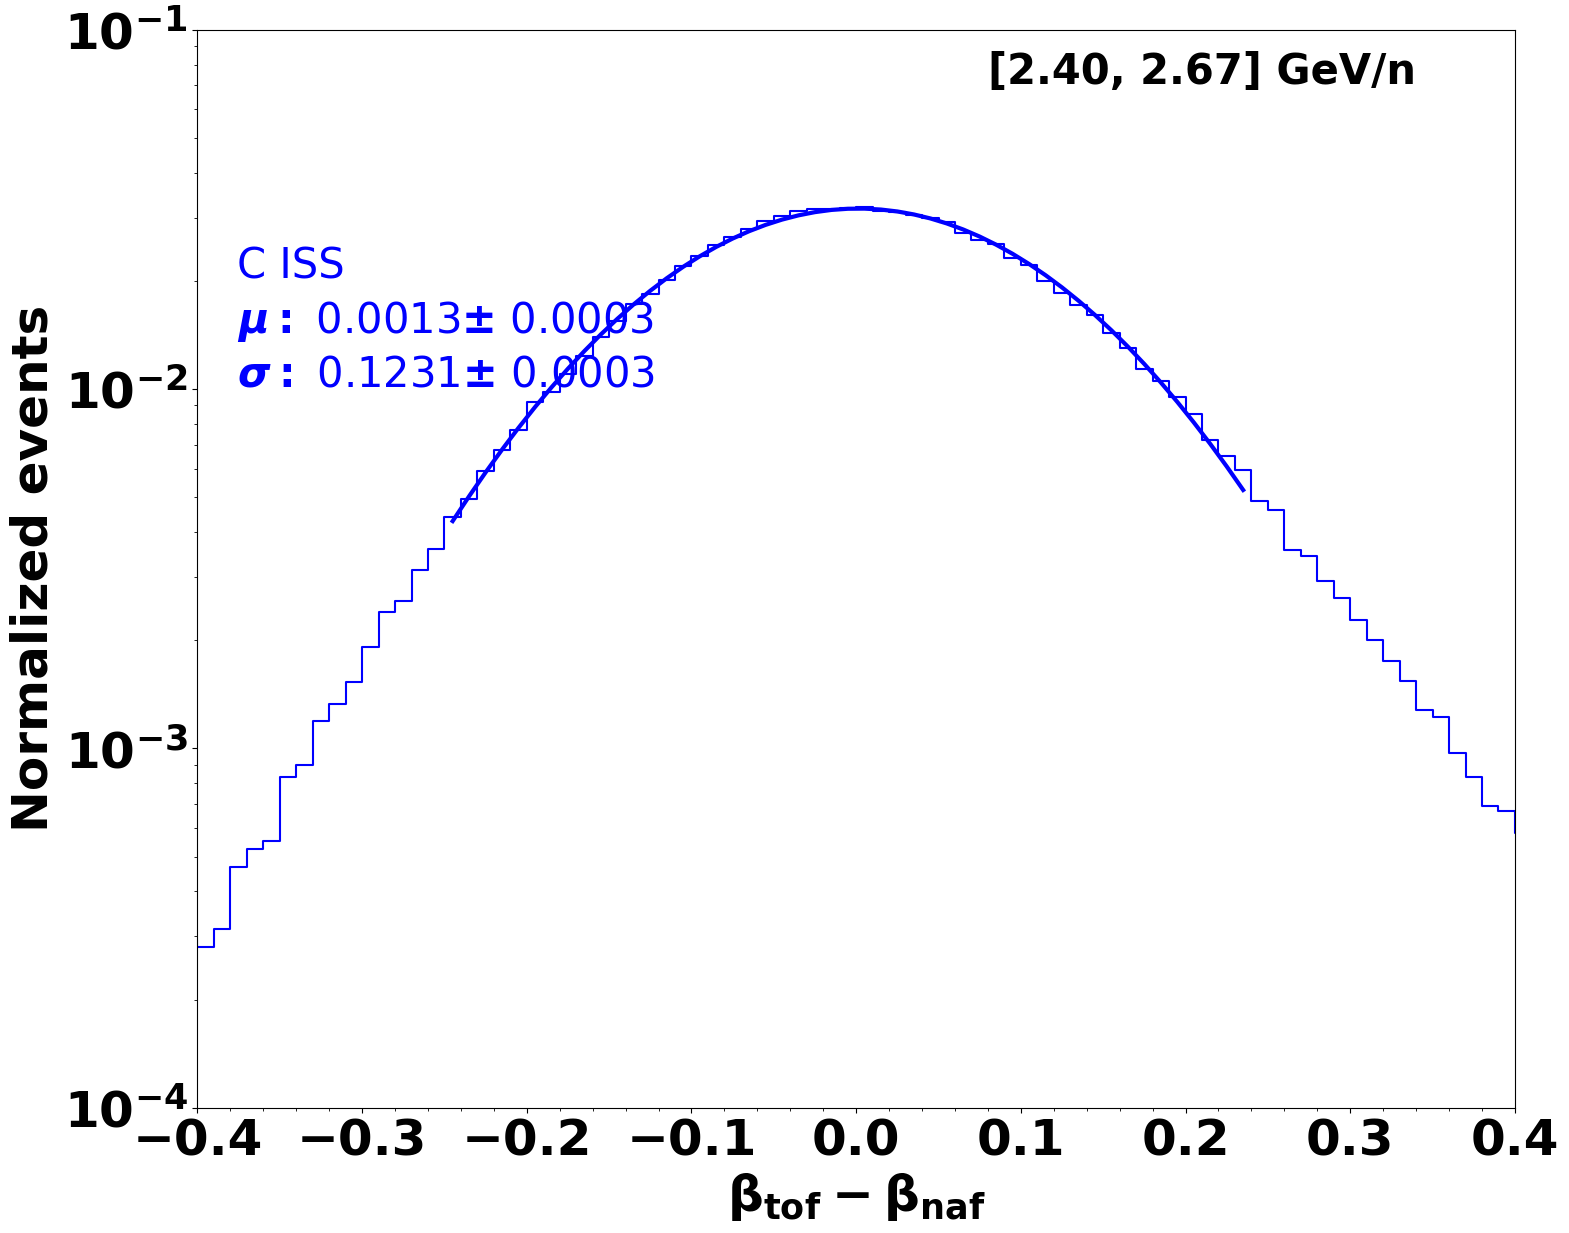

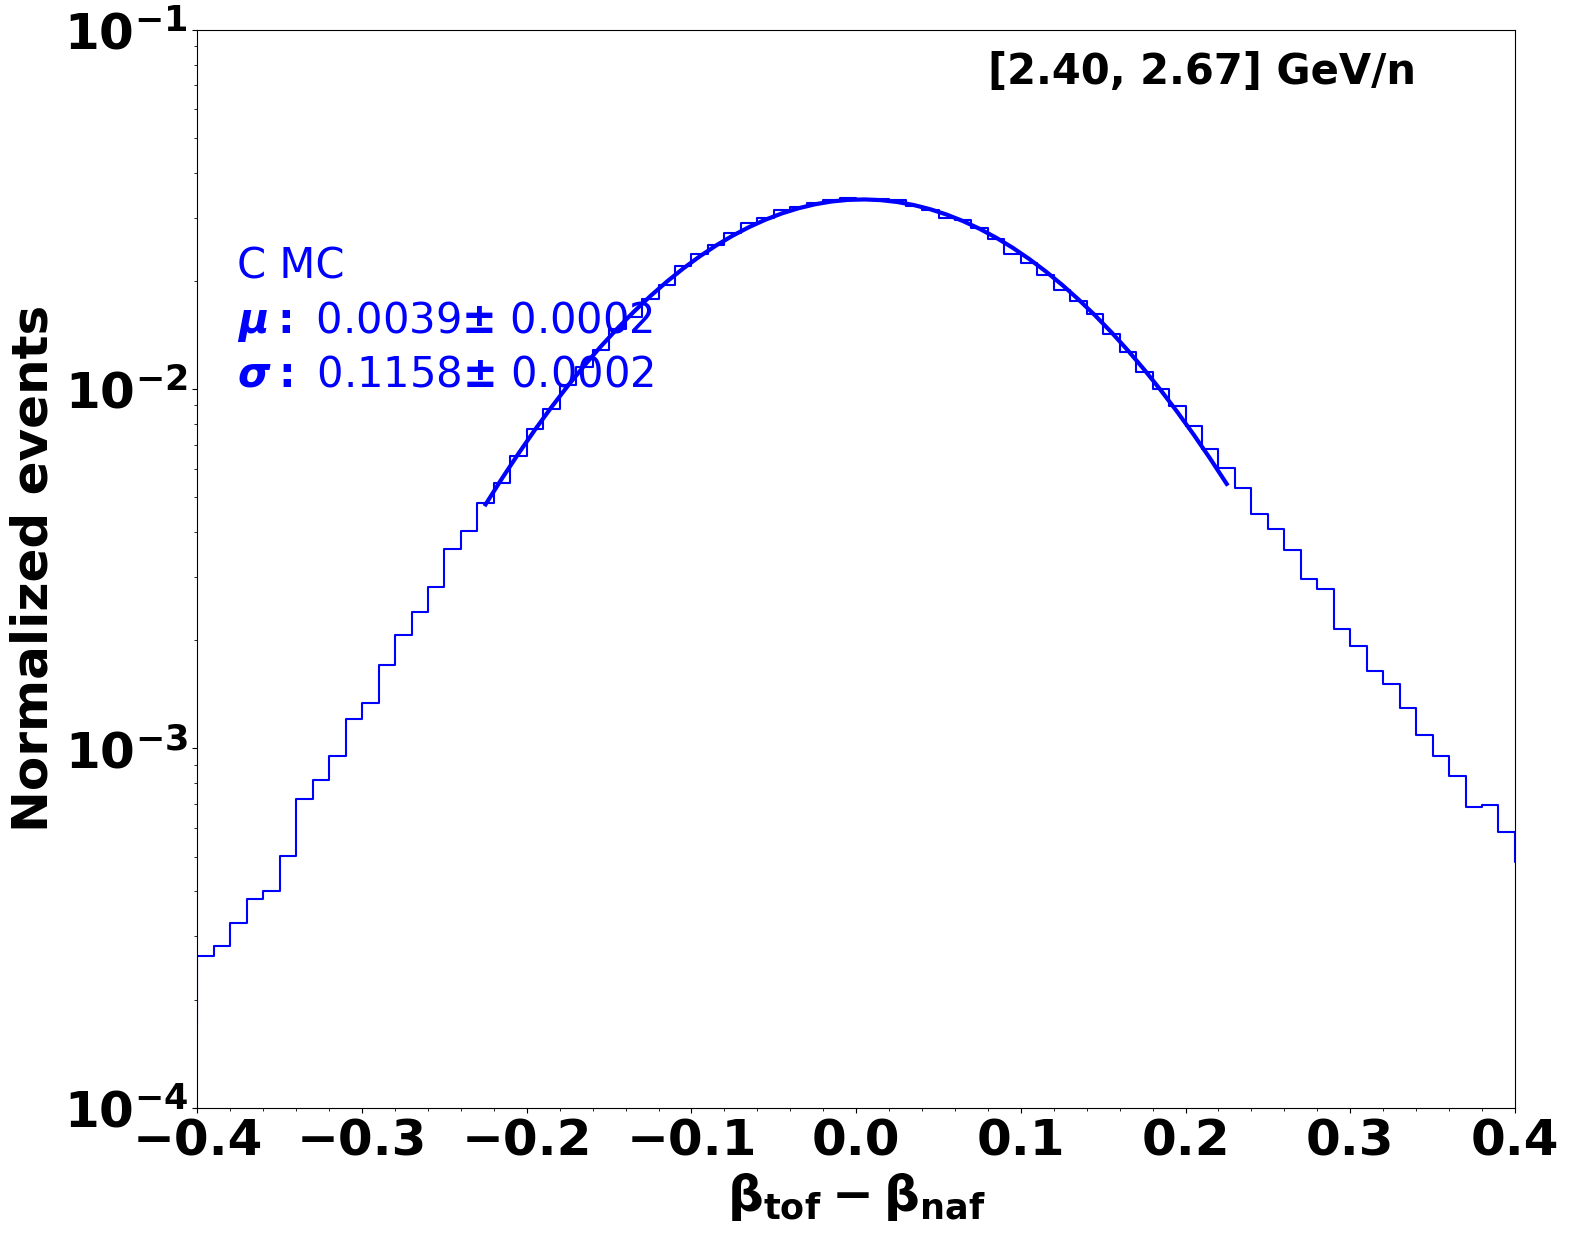

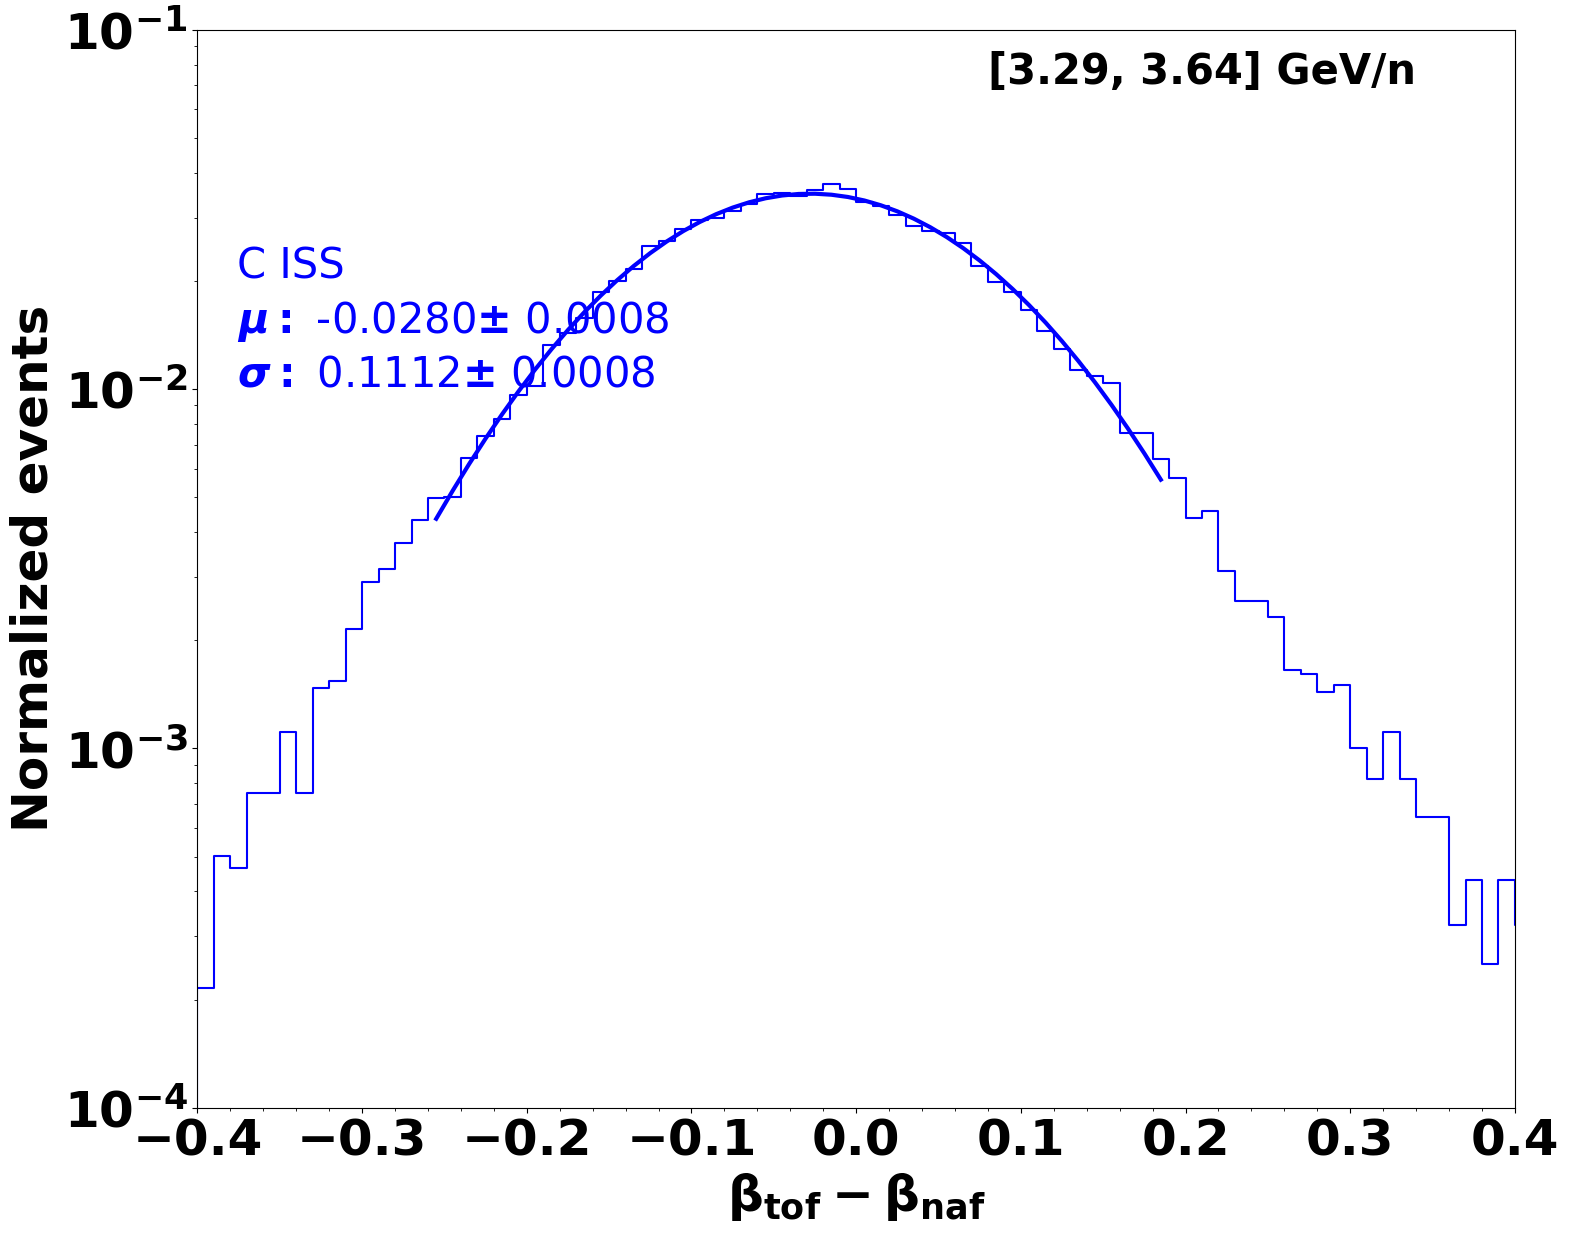

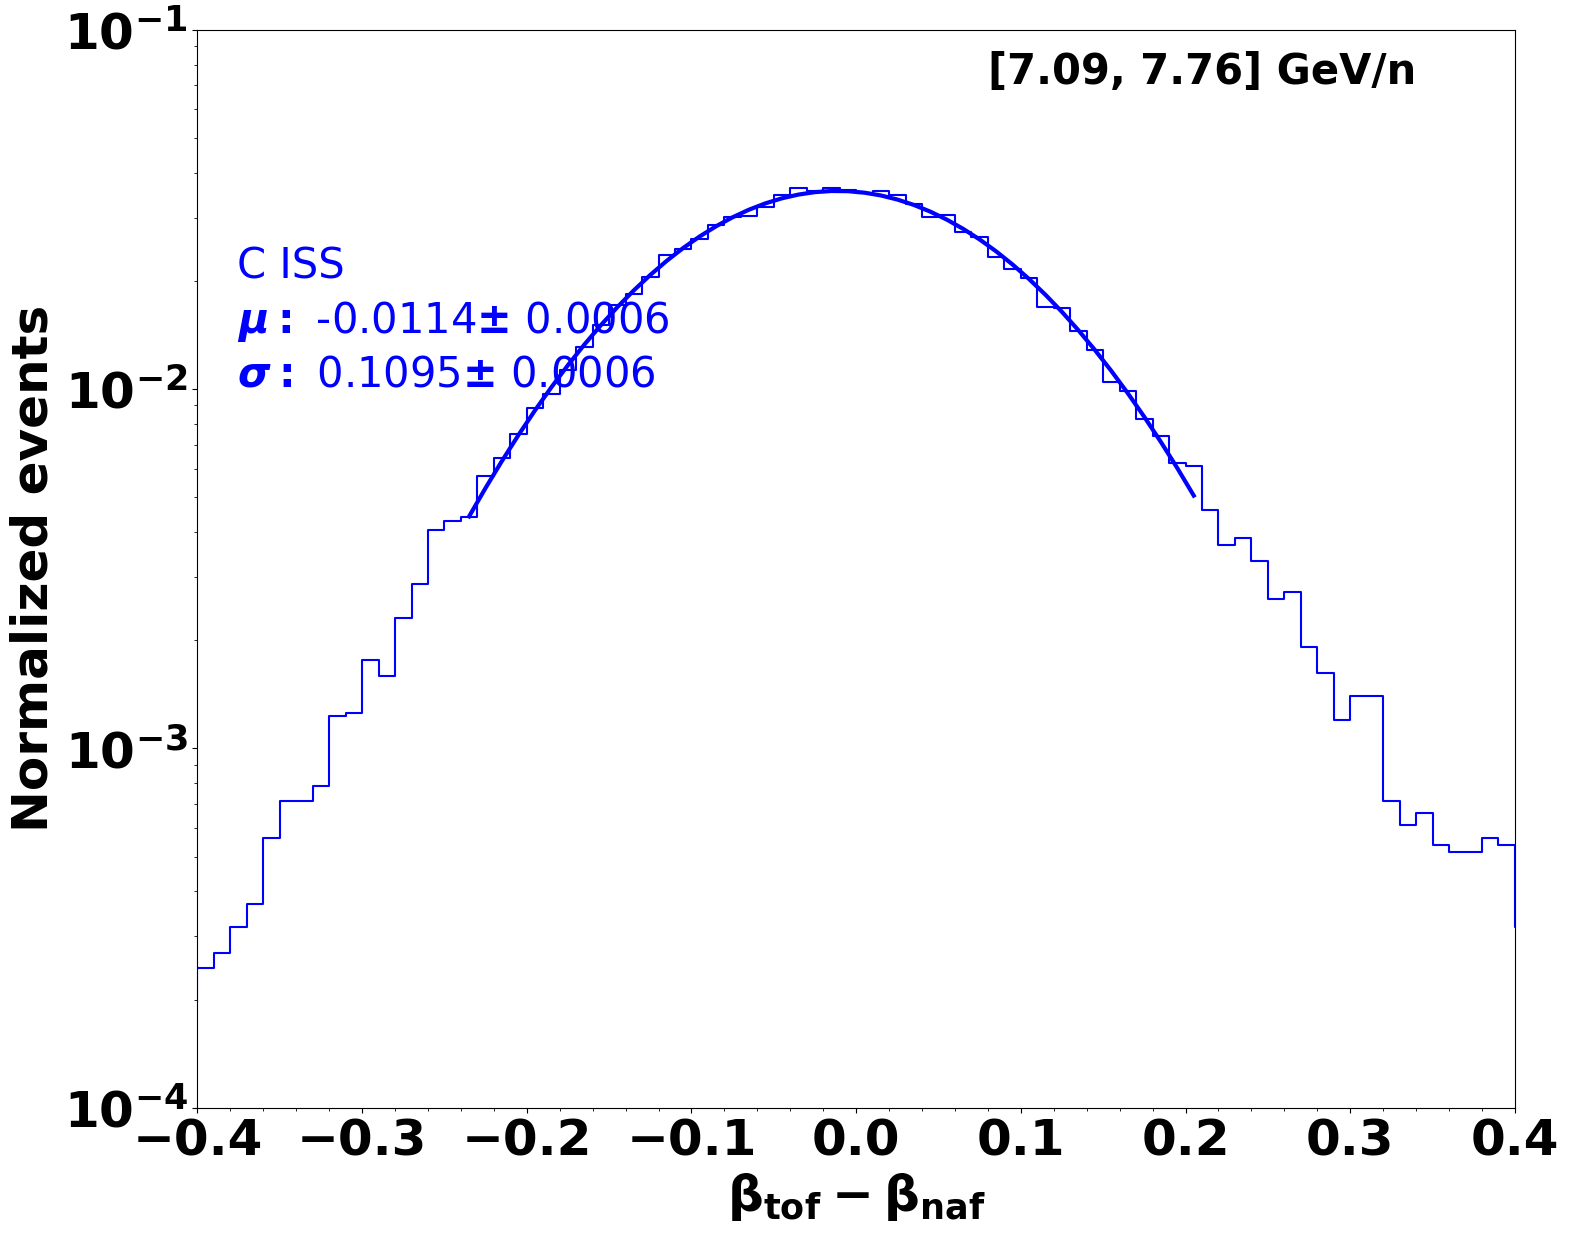

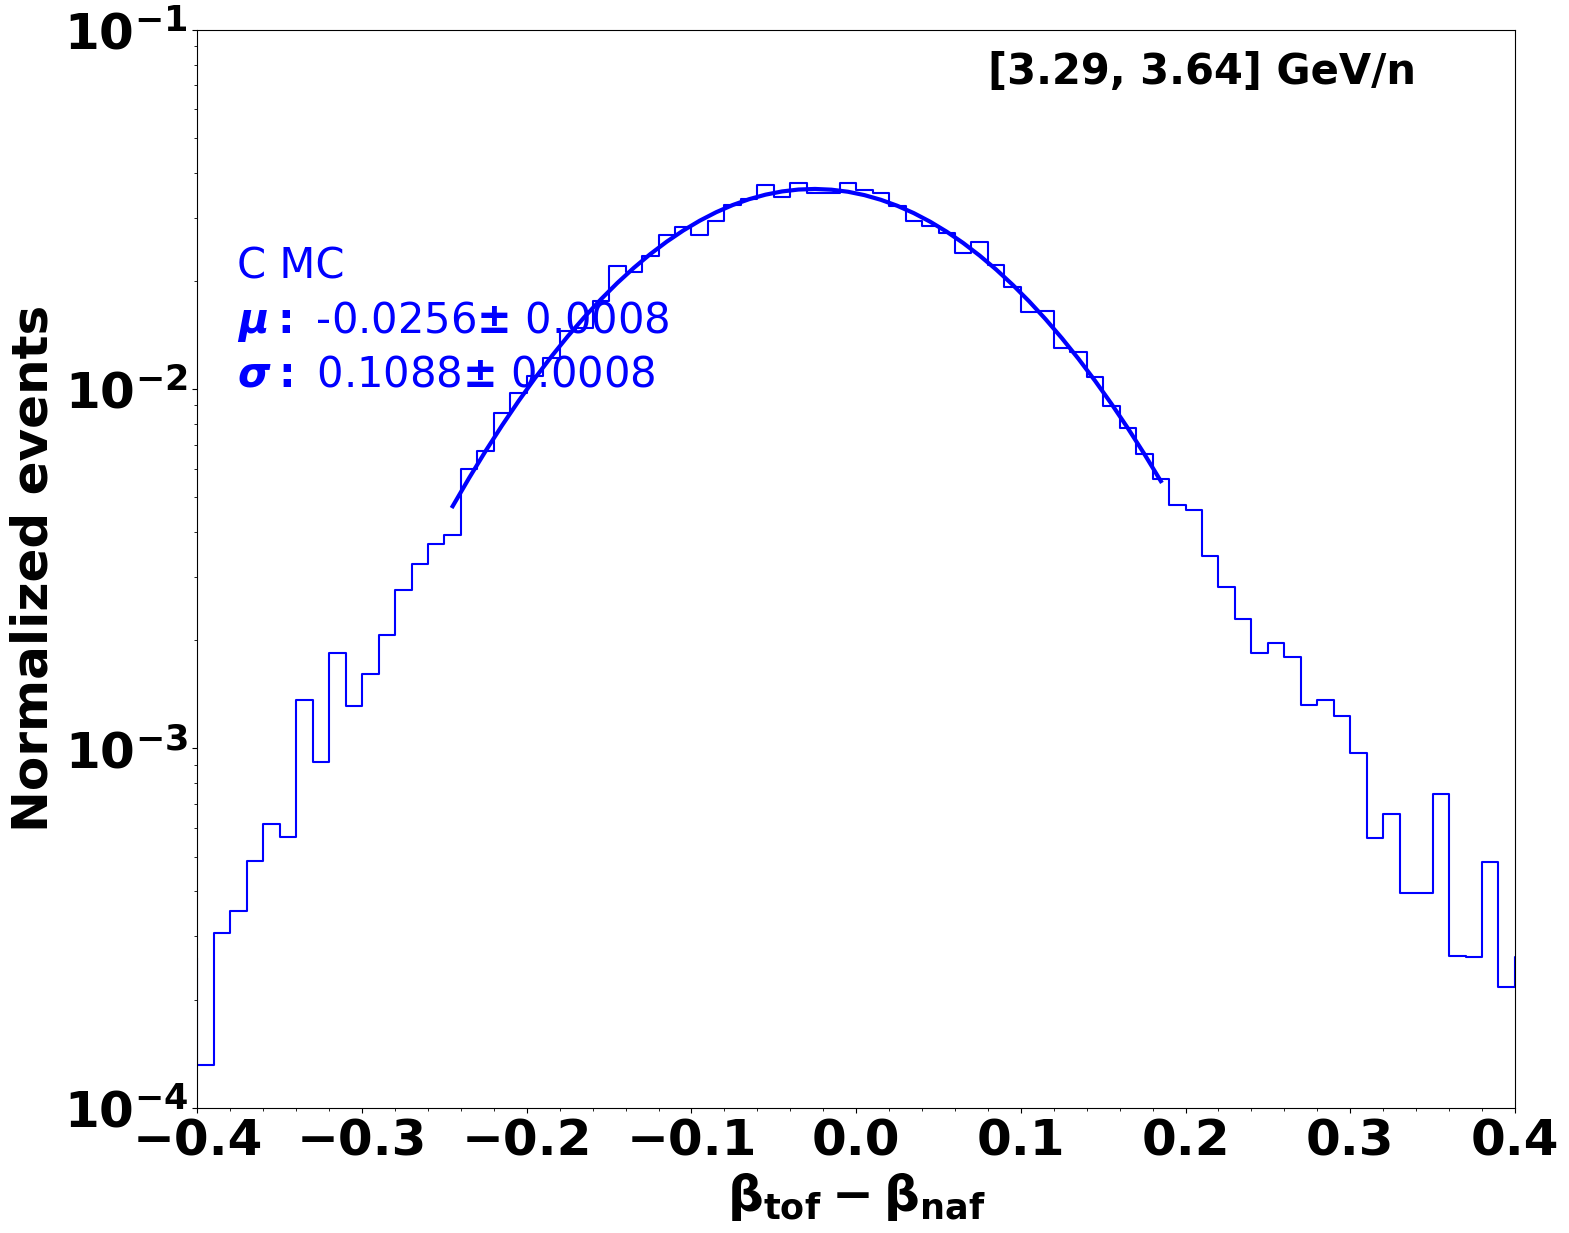

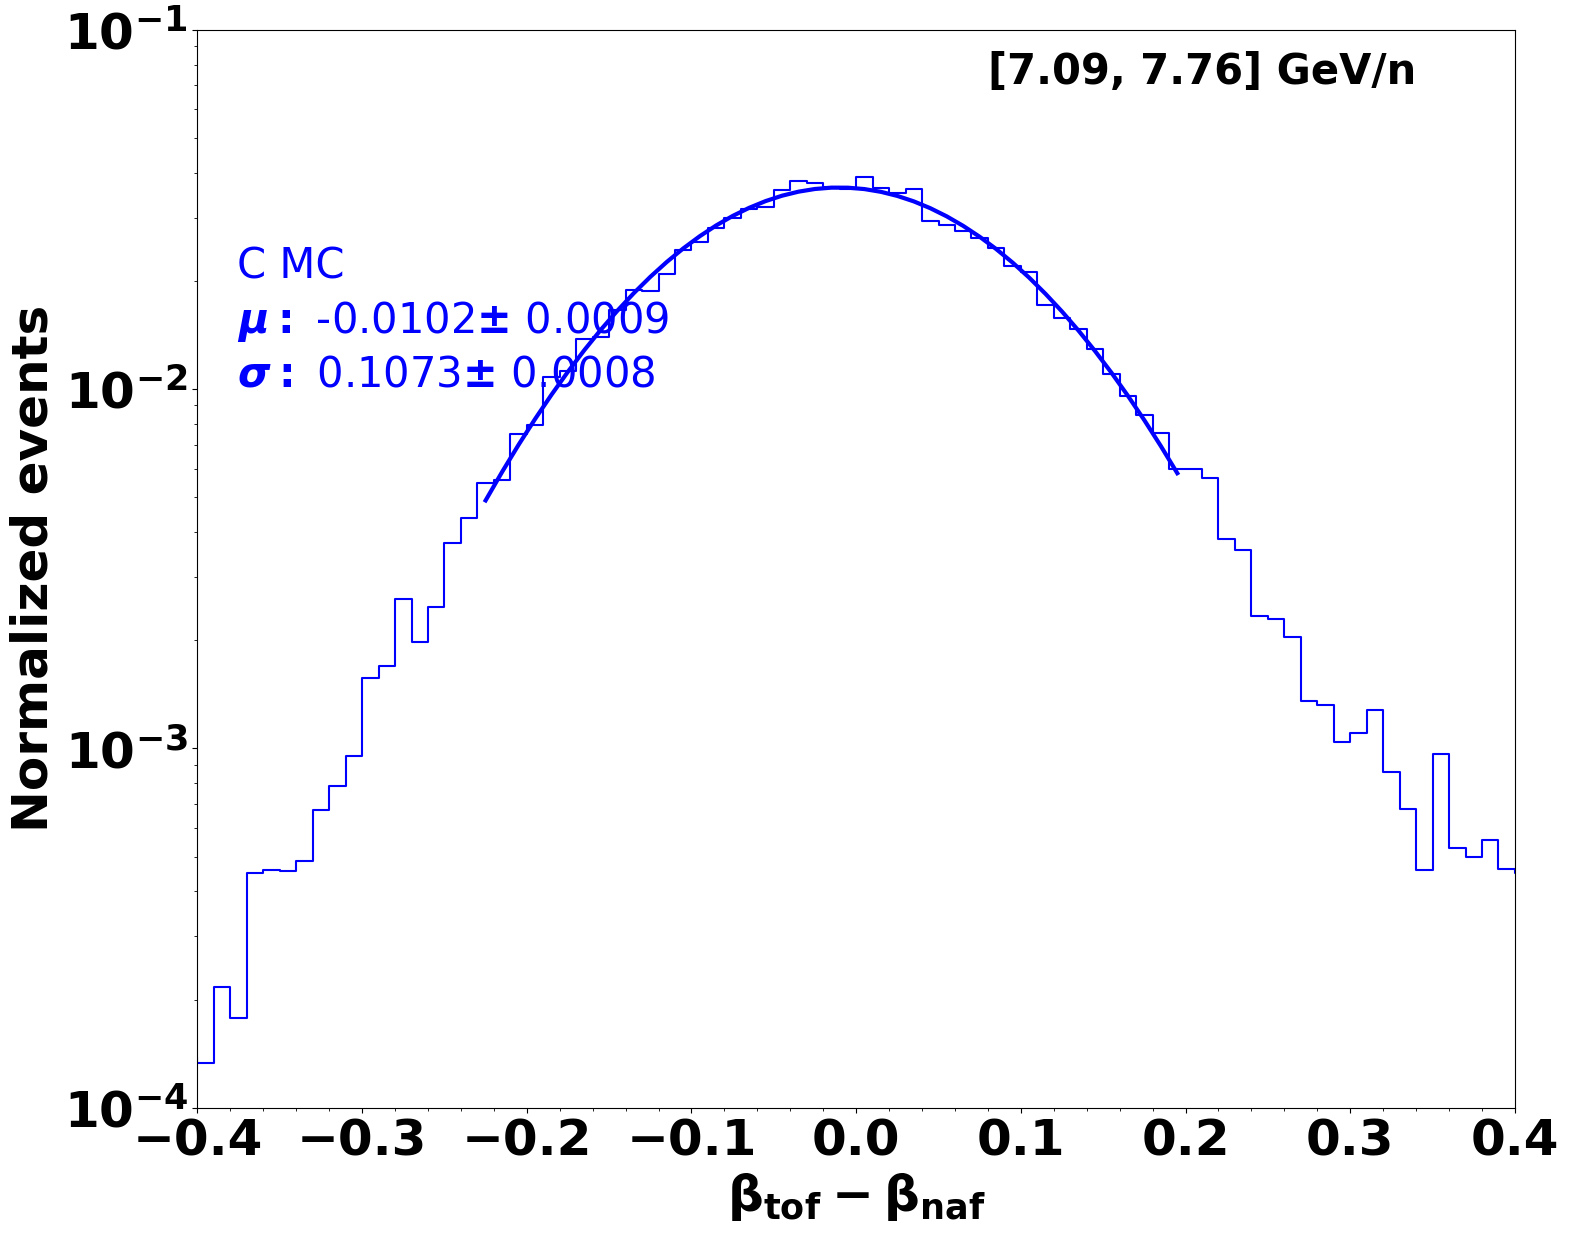

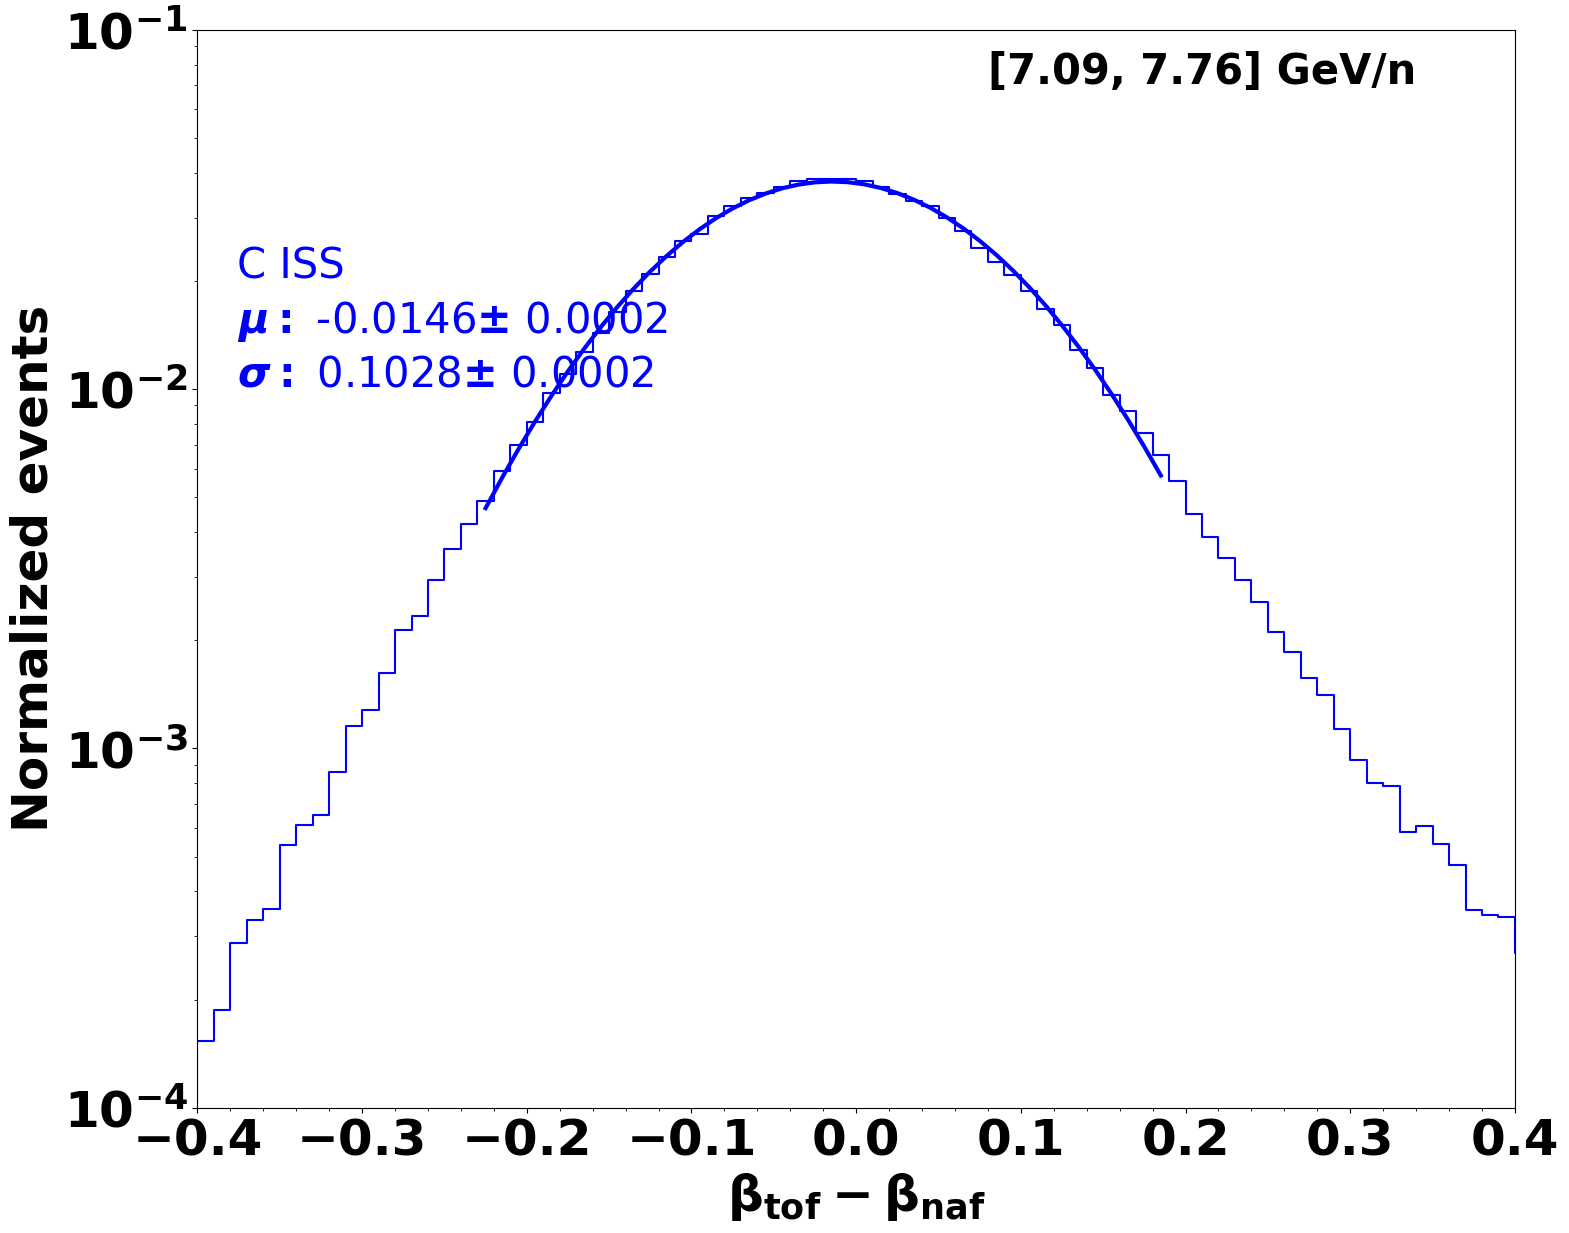

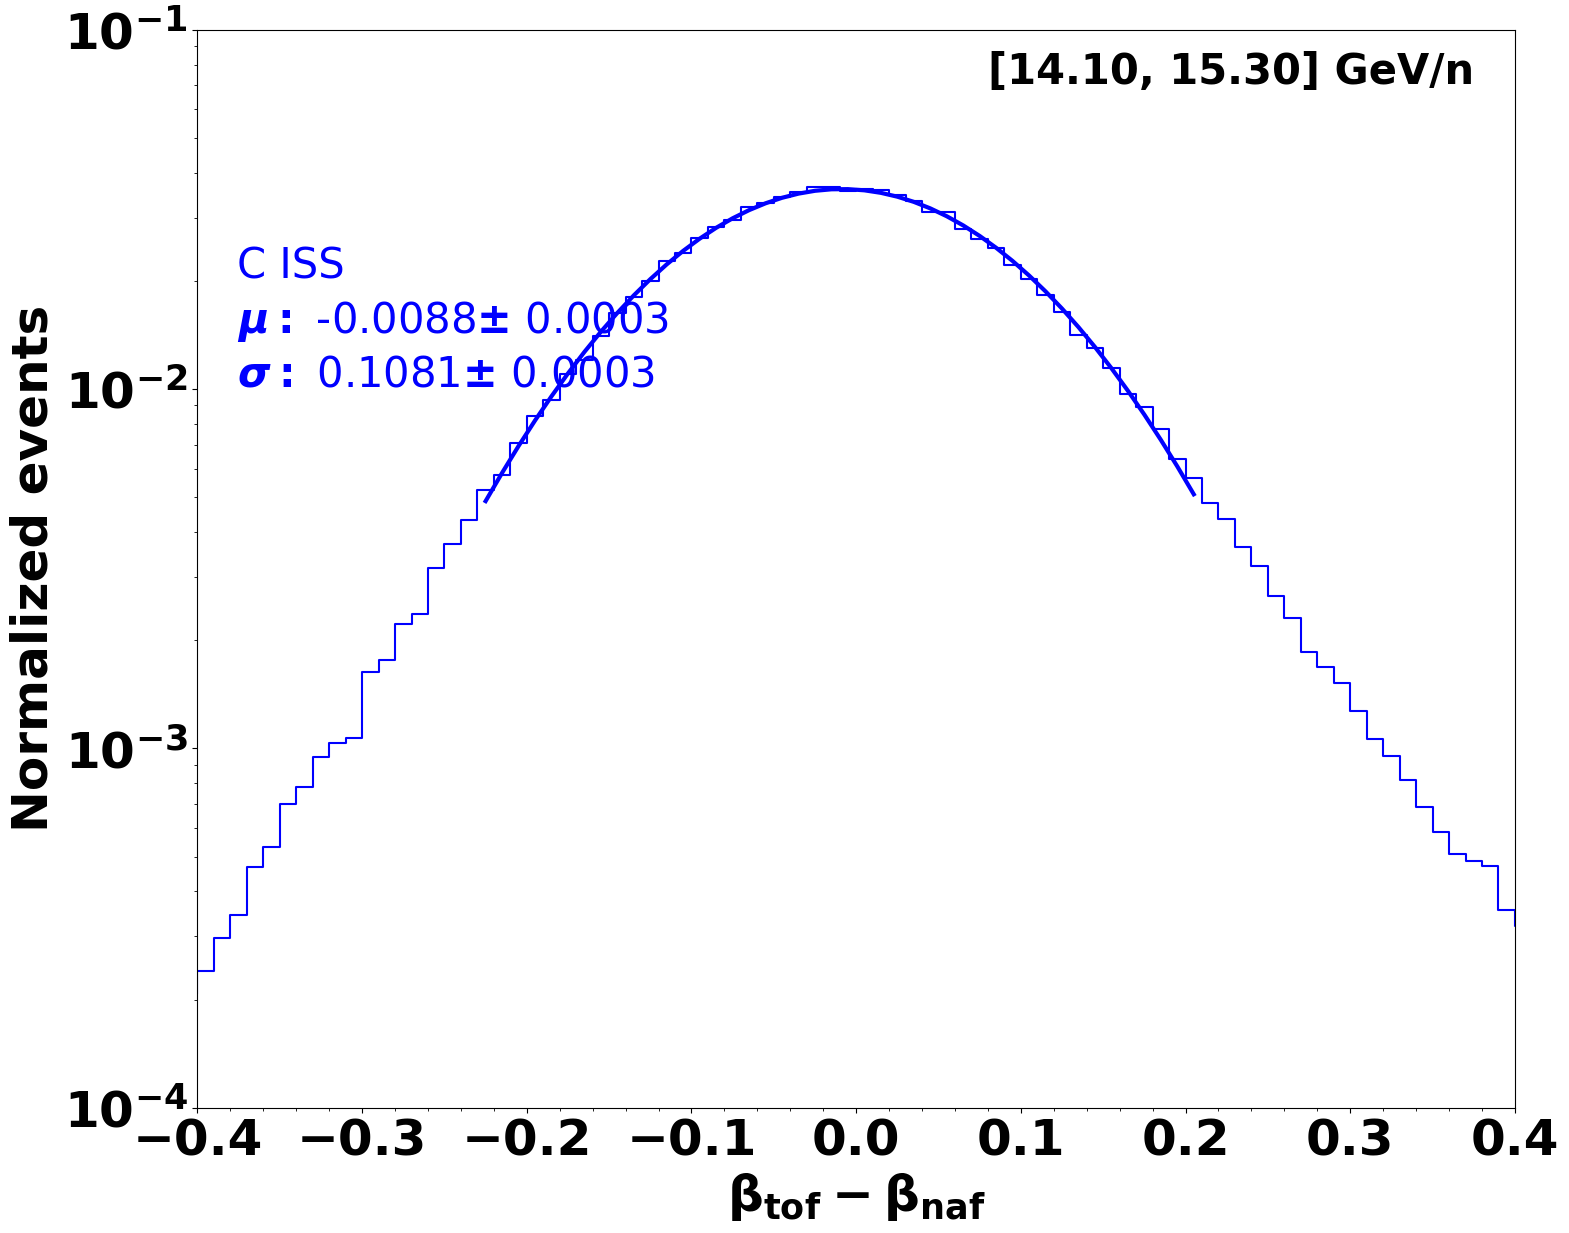

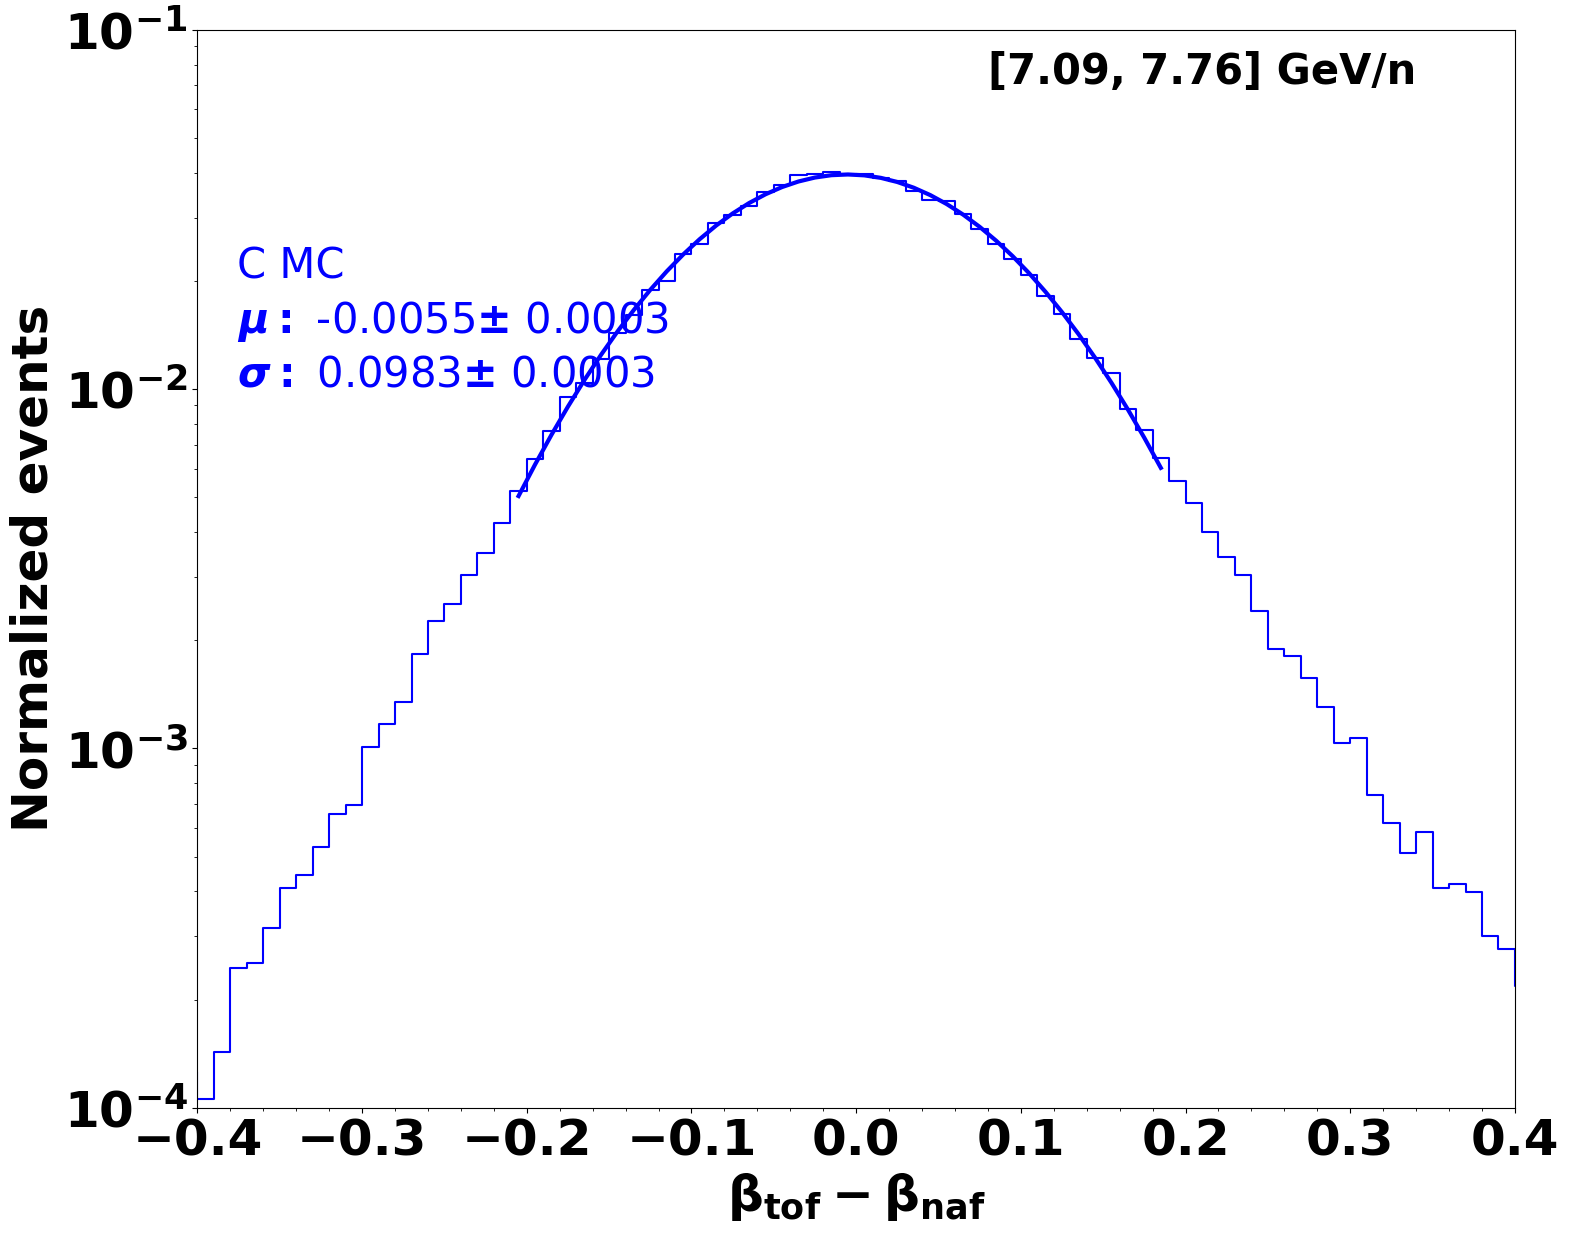

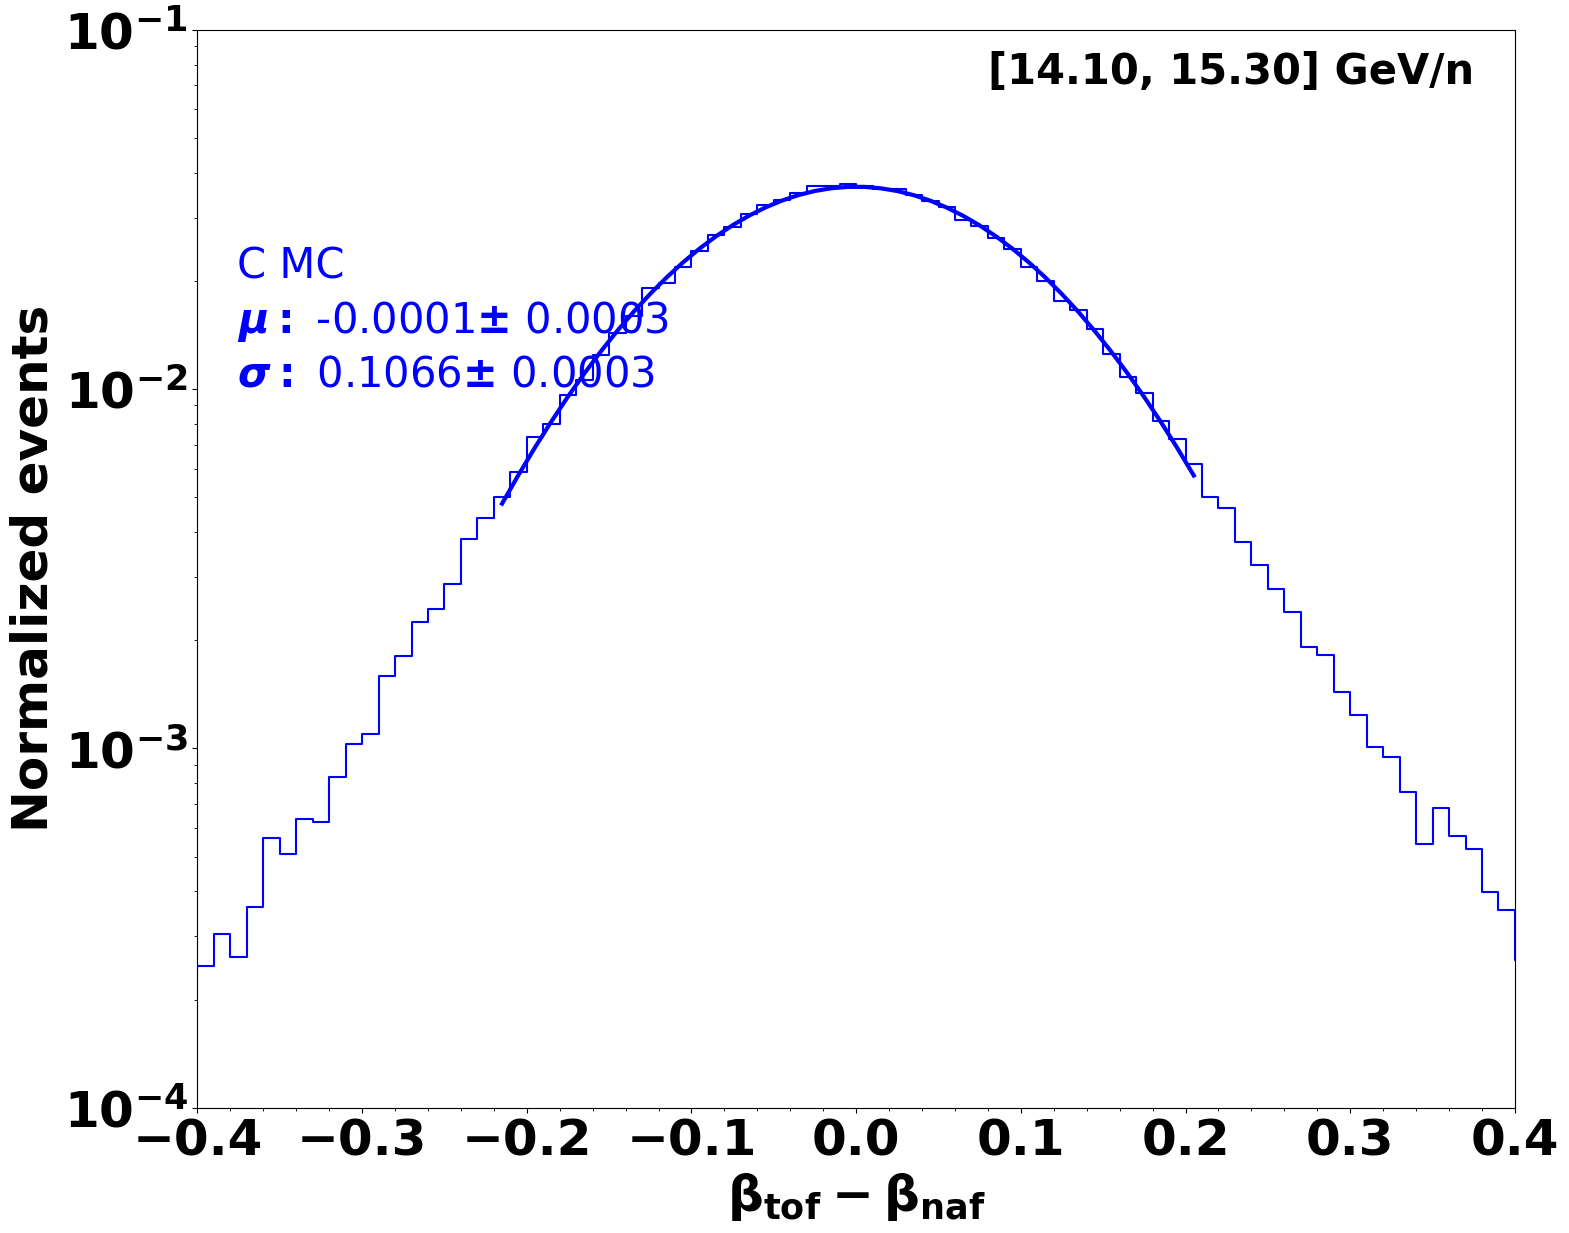

In [7]:
guess0 = dict(norm=1000, mu=0.001, sigma=0.1)
xrange = [-0.25, 0.25]
graph_mean_rigISS = {}
graph_sigma_rigISS = {}
graph_mean_rigMC = {}
graph_sigma_rigMC = {}
guess0 = dict(norm=0.1, mu=0.001, sigma=0.1)
guess0mc = dict(norm=0.1, mu=-0.001, sigma=0.1)
binrange = {'Tof': [7, 11], 'NaF': [10, 24], 'Agl': [18, 35]}
for dec in detectors:
    graph_mean_rigISS[dec], graph_sigma_rigISS[dec] = get_musigma_gausfit(hist2d_iss[dec], binrange[dec][0],binrange[dec][1], guess0, xrange, FigName='ISS')
    graph_mean_rigMC[dec], graph_sigma_rigMC[dec] = get_musigma_gausfit(hist2d_mc[dec], binrange[dec][0],binrange[dec][1], guess0mc, xrange, FigName='MC')
 



/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)



xvalues			yvalues			yerrs
2.035			1.0604408026927017			0.0041478304922416545
2.275			1.054859679142989			0.003427850375444424
2.535			1.062812099715849			0.003241713475740322
2.8200000000000003			1.0637338486400205			0.003007006411807815


xvalues			yvalues			yerrs
2.8200000000000003			1.0083484077084655			0.010394050427397258
3.13			1.0472181535025205			0.01085775093119918
3.465			1.0221792721358773			0.010382040237899539
3.83			1.0301878836113465			0.01040577839212727
4.225			1.0357164466097701			0.010586257721151592
4.654999999999999			1.023089229251672			0.01019428699195305
5.125			1.026663979938788			0.01014252803130287
5.635			1.0381063791329088			0.01020879849146369
6.1850000000000005			1.0431696977890699			0.010145384563858785
6.779999999999999			1.0340644007718567			0.009998108602567295
7.425			1.0209656529117555			0.009843828278898181
8.120000000000001			1.0113947247148294			0.009982316815436343
8.870000000000001			1.0247610583916107			0.010049703164607562
9.68			1.037100330

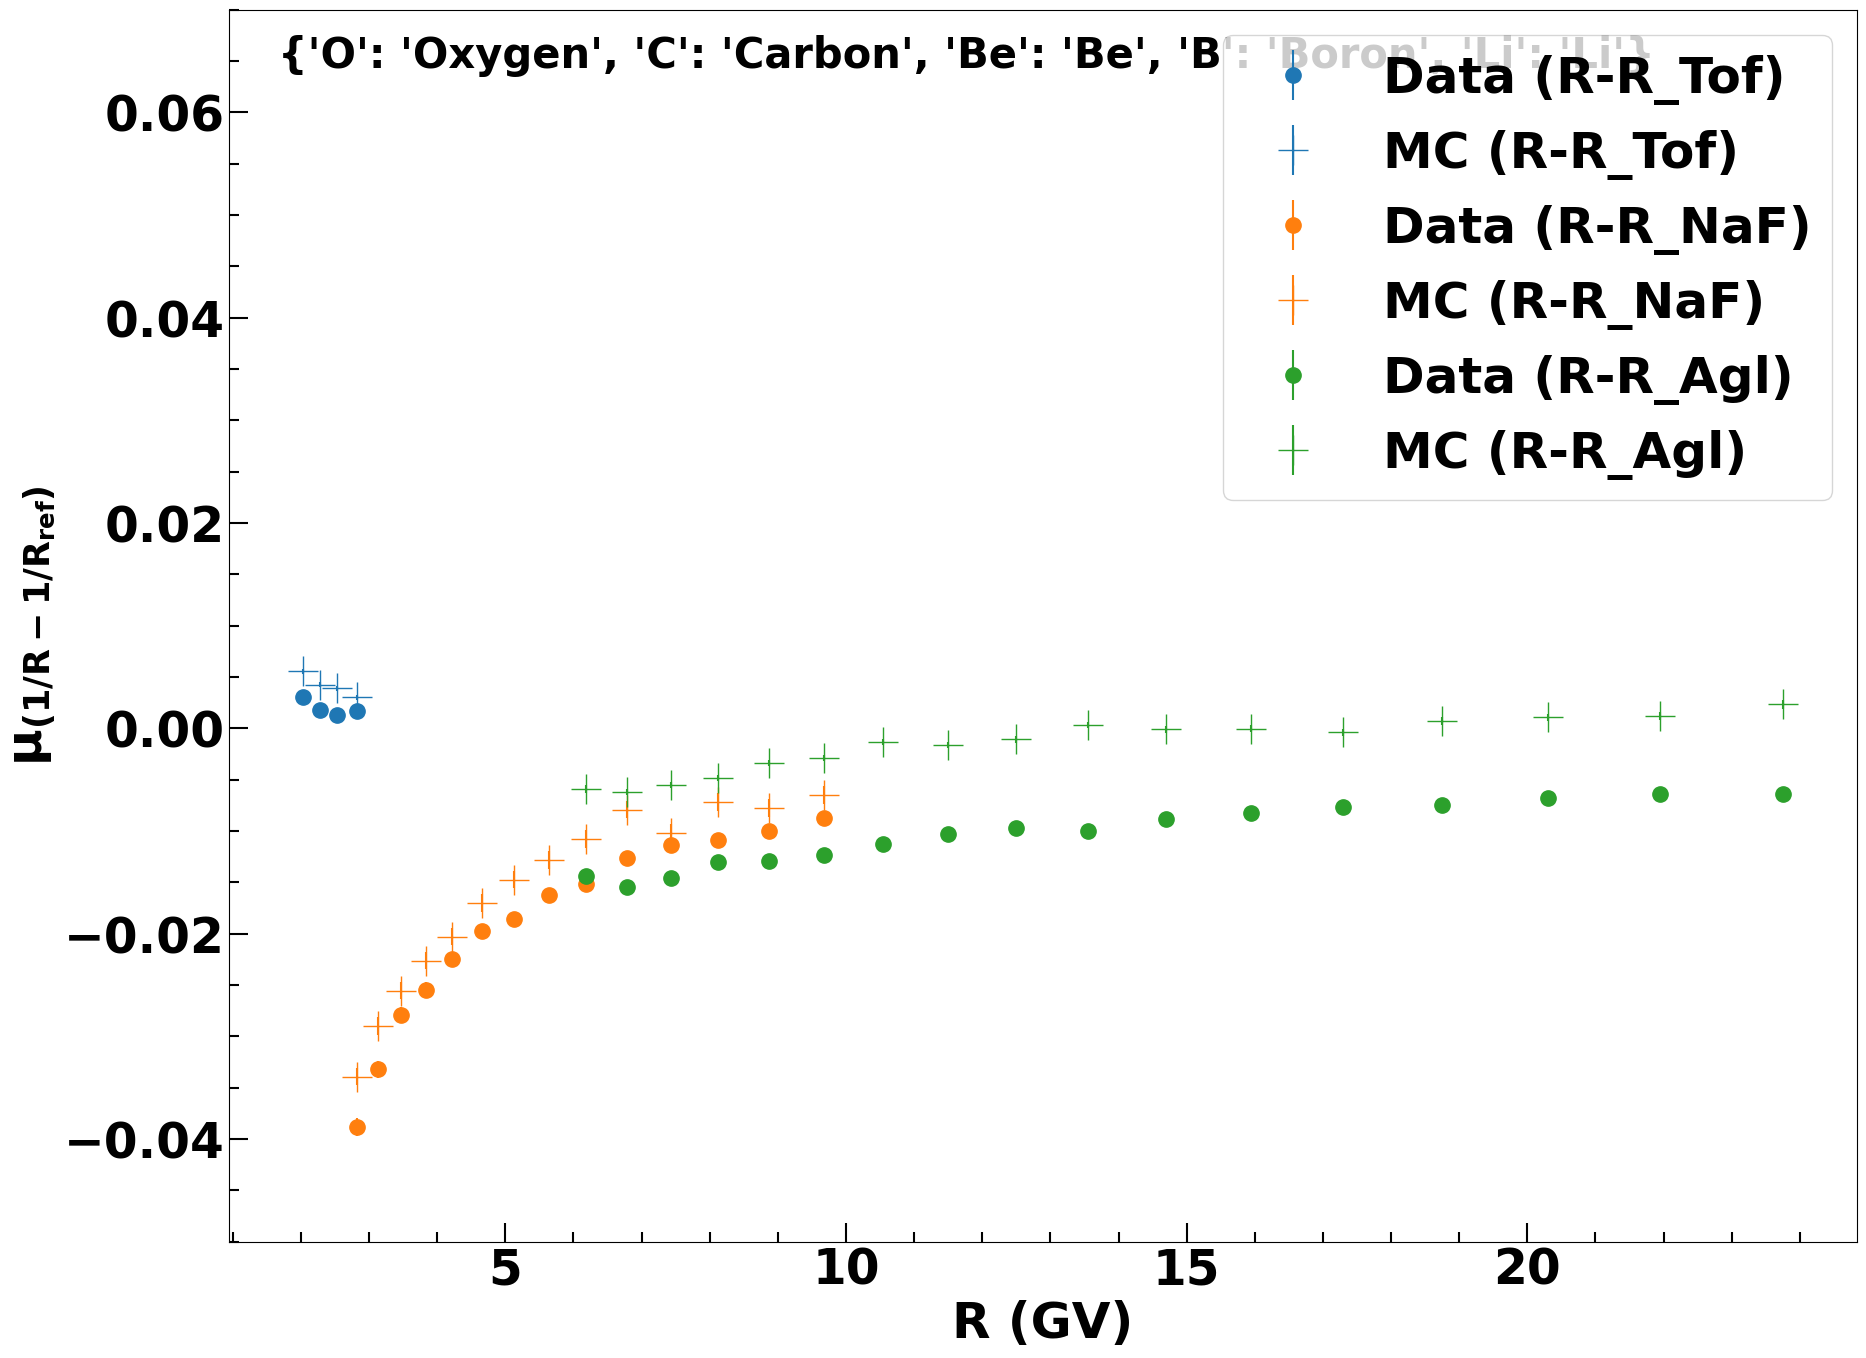

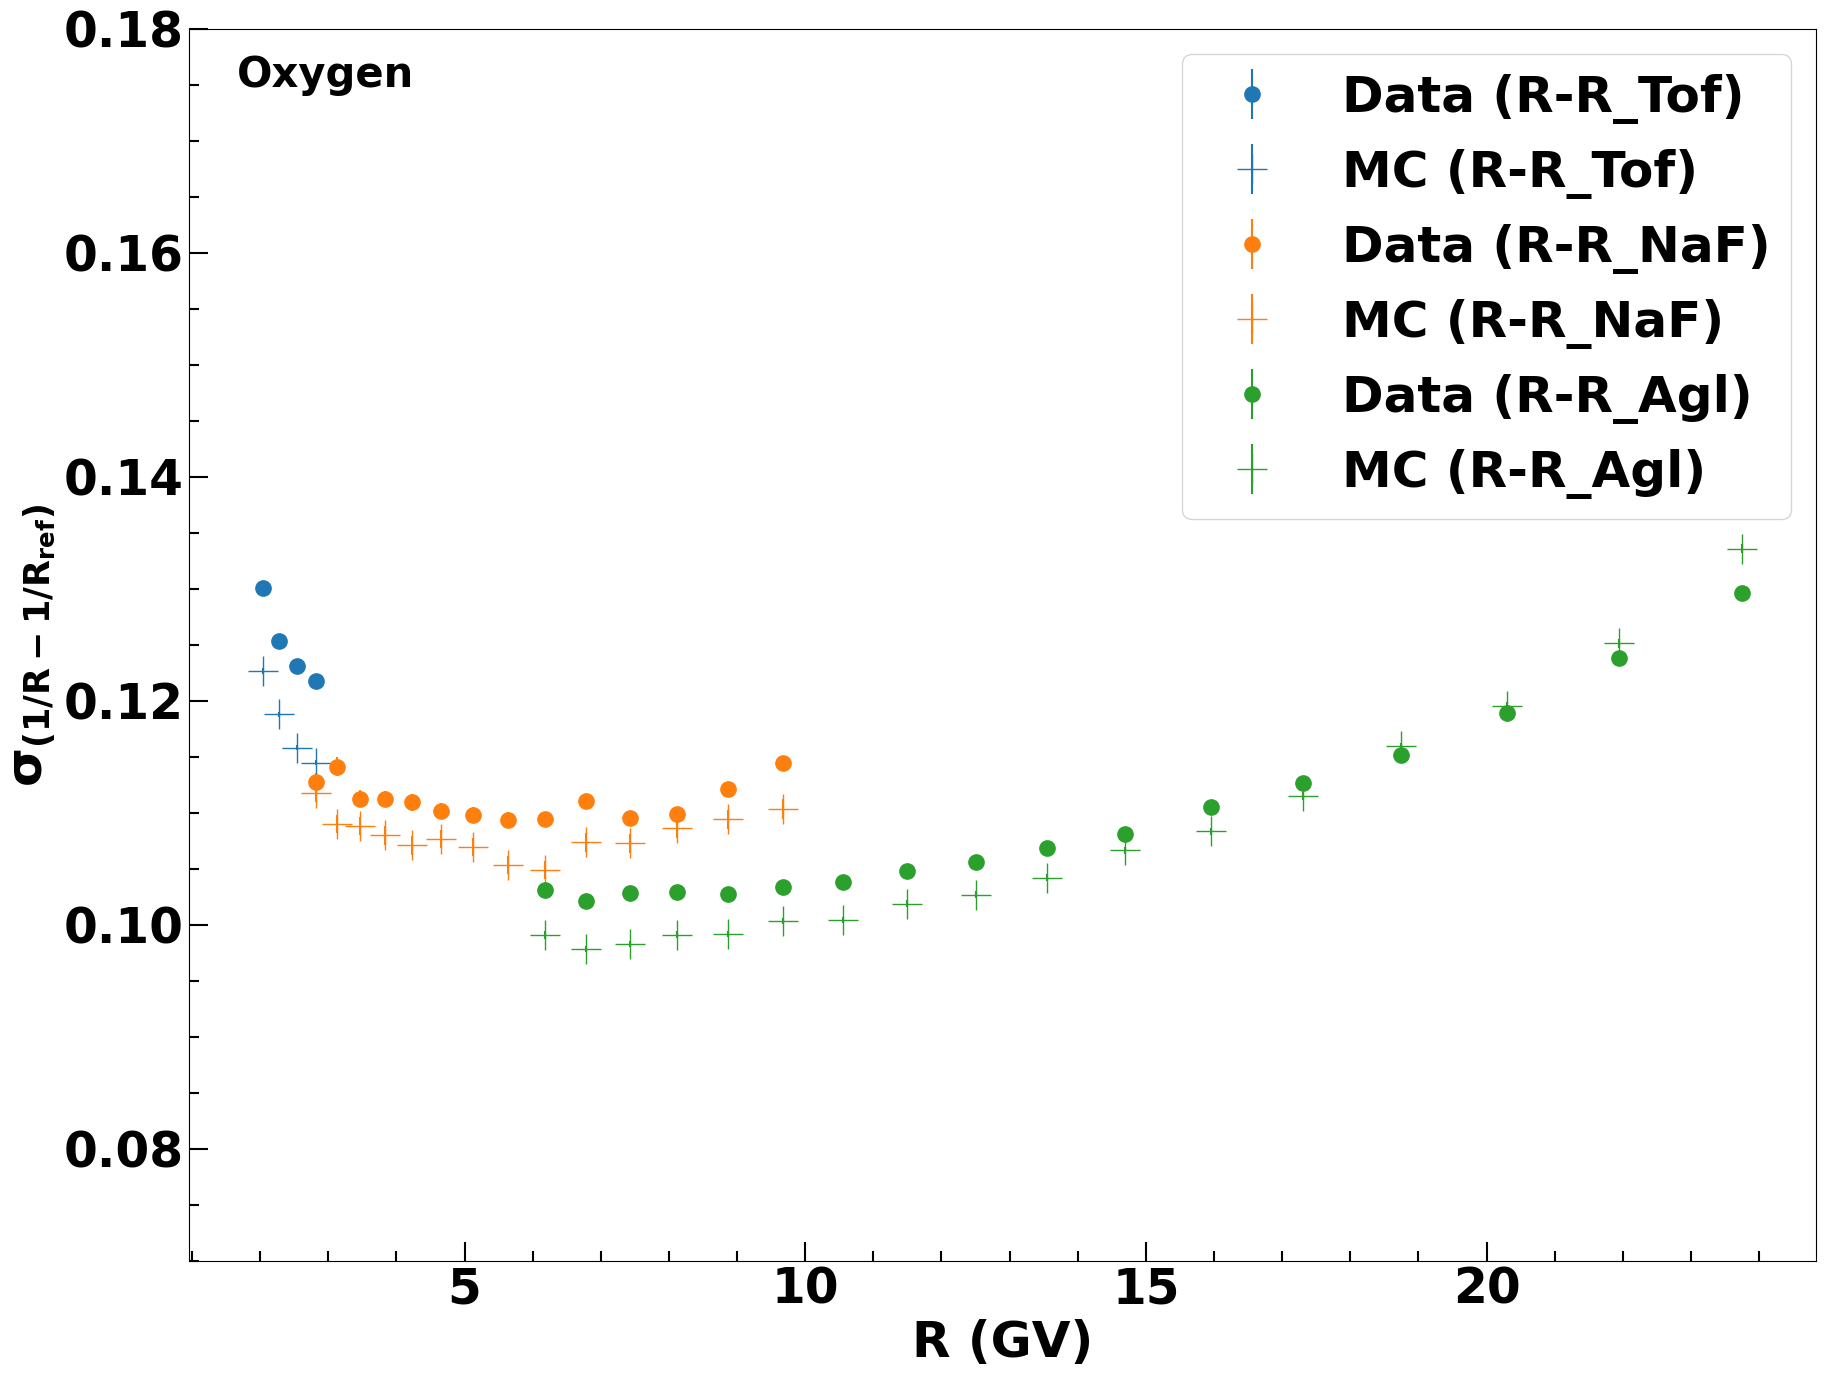

In [8]:
def set_plotstyle(ax1, ax2):
    plt.subplots_adjust(hspace=.0)   
    set_plot_defaultstyle(ax1)
    set_plot_defaultstyle(ax2)
    ax1.set_xticklabels([])
    
fig, ax1 = plt.subplots(1, 1, figsize=(21, 16))
for dec in detectors:
    plot_graph(fig, ax1, graph_mean_rigISS[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data (R-R_{dec})') 
    plot_graph(fig, ax1, graph_mean_rigMC[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, marker='+', label=f'MC (R-R_{dec})') 
ax1.set_xlabel('R (GV)')
ax1.set_ylabel(r'$\mathrm{\mu_{(1/R - 1/R_{ref})}}$')

#ax1.text(0.7, 0.98, f'{nuclei} Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='normal')  
#ax1.text(0.7, 0.94, f'{MCName} MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
ax1.set_ylim([-0.05, 0.07])
#ax1.set_xscale('log')
custom_ticks = [1, 2, 5, 10]  # Adjust these as needed
custom_labels = ['1', '2', '5',  '10']  # Labels for the ticks
ax1.legend()
ax1.text(0.03, 0.98, f'{nucleiname}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='bold')  
#ax1.set_xticks(custom_ticks)
#ax1.set_xticklabels(custom_labels)
#ax2.axhline(y=0.8, color='black', linestyle='--')
savefig_tofile(fig, plotfile, f"graph_mean_{figsuffix}_{nuclei}_RigReso_Ref{dec}", show=True) 

for dec in detectors:
    print(graph_sigma_rigISS[dec]/graph_sigma_rigMC[dec])

fig, ax1 = plt.subplots(1, 1, figsize=(21, 16))
for dec in decs:
    plot_graph(fig, ax1, graph_sigma_rigISS[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Data (R-R_{dec})') 
    plot_graph(fig, ax1, graph_sigma_rigMC[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, marker='+', label=f'MC (R-R_{dec})') 
ax1.set_xlabel('R (GV)')
ax1.set_ylabel(r'$\mathrm{\sigma_{(1/R - 1/R_{ref})}}$')
ax1.legend()


ax1.text(0.03, 0.98, f'Oxygen', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='bold')  
#ax1.text(0.7, 0.94, f'{MCName} MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
ax1.set_ylim([0.07, 0.18])
#ax1.set_xscale('log')
custom_ticks = [1, 2, 5, 10]  # Adjust these as needed
custom_labels = ['1', '2', '5',  '10']  # Labels for t
savefig_tofile(fig, plotfile, f"graph_sigma_{figsuffix}_{nuclei}_RigReso_Ref{dec}", show=True) 


/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Oxygen_RigRefBeta


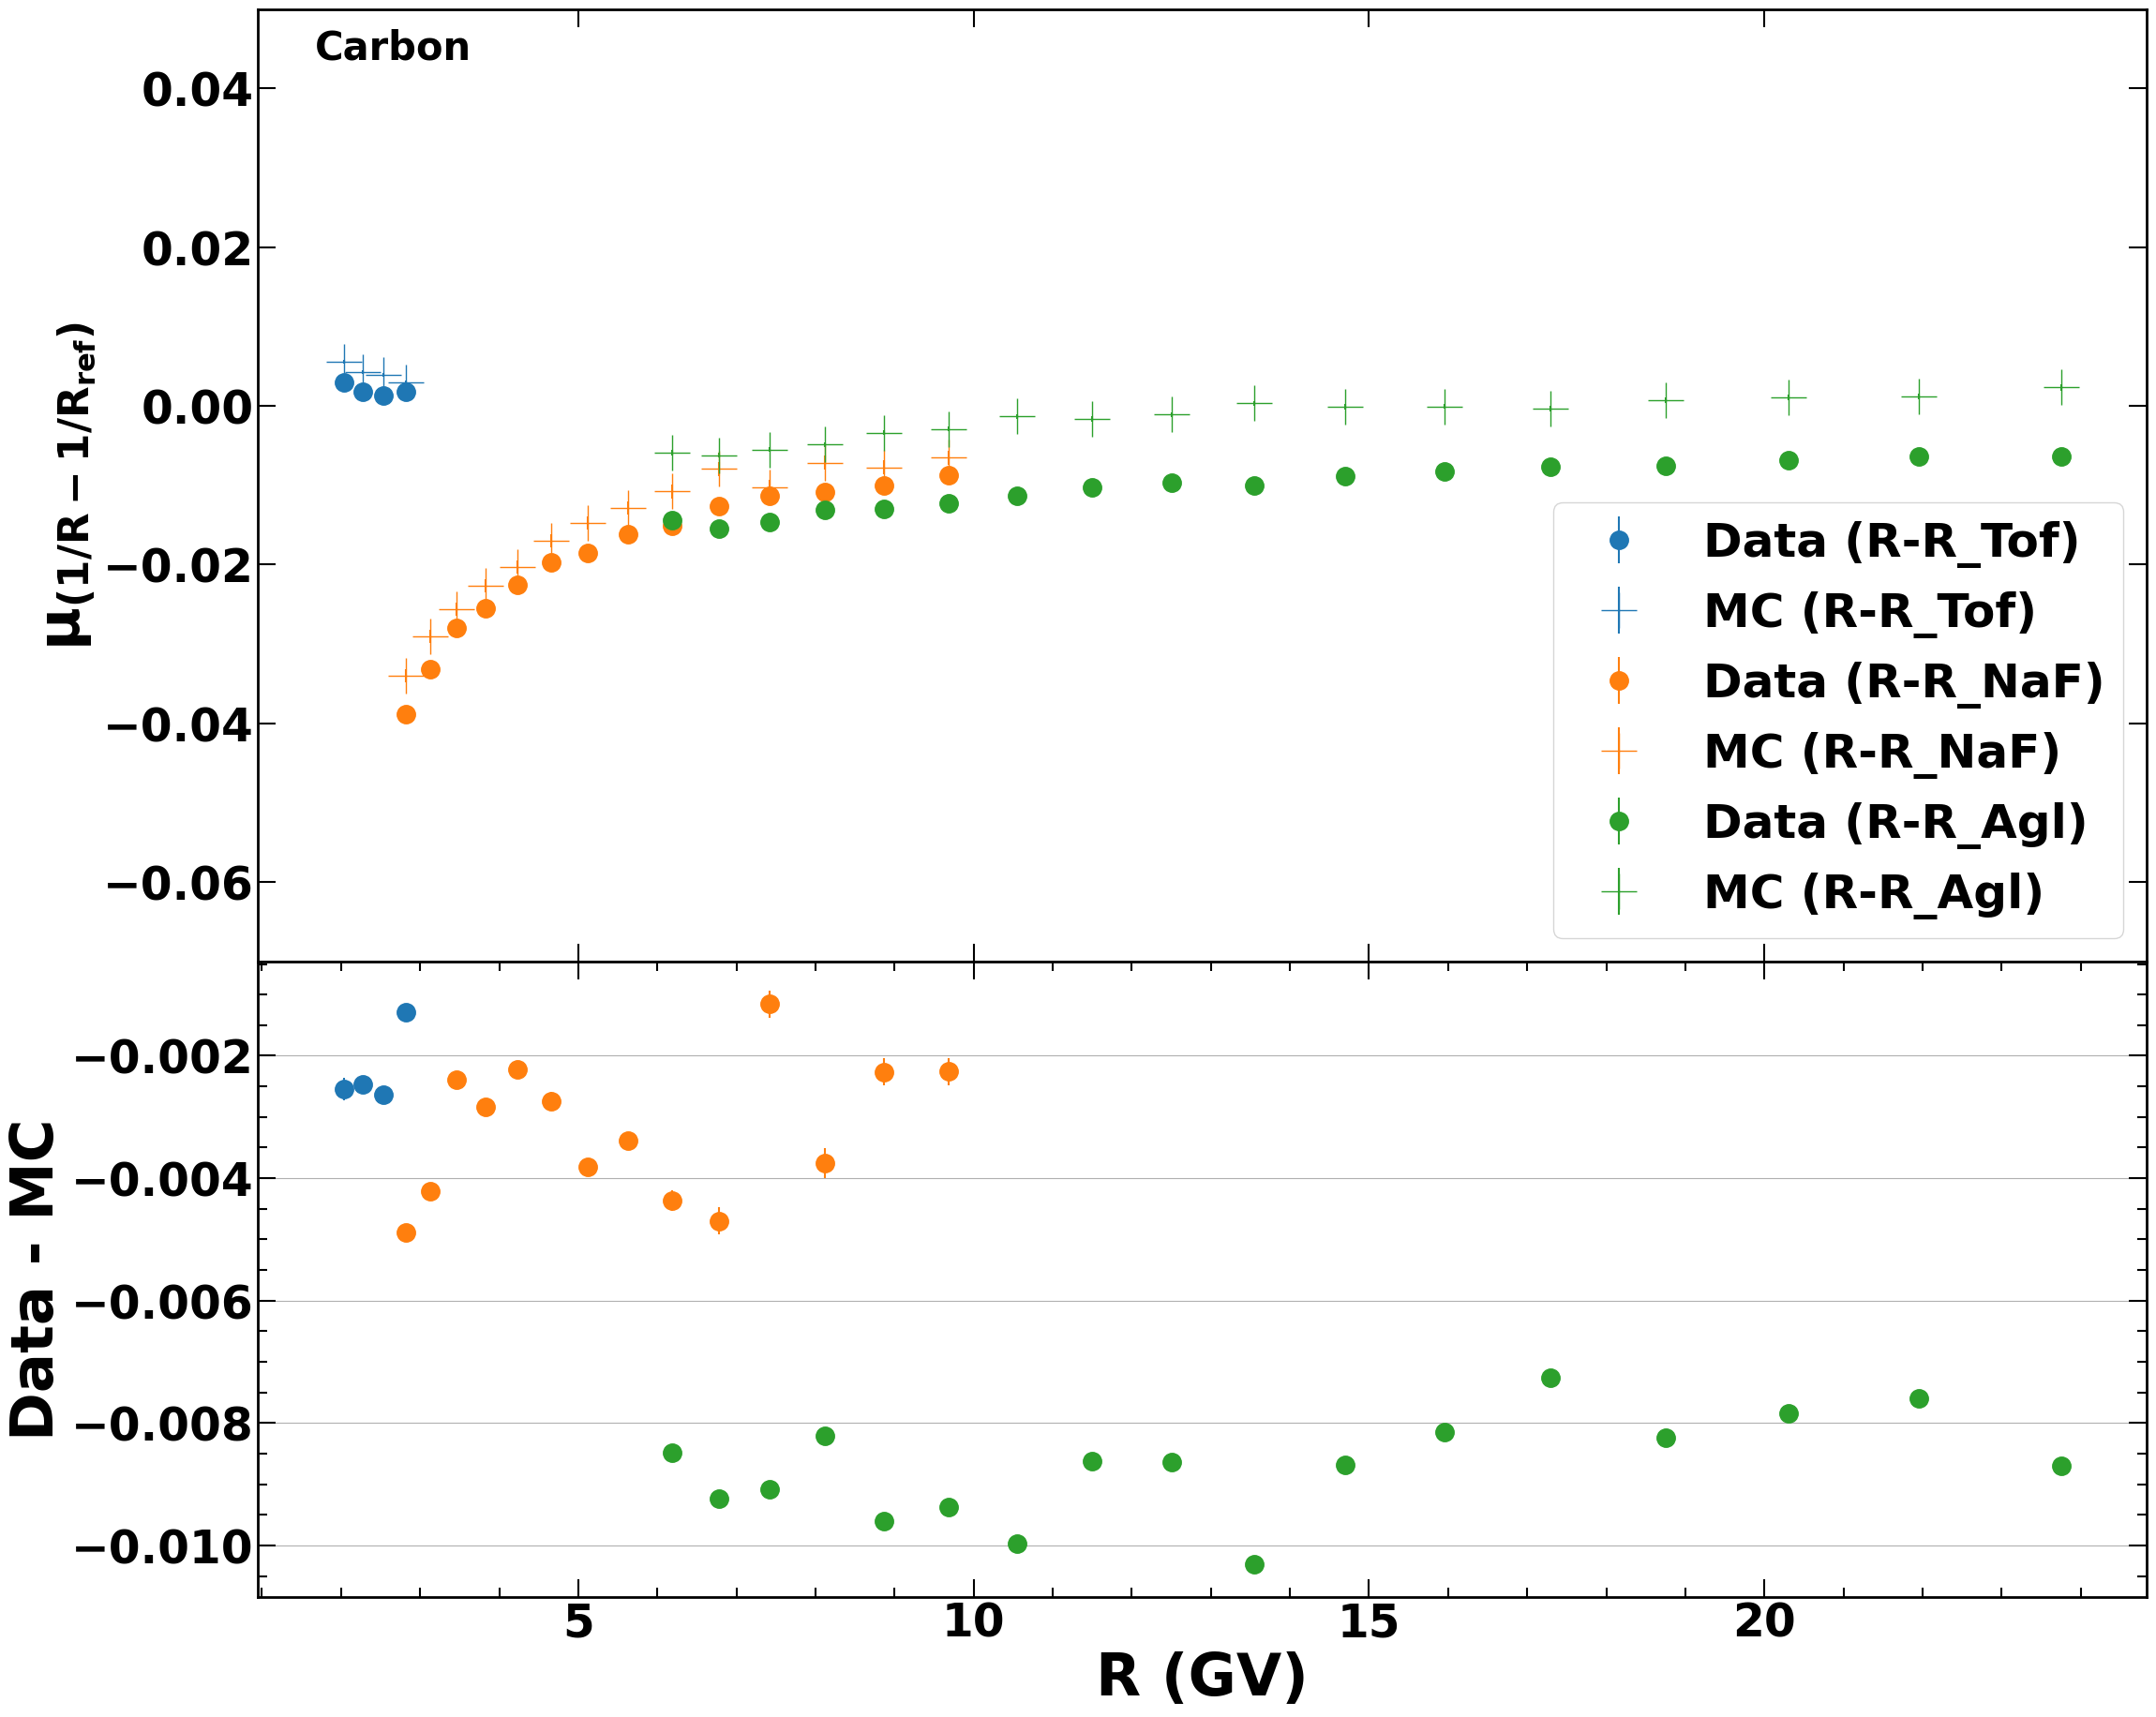

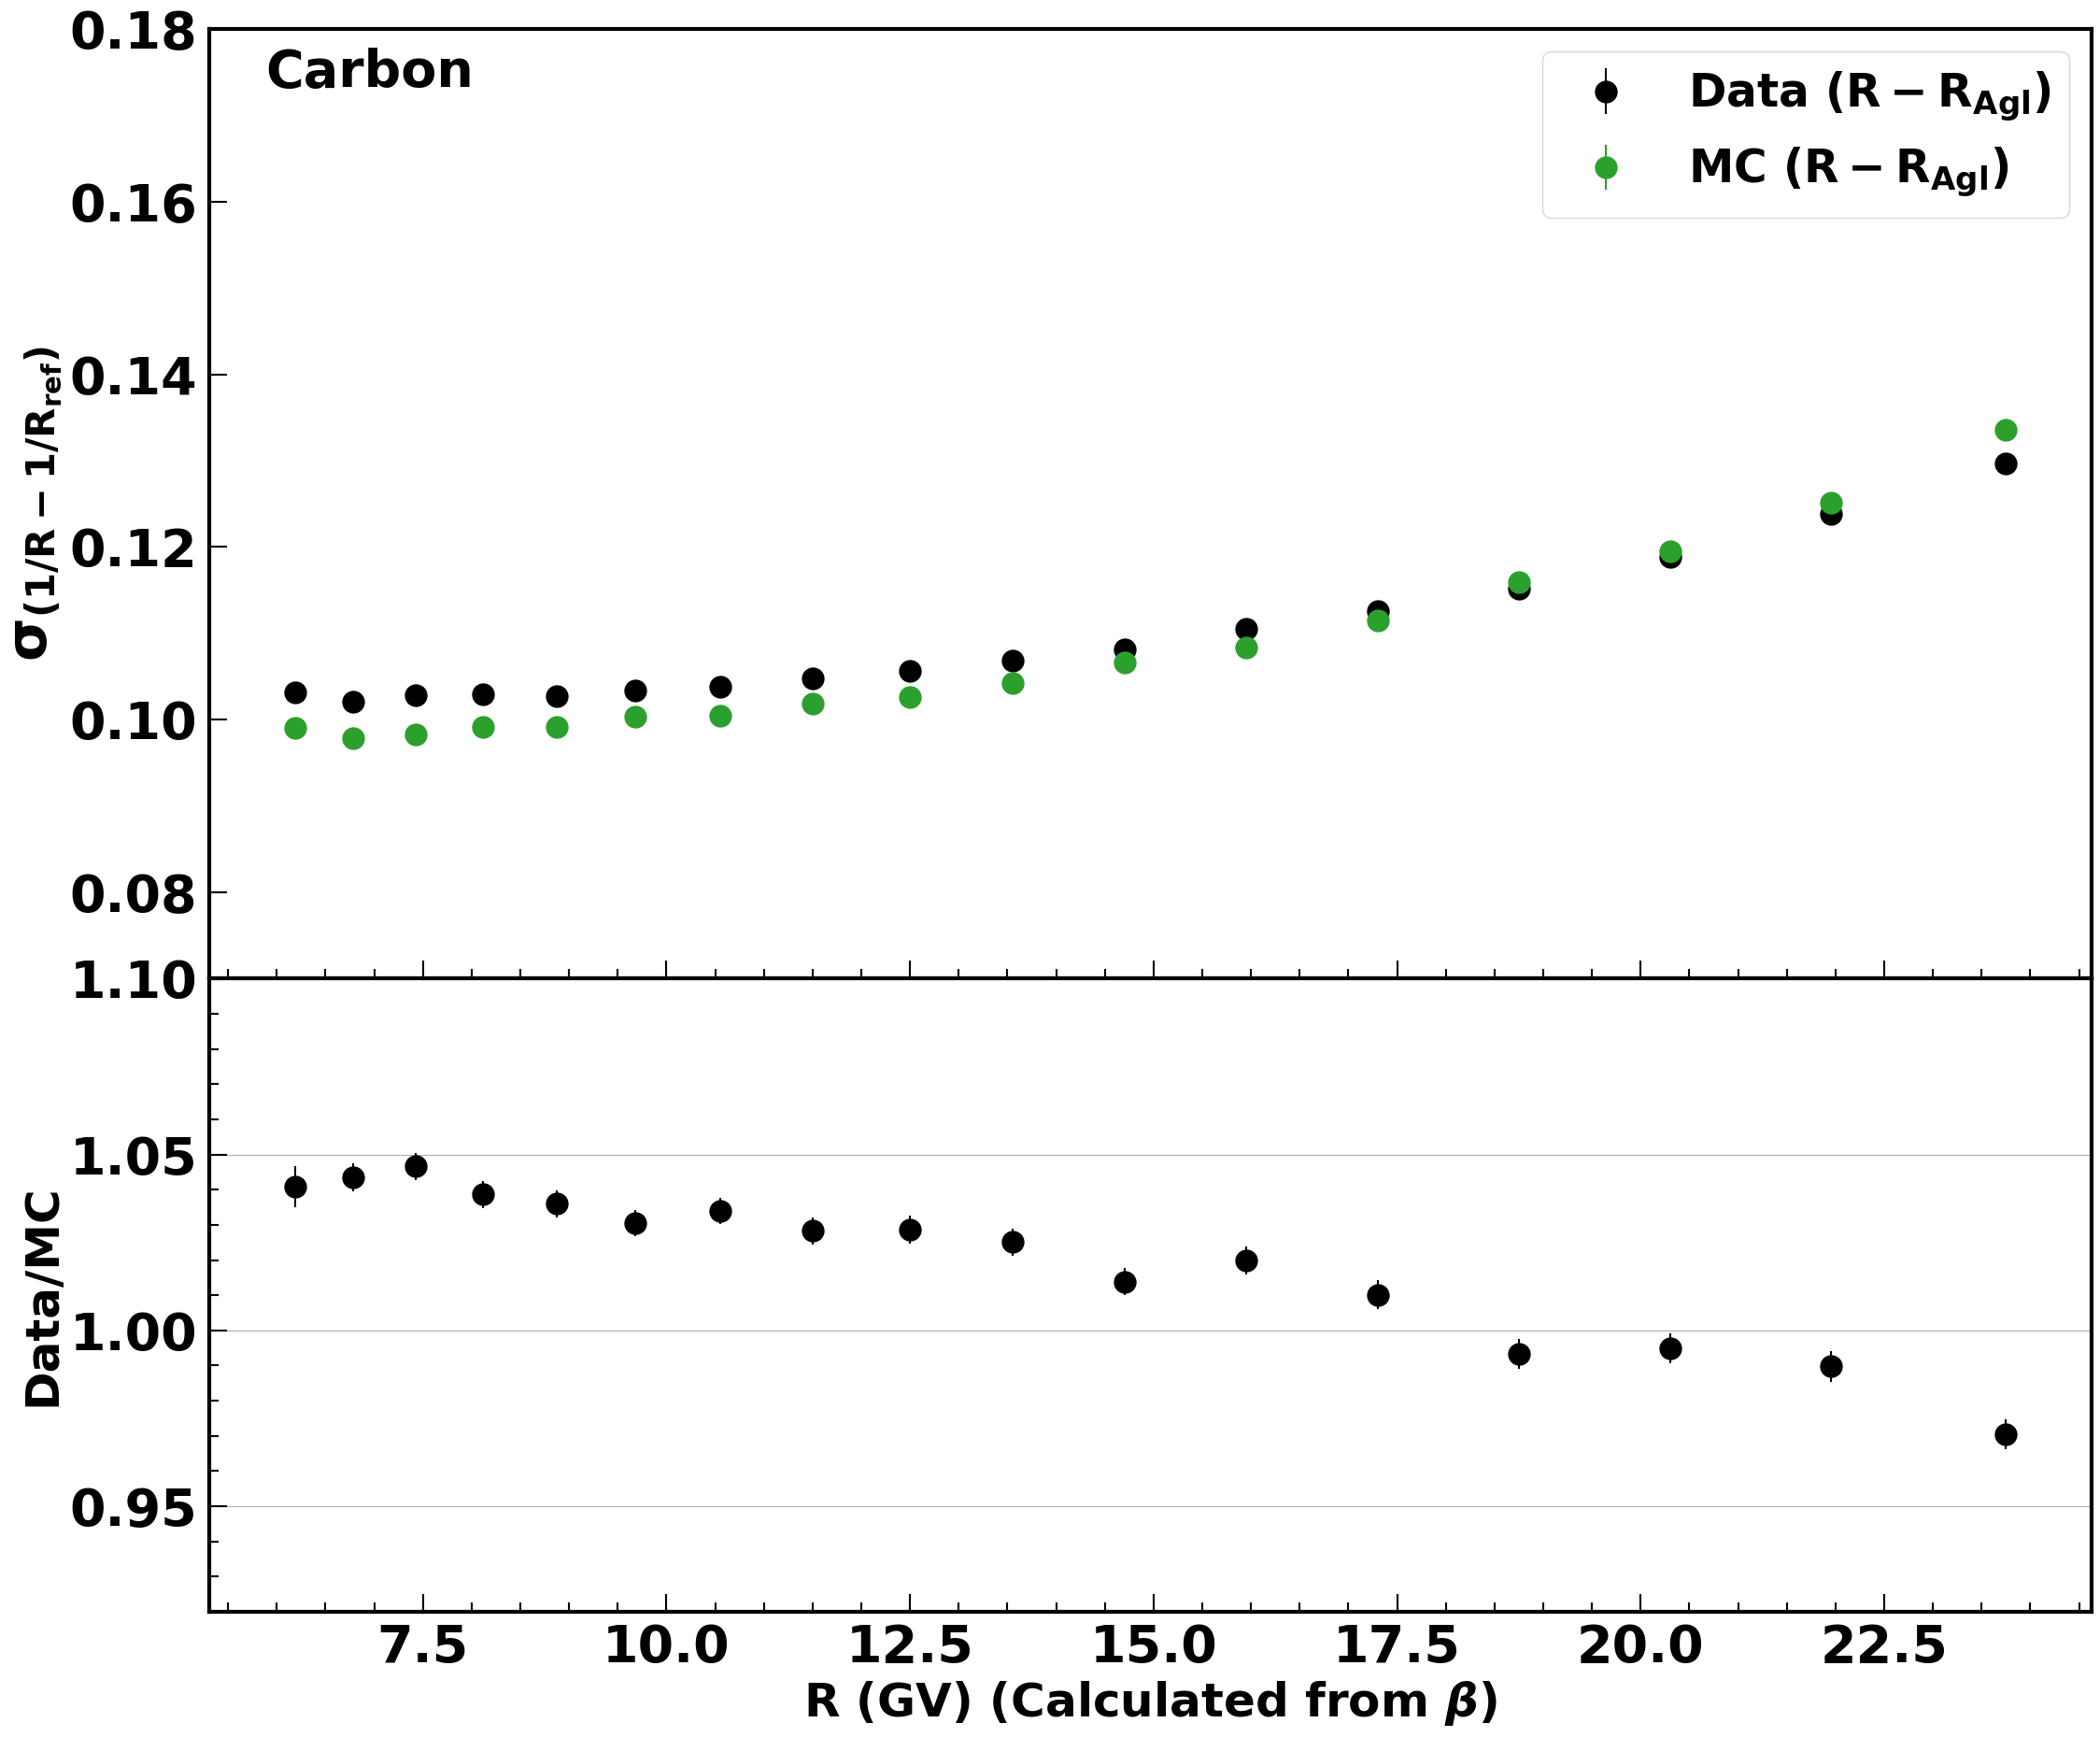

In [18]:
def set_plotstyle(ax1, ax2):
    plt.subplots_adjust(hspace=.0)   
    set_plot_defaultstyle(ax1)
    set_plot_defaultstyle(ax2)
    ax1.set_xticklabels([])
    
graph_mean_diff = {}

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(26, 22)) 
set_plotstyle(ax1, ax2)
for dec in decs:
    graph_mean_diff[dec] = MGraph(graph_mean_rigISS[dec].xvalues, graph_mean_rigISS[dec].yvalues - graph_mean_rigMC[dec].yvalues, abs(graph_mean_rigISS[dec].yerrs - graph_mean_rigMC[dec].yerrs))
    plot_graph(fig, ax1, graph_mean_rigISS[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=28, label=f'Data (R-R_{dec})') 
    plot_graph(fig, ax1, graph_mean_rigMC[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=28, marker='+', label=f'MC (R-R_{dec})')
    plot_graph(fig, ax2, graph_mean_diff[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=28)
    
ax2.set_xlabel('R (GV)')
ax1.set_ylabel(r'$\mathrm{\mu_{(1/R - 1/R_{ref})}}$')
ax2.set_ylabel('Data - MC')
#ax2.set_ylim([0.9, 1.1])
ax2.grid(axis='y')
#ax1.text(0.7, 0.98, f'{nuclei} Data', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='normal')  
#ax1.text(0.7, 0.94, f'{MCName} MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
ax1.set_ylim([-0.07, 0.05])
#ax1.set_xscale('log')
custom_ticks = [1, 2, 5, 10]  # Adjust these as needed
custom_labels = ['1', '2', '5',  '10']  # Labels for the ticks
ax1.legend()
ax1.text(0.03, 0.98, f'{nucleiname[nuclei]}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='bold')  
#ax1.set_xticks(custom_ticks)
#ax1.set_xticklabels(custom_labels)
#ax2.axhline(y=0.8, color='black', linestyle='--')
savefig_tofile(fig, plotfile, f"graph_mean_{figsuffix}_{nuclei}_RigReso_Ref{dec}", show=True) 



fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(26, 22)) 
set_plotstyle(ax1, ax2)
graph_ratio = {}
for dec in ['Agl']:
    graph_ratio[dec] = graph_sigma_rigISS[dec]/graph_sigma_rigMC[dec]
    plot_graph(fig, ax1, graph_sigma_rigISS[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=33, label=rf'Data ($\mathrm{{R-R_{{ {dec}}} }}$)') 
    plot_graph(fig, ax1, graph_sigma_rigMC[dec], color=DETECTOR_COLOR[dec],  style="EP", xlog=False, ylog=False, scale=None, markersize=33, label=rf'MC ($\mathrm{{R-R_{{ {dec} }} }}$)') 
    plot_graph(fig, ax2, graph_ratio[dec], color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=33) 
    
ax2.set_xlabel(r'R (GV) (Calculated from $\beta$)')
ax1.set_ylabel(r'$\mathrm{\sigma_{(1/R - 1/R_{ref})}}$', fontsize=43)
ax1.legend(loc='upper right', fontsize=35)


ax1.text(0.03, 0.98, f'{nucleiname[nuclei]}', fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=isscolor, weight='bold')  
#ax1.text(0.7, 0.94, f'{MCName} MC', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
ax1.set_ylim([0.07, 0.18])
#ax1.set_xscale('log')
custom_ticks = [1, 2, 5, 10]  # Adjust these as needed
custom_labels = ['1', '2', '5',  '10']  # Labels for the ticks
ax2.set_ylabel('Data/MC')
ax1.sharex(ax2)
ax2.set_ylim([0.92, 1.1])
ax2.grid(axis='y')
#ax1.set_xticks(custom_ticks)
#ax1.set_xticklabels(custom_labels)
#ax2.axhline(y=0.8, color='black', linestyle='--')
set_plot_style(ax1)
set_plot_style(ax2)
print(plotfile)
savefig_tofile(fig, plotfile, f"graph_sigma_{figsuffix}_{nuclei}_RigReso_Ref{dec}", show=True) 
